In [1]:
!nvidia-smi

Thu Mar 27 15:17:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4090        On  |   00000000:00:08.0 Off |                  Off |
| 30%   42C    P0             63W /  450W |       1MiB /  24564MiB |    100%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [1]:
import re
import torch
from PIL import Image
import matplotlib.pyplot as plt
import gc
import requests
import copy
from PIL import Image
from io import BytesIO
from torch.nn.functional import mse_loss
import numpy as np
import einops
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model
from llava.conversation import conv_templates
from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    IMAGE_PLACEHOLDER,
)
from llava.mm_utils import (
    process_images,
    tokenizer_image_token,
    get_model_name_from_path,
)

from utils.scripts.utils_llava import *
from utils.misc.misc import accuracy, accuracy_correct
from utils.scripts.algorithms_text_explanations import *
from utils.models.factory import create_model_and_transforms, get_tokenizer
from utils.misc.visualization import visualization_preprocess
from utils.models.prs_hook import hook_prs_logger
from utils.datasets_constants.imagenet_classes import imagenet_classes
from utils.datasets_constants.cifar_10_classes import cifar_10_classes
from utils.datasets_constants.cub_classes import cub_classes, waterbird_classes
import os
from utils.datasets.dataset_helpers import dataset_to_dataloader
from utils.scripts.algorithms_text_explanations_funcs import *
import tqdm
from torchvision.transforms import ToPILImage
import copy

/cluster/apps/vogtlab/users/vstrozzi/software/anaconda/envs/MT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Could not find the bitsandbytes CUDA binary at PosixPath('/cluster/apps/vogtlab/users/vstrozzi/software/anaconda/envs/MT/lib/python3.10/site-packages/bitsandbytes/libbitsandbytes_cuda121.so')
The installed version of bitsandbytes was compiled without GPU support. 8-bit optimizers, 8-bit multiplication, and GPU quantization are unavailable.


[2025-03-27 15:31:15,507] [INFO] [real_accelerator.py:161:get_accelerator] Setting ds_accelerator to cuda (auto detect)


In [2]:
## Parameters
device = 'cuda'
seed = 0
num_last_layers_ = 4
subset_dim = 10
tot_samples_per_class = 50
dataset_text_name = "top_1500_nouns_5_sentences_imagenet_clean"
datataset_image_name = "imagenet"
cache_dir = "../cache"
path = './datasets/'

In [3]:
# Helper functions
def image_parser(image_file, sep=","):
    out = image_file.split(sep)
    return out


def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


def load_images(image_files):
    out = []
    for image_file in image_files:
        image = load_image(image_file)
        out.append(image)
    return out

device = "cuda"
model_name = "liuhaotian/llava-v1.5-7b"
model_path = "/cluster/work/vogtlab/Group/vstrozzi/cache/models--liuhaotian--llava-v1.5-7b/snapshots/4481d270cc22fd5c4d1bb5df129622006ccd9234/"

## Get LLava Model

In [4]:
### IMPORT: On Biomedcluster change .config under model_path to point towards correct vision_tower clip path
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_name),
)
model.to("cpu")

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.
Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]/cluster/apps/vogtlab/users/vstrozzi/software/anaconda/envs/MT/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.26s/it]


LlavaLlamaForCausalLM(
  (model): LlavaLlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaR

In [5]:
# CLIP model
model_CLIP_name = 'ViT-L-14-336' 
pretrained = "openai"
precision = "fp16"

torch.cuda.empty_cache()
model_CLIP, _, preprocess_clip = create_model_and_transforms(model_CLIP_name, pretrained=pretrained, precision=precision, cache_dir="../cache")

model_CLIP.eval()
context_length = model_CLIP.context_length
# Not needed anymore
vocab_size = model_CLIP.vocab_size
tokenizer_CLIP = get_tokenizer(model_CLIP_name)

print(model_CLIP)
print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model_CLIP.visual.parameters()]):,}")
print("Context length:", context_length)
print("Vocab size:", vocab_size)
print("Len of res:", len(model_CLIP.visual.transformer.resblocks))
# Hook necessary to have: no projection on shared space, no spatial tokens in output (i.e. contributuon of attention to tokens), and hidden outputs of all tokens
prs = hook_prs_logger(model_CLIP, device, spatial=False, vision_projection=False, full_output=True) # This attach hook to get the residual stream

final_embeddings_images = torch.tensor(np.load(f"output_dir/{datataset_image_name}_embeddings_{model_CLIP_name}_seed_{seed}.npy", mmap_mode="r")).to(device)
final_embeddings_texts = torch.tensor(np.load(f"output_dir/{dataset_text_name}_{model_CLIP_name}.npy", mmap_mode="r")).to(device, dtype=final_embeddings_images.dtype)

attns_hid_mean = torch.tensor(np.load(f"output_dir/{datataset_image_name}_attns_mean_{model_CLIP_name}_seed_{seed}.npy", mmap_mode="r")) # [l, n, h, d], attention values
mlps_hid_mean = torch.tensor(np.load(f"output_dir/{datataset_image_name}_mlps_mean_{model_CLIP_name}_seed_{seed}.npy", mmap_mode="r"))  # [l + 1, n, d], mlp values

if datataset_image_name == "imagenet":
    ds_ = ImageNet(root=path+"imagenet/", split="val", transform=visualization_preprocess)
elif datataset_image_name == "binary_waterbirds":
    ds_ = BinaryWaterbirds(root=path+"waterbird_complete95_forest2water2/", split="test", transform=visualization_preprocess)
elif datataset_image_name == "CIFAR100":
    ds_ = CIFAR100(
        root=path, download=True, train=False, transform=visualization_preprocess
    )
elif datataset_image_name == "CIFAR10":
    ds_ = CIFAR10(
        root=path, download=True, train=False, transform=visualization_preprocess
    )
else:
    ds_ = ImageFolder(root=path, transform=visualization_preprocess)

classes_ = {
        'imagenet': imagenet_classes, 
        'CIFAR10': cifar_10_classes,
        'waterbirds': cub_classes, 
        'binary_waterbirds': waterbird_classes, 
        'cub': cub_classes}[datataset_image_name]
        
# Depending
ds_vis_ = dataset_subset(
    ds_,
    samples_per_class=subset_dim,
    tot_samples_per_class=tot_samples_per_class,  # or whatever you prefer
    seed=seed,
)

with open( f"utils/text_descriptions/{dataset_text_name}.txt", "r") as f:
    texts_str = np.array([i.replace("\n", "") for i in f.readlines()])


# Load inversionNet
inversion_net = InversionNet().to(device)

# Load the state dictionary.
state_dict = torch.load("output_dir/inversion_net_imagenet_0.pth", map_location=device)
inversion_net.load_state_dict(state_dict)

# Optionally set the model to evaluation mode.
inversion_net.eval()

CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm()
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-23): 24 x ResidualAttentionBlock(
          (ln_1): LayerNorm()
          (attn): MultiheadAttention(
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm()
          (mlp): MLP(
            (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
            (gelu): QuickGELUActivation()
            (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm()
  )
  (transformer): Transformer(
    (resblocks): ModuleList(
      (0-11): 12 x ResidualAttentionBlock(
        (ln_1): LayerNorm()
        (attn): Multih

InversionNet(
  (fc1): Linear(in_features=768, out_features=1024, bias=True)
  (gelu): GELU(approximate='none')
  (fc2): Linear(in_features=1024, out_features=1024, bias=True)
)

## Here play around with LLava

In [16]:
def mean_ablate_head(attentions, mlps, select_layer, layers=[], heads=[], 
                     attentions_mean_abl=None, mlps_mean_abl=None, 
                     mean_ablate_mlps=False, mean_ablate_attns=True,
                     ablation_type='mean', k_value=0.5, reduction_factor=0.1):
    # Clone the input tensors to prevent in-place modifications from affecting future calls
    attentions = attentions.clone()
    mlps = mlps.clone()

    # Expand the ablation tensors (if provided) to have a batch dimension
    attentions_mean_abl = attentions_mean_abl.unsqueeze(0)
    mlps_mean_abl = mlps_mean_abl.unsqueeze(0)
    
    # Define a helper function for soft thresholding:
    def apply_soft_threshold(tensor, threshold):
        # For values with absolute magnitude below the threshold, reduce their influence
        mask = tensor.abs() <= threshold
        return torch.where(mask, tensor * reduction_factor, tensor)

    # Replace the attention and mlp values for specified layers and heads according to ablation_type
    if heads and layers:
        for layer, head in zip(layers, heads):
            if mean_ablate_attns:
                if ablation_type == 'mean':
                    attentions[:, layer, :, head, :] = attentions_mean_abl[:, layer, :, head, :]
                elif ablation_type == 'zero':
                    attentions[:, layer, :, head, :] = 0
                elif ablation_type == 'half':
                    slice_tensor = attentions[:, layer, :, head, :]
                    num_elements = slice_tensor.numel()
                    # Determine the kth smallest value (with k computed from k_value)
                    k = max(1, int(num_elements * k_value))
                    kth_val = slice_tensor.abs().view(-1).kthvalue(k).values
                    mask = slice_tensor.abs() <= kth_val
                    attentions[:, layer, :, head, :] = slice_tensor.masked_fill(mask, 0)
                elif ablation_type == 'soft':
                    slice_tensor = attentions[:, layer, :, head, :]
                    num_elements = slice_tensor.numel()
                    k = max(1, int(num_elements * k_value))
                    # Compute threshold as kth smallest absolute value
                    threshold = slice_tensor.abs().view(-1).kthvalue(k).values
                    attentions[:, layer, :, head, :] = apply_soft_threshold(slice_tensor, threshold)
            if mean_ablate_mlps:
                if ablation_type == 'mean':
                    mlps[:, layer+1, :, :] = mlps_mean_abl[:, layer+1, :, :]
                elif ablation_type == 'zero':
                    mlps[:, layer+1, :, :] = 0
                elif ablation_type == 'half':
                    slice_tensor = mlps[:, layer+1, :, :]
                    num_elements = slice_tensor.numel()
                    k = max(1, int(num_elements * k_value))
                    kth_val = slice_tensor.abs().view(-1).kthvalue(k).values
                    mask = slice_tensor.abs() <= kth_val
                    mlps[:, layer+1, :, :] = slice_tensor.masked_fill(mask, 0)
                elif ablation_type == 'soft':
                    slice_tensor = mlps[:, layer+1, :, :]
                    num_elements = slice_tensor.numel()
                    k = max(1, int(num_elements * k_value))
                    threshold = slice_tensor.abs().view(-1).kthvalue(k).values
                    mlps[:, layer+1, :, :] = apply_soft_threshold(slice_tensor, threshold)

    # Since MLPs has one additional layer, handle the extra case if the layers form a continuous range
    layers_set = set(layers)
    is_continuous_from_zero = layers_set == set(range(len(layers_set))) and 23 in layers_set
    if mean_ablate_mlps and is_continuous_from_zero:
        if ablation_type == 'mean':
            mlps[:, 24, :, :] = mlps_mean_abl[:, 24, :, :]
        elif ablation_type == 'zero':
            mlps[:, 24, :, :] = 0
        elif ablation_type == 'half':
            slice_tensor = mlps[:, 24, :, :]
            num_elements = slice_tensor.numel()
            k = max(1, int(num_elements * k_value))
            kth_val = slice_tensor.abs().view(-1).kthvalue(k).values
            mask = slice_tensor.abs() <= kth_val
            mlps[:, 24, :, :] = slice_tensor.masked_fill(mask, 0)
        elif ablation_type == 'soft':
            slice_tensor = mlps[:, 24, :, :]
            num_elements = slice_tensor.numel()
            k = max(1, int(num_elements * k_value))
            threshold = slice_tensor.abs().view(-1).kthvalue(k).values
            mlps[:, 24, :, :] = apply_soft_threshold(slice_tensor, threshold)

    return attentions, mlps



def llava_pred(attentions, mlps, select_layer):
    # Compute the base sum over the first (select_layer + 1) layers.
    base = (attentions[:, :(select_layer + 1), :, :, :].sum(1).sum(2) +
            mlps[:, :(select_layer + 1), :, :].sum(1))
    
    return base

# Project 
def remove(a, b):
    a = a.squeeze()
    b = b.squeeze()
    return (a - (torch.dot(a, b) / torch.dot(b, b)) * b).unsqueeze(0)

def remove_patches(p, b):
    p = p.squeeze()
    for i in range(p.shape[0]):
        p[i:i+1, :] = remove(p[i:i+1, :], b)

    return p.unsqueeze(0)


def remove_direction(images_tensor: torch.Tensor, filter_concept_emb: torch.Tensor) -> torch.Tensor:
    """
    Removes the component of each vector in images_tensor along the direction given by filter_concept_emb.
    
    Args:
        images_tensor (torch.Tensor): Tensor of shape (1, 577, d).
        filter_concept_emb (torch.Tensor): Tensor of shape (1, d) representing the direction to remove.
        
    Returns:
        torch.Tensor: Tensor of shape (1, 577, d) with the component along filter_concept_emb removed.
    """
    # Expand filter_concept_emb to shape (1, 1, d) for broadcasting.
    filter_emb_expanded = filter_concept_emb.unsqueeze(1)  # shape: (1, 1, d)
    
    # Compute the dot product between each vector in images_tensor and filter_concept_emb.
    dot = (images_tensor * filter_emb_expanded).sum(dim=-1, keepdim=True)  # shape: (1, 577, 1)
    
    # Compute the squared norm of filter_concept_emb and expand for broadcasting.
    denom = (filter_concept_emb ** 2).sum(dim=-1, keepdim=True).unsqueeze(1)  # shape: (1, 1, 1)
    
    # Compute the projection of each vector in images_tensor onto filter_concept_emb.
    projection = (dot / denom) * filter_emb_expanded  # shape: (1, 577, d)
    
    # Remove the projection component.
    result_tensor = images_tensor - projection  # shape: (1, 577, d)
    
    return result_tensor


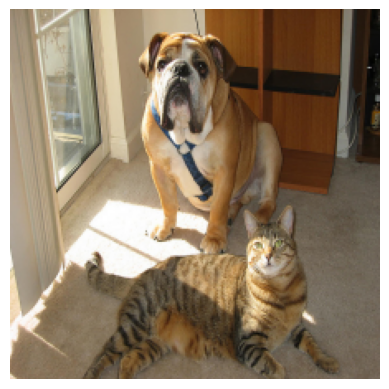

('The image features a brown and white cat lying on the floor, appearing to be relaxed and enjoying the sunlight. A large brown and white dog is standing nearby, positioned to the left of the cat. The dog and cat seem to be sharing the space peacefully, creating a cozy atmosphere.\n\nIn the background, there is a bookshelf with several books on it, adding a touch of personalization to the scene. A bottle can also be seen on the right side of the image, possibly a decorative or functional item in the room.',
 tensor([[[[[-1.1818e-02,  1.0620e-02, -1.0979e-02,  ...,  8.1406e-03,
             -2.2186e-02, -1.8826e-03],
            [-6.0081e-03,  4.8485e-03,  1.5366e-02,  ...,  5.2795e-03,
             -1.0262e-02, -1.2337e-02],
            [ 2.1820e-03, -5.3864e-03,  4.3716e-03,  ...,  9.4147e-03,
              5.7526e-03, -1.0338e-03],
            ...,
            [-8.8654e-03, -6.2180e-04, -1.9684e-03,  ...,  9.2468e-03,
             -1.2856e-02,  1.8873e-03],
            [-9.8801e-04, 

In [17]:
def llava_infer(prompt, pil_image, images_embeds=False, mean_ablate=False, from_layer_ablate = 0, to_layer_ablate = 10, mean_ablate_mlps=False, mean_ablate_attns=True, attentions_mean_abl=None, mlps_mean_abl=None, amplify_layer=21, amplify_head = None, amplification=1, filter_concept_emb=None): # If provided image embeds
    # Layer where to extract infos on patches
    select_layer = -2
    max_new_tokens = 512
    num_beams = 1 # numer of path of decision, less faster
    sep =  ","
    temperature = 0 # 0 lowest, det
    top_p = None

    ## Tokenization prompt
    image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
    # Making prompt in correct format
    if IMAGE_PLACEHOLDER in prompt:
        if model.config.mm_use_im_start_end:
            prompt = re.sub(IMAGE_PLACEHOLDER, image_token_se, prompt)
        else:
            prompt = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, prompt)
    else:
        if model.config.mm_use_im_start_end:
            prompt = image_token_se + "\n" + prompt
        else:
            prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt

    ## Convert model
    if "llama-2" in model_name.lower():
        conv_mode = "llava_llama_2"
    elif "mistral" in model_name.lower():
        conv_mode = "mistral_instruct"
    elif "v1.6-34b" in model_name.lower():
        conv_mode = "chatml_direct"
    elif "v1" in model_name.lower():
        conv_mode = "llava_v1"
    elif "mpt" in model_name.lower():
        conv_mode = "mpt"
    else:
        conv_mode = "llava_v0"

    if conv_mode is not None and conv_mode != conv_mode:
        print(
            "[WARNING] the auto inferred conversation mode is {}, while `--conv-mode` is {}, using {}".format(
                conv_mode, conv_mode, conv_mode
            )
        )
    else:
        conv_mode = conv_mode

    ## Load conversation mode standard template 
    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()
    # print(prompt)

    ## Load images from online or local
    """ image_files = image_parser(image_file, sep)
    images = load_images(image_files)
    image_sizes = [x.size for x in images] """
    
    image_sizes = [img.size]
    
    images_tensor = process_images(
        [pil_image],
        image_processor,
        model.config
    ).to(model.device, dtype=torch.float16)

    ## Tokenize prompt
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(device)
    )

    attentions = None
    mlps = None
    ## Use CLIP Model
    if images_embeds:
        prs.reinit()
        model_CLIP.eval()
        with torch.no_grad():
            model.to("cpu")
            model_CLIP.to("cuda")
            # Get output as we want it
            spatial_features = model_CLIP.encode_image(
                    images_tensor.to(device), 
                    attn_method='head_no_spatial',
                    normalize=False
                )

            model_CLIP.to("cpu")

            # Move directions
            attentions, mlps = prs.finalize(spatial_features)  # attentions: [b, l, n, h, d], mlps: [b, l + 1, n, d]

            # Compute spatial features required by our layer 
            if mean_ablate:
                attentions, mlps = mean_ablate_head(attentions, mlps, select_layer,
                layers = [y for x in range(0, 16) for y in range(from_layer_ablate, to_layer_ablate)],
                heads = [x for x in range(0, 16) for y in range(from_layer_ablate, to_layer_ablate)],
                attentions_mean_abl = attentions_mean_abl,
                mlps_mean_abl = mlps_mean_abl,
                mean_ablate_mlps = mean_ablate_mlps,
                mean_ablate_attns = mean_ablate_attns)
            
            # Amplify layer if required
            if amplification != 1:
                # TODO: Hardcoded, in this case if amplify head is specified we only amplify attentions head and not mlps
                if amplify_head != None:
                    attentions[:, amplify_layer, :, amplify_head] *= amplification
                else:
                    attentions[:, amplify_layer] *= amplification
                    mlps[:, amplify_layer + 1] *= amplification
                    
            images_tensor = llava_pred(attentions, mlps, select_layer)
            # Filter the concept on all the tokens
 
            if filter_concept_emb != None:
                images_tensor = remove_direction(images_tensor, filter_concept_emb)
            images_tensor[:, 1:], # Skip CLS
        # images_tensor = remove_patches(images_tensor, invert_topic_emb)
        # print(images_tensor.shape)
        # Swap some features position 
        # images_tensor[:, :192, :] = images_tensor[:, 384:, :] 
        # images_tensor[:, 192:384, :] = images_tensor[:, 384:, :] 
        # images_tensor[:, 384:, :] = images_tensor[:, 384:, :] 


    ## Generate an answer by using full model LLava
    model.to("cuda")
    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=images_tensor,
            image_sizes=image_sizes,
            #do_sample= True if temperature > 0 else False,
            #temperature=temperature,
            #top_p=top_p,
            num_beams=num_beams,
            max_new_tokens=max_new_tokens,
            use_cache=True,
            images_embeds = images_embeds # If want to give images embeds already precomputed TODO: Only support 1 image

        )

    ## Print the output
    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

    return outputs, attentions, mlps


# Params ('The image features a brown and white cat lying on the floor, looking up at the camera. The cat is positioned in the center of the scene, occupying a significant portion of the image. \n\nIn the background, there is a large brown dog standing on the floor, positioned to the left of the cat. The dog appears to be looking at the cat, creating a sense of interaction between the two animals. The scene is set in a room with a window, providing natural light to the space.',
#prompt = "You are a vision-language expert. Analyze the given image and classify it into one of the following categories:  \
#['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']. Answer with only the most appropriate category."
prompt = "Describe me the following image in deatils."
image_file = "images/catdog.png"

## Visualize image
img = Image.open(image_file)
plt.imshow(img)

plt.axis('off')  # Hide axis ticks and labels
plt.show()

#mean_final_images = torch.mean(final_embeddings_images, axis=0)
#mean_final_texts = torch.mean(final_embeddings_texts, axis=0)

#  Remove concept
#text_query = "An image of colour white and black"
# Tokenize the text query and move it to the device (GPU/CPU)
#text_query_token = tokenizer_CLIP(text_query).to(device)  
#model_CLIP.to("cuda")
#topic_emb = model_CLIP.encode_text(text_query_token, normalize=False)
#model_CLIP.to("cpu")
#topic_emb = inversion_net(topic_emb - mean_final_texts + mean_final_images).to(dtype=torch.float16)


# amplify_head (range [0-16[), amplify_layer (range between [0-24[)
llava_infer(prompt, img, images_embeds = True, mean_ablate = False, from_layer_ablate = 0, to_layer_ablate = 24, attentions_mean_abl=attns_hid_mean, mlps_mean_abl=mlps_hid_mean,  mean_ablate_mlps=False, mean_ablate_attns=False, amplify_layer=22, amplification=1, amplify_head=0, filter_concept_emb=None)

In [9]:
# The image features a brown and white dog and a brown and black cat sitting together on a carpeted floor. They appear to be relaxed and comfortable in each other's company. The dog is positioned on the left side of the cat, with both animals facing the same direction.
# In the background, there is a bookshelf with several books on it, adding a cozy and lived-in atmosphere to the scene.

## Qualitative test of MLPS ablations of LLAVA on some images

In [11]:
def visualize_most_similar_texts_images_clip(clip_output, final_embeddings_images, final_embeddings_texts, ds_vis, classes, texts_str):
    # Visualize ds Initialize arrays to store the top score
    scores_array_images = np.empty(
        final_embeddings_images.shape[0], 
        dtype=[('score', 'f4'), ('score_vis', 'f4'), ('img_index', 'i4')]
    )

    scores_array_texts = np.empty(
        final_embeddings_texts.shape[0], 
        dtype=[('score', 'f4'), ('score_vis', 'f4'), ('txt_index', 'i4')]
    )

    # Compute mean embeddings for centering
    mean_final_images = torch.mean(final_embeddings_images,  axis=0)
    mean_final_texts = torch.mean(final_embeddings_texts, axis=0)

    # Create arrays of indexes for referencing images and texts.
    indexes_images = np.arange(0, final_embeddings_images.shape[0], 1) 
    indexes_texts = np.arange(0, final_embeddings_texts.shape[0], 1)

    # Get mean of data and texts
    mean_final_images = torch.mean(final_embeddings_images, axis=0).to(device)
    mean_final_texts = torch.mean(final_embeddings_texts, axis=0).to(device)

    # Compute scores for images

    scores_array_images["score_vis"] = (final_embeddings_images @ clip_output.T).squeeze().cpu().numpy()
    scores_array_texts["score_vis"] = (final_embeddings_texts @ clip_output.T).squeeze().cpu().numpy()

    clip_output /= clip_output.norm(dim=-1, keepdim=True)
    final_embeddings_images /= final_embeddings_images.norm(dim=-1, keepdim=True)
    final_embeddings_texts /= final_embeddings_texts.norm(dim=-1, keepdim=True)

    scores_array_images["score"] = (final_embeddings_images @ clip_output.T).squeeze().cpu().numpy()
    scores_array_texts["score"] = (final_embeddings_texts @ clip_output.T).squeeze().cpu().numpy()

    scores_array_images["img_index"] = indexes_images
    scores_array_texts["txt_index"] = indexes_texts


    # Define the number of top and worst images to look at for each princ_comp
    nr_top_imgs = 4  # Number of top elements
    nr_worst_imgs = 0  # Number of worst elements
    nr_cont_imgs = 0  # Length of continuous elements

    dbs = create_dbs(scores_array_images, scores_array_texts, nr_top_imgs, nr_worst_imgs, nr_cont_imgs)

    # Hardcoded visualizations
    nrs_dbs = [nr_top_imgs, nr_worst_imgs, nr_cont_imgs]
    dbs_new = []
    for i, db in enumerate(dbs):
        if nrs_dbs[i] == 0:
            continue
        dbs_new.append(db)
    # Visualize 
    visualize_dbs_no_data(dbs_new, ds_vis, texts_str, classes)

In [12]:
from scipy.interpolate import make_interp_spline
import numpy as np
import torch
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

def measure_metric(attns, mlps, metric="norm"):
    """
    Measure per-layer contributions using one of three metrics:
      - "norm": Norm ratio of each layer's vector relative to the total residual stream.
      - "cosine": Cosine similarity between each layer's vector and the total residual vector.
      - "correlation": Pearson correlation coefficient between each layer's vector and the total residual vector.
      
    Also computes a corresponding metric "relative to CLS" (comparing each token’s vector to the CLS token's vector).
    
    Parameters:
        attns (torch.Tensor): Attention contributions, expected shape [1, l, n, h, d]
        mlps (torch.Tensor): MLP contributions, expected shape [1, l+1, n, d]
        metric (str): One of "norm" (default), "cosine", or "correlation".
    """
    # Remove the batch dimension
    attns = attns.squeeze(0)  # shape: [l, n, h, d]
    mlps = mlps.squeeze(0)    # shape: [l+1, n, d]

    # Sum attention weights over heads
    attns_sum = attns.sum(dim=2)  # shape: [l, n, d]

    # Compute total contributions per token
    attn_total = attns_sum.sum(dim=0).unsqueeze(0)  # shape: [1, n, d]
    mlp_total  = mlps.sum(dim=0).unsqueeze(0)         # shape: [1, n, d]
    res_total_patch = attn_total + mlp_total         # shape: [1, n, d]

    # Compute norms per layer for each token for attention and MLPs
    attn_norms = attns_sum.norm(dim=-1)  # shape: [l, n]
    mlp_norms  = mlps.norm(dim=-1)        # shape: [l+1, n]
    
    # Small epsilon to avoid division by zero in cosine similarity
    eps = 1e-8

    if metric == "norm":
        # --- Compute the norm ratio ---
        attn_metric = attn_norms / res_total_patch.norm(dim=-1)  # shape: [l, n]
        mlp_metric  = mlp_norms  / res_total_patch.norm(dim=-1)   # shape: [l+1, n]
        
        # Fractions relative to the CLS token (token index 0)
        attn_metric_to_cls = attn_norms / attn_norms[:, 0].unsqueeze(-1)  # shape: [l, n]
        mlp_metric_to_cls  = mlp_norms  / mlp_norms[:, 0].unsqueeze(-1)    # shape: [l+1, n]
        
        # CLS token values (for plotting)
        attn_metric_cls = attn_metric[:, 0]
        mlp_metric_cls  = mlp_metric[:, 0]
        
        metric_label = "Norm Ratio"
    
    elif metric == "cosine":
        # --- Compute the cosine similarity ---
        res_total_patch_norm = res_total_patch.norm(dim=-1)  # shape: [1, n]
        
        # Dot products between each layer and the total (broadcasting over layers)
        attn_dot = (attns_sum * res_total_patch).sum(dim=-1)  # shape: [l, n]
        mlp_dot  = (mlps      * res_total_patch).sum(dim=-1)  # shape: [l+1, n]
        
        attn_metric = attn_dot / (attn_norms * res_total_patch_norm + eps)
        mlp_metric  = mlp_dot  / (mlp_norms  * res_total_patch_norm + eps)
        
        # Cosine similarity relative to the CLS token vector (per layer)
        attn_cls = attns_sum[:, 0:1, :]  # shape: [l, 1, d]
        mlp_cls  = mlps[:, 0:1, :]        # shape: [l+1, 1, d]
        
        attn_dot_cls = (attns_sum * attn_cls).sum(dim=-1)  # shape: [l, n]
        mlp_dot_cls  = (mlps      * mlp_cls).sum(dim=-1)    # shape: [l+1, n]
        
        attn_cls_norm = attn_norms[:, 0].unsqueeze(-1)  # shape: [l, 1]
        mlp_cls_norm  = mlp_norms[:, 0].unsqueeze(-1)    # shape: [l+1, 1]
        
        attn_metric_to_cls = attn_dot_cls / (attn_norms * attn_cls_norm + eps)
        mlp_metric_to_cls  = mlp_dot_cls  / (mlp_norms  * mlp_cls_norm  + eps)
        
        attn_metric_cls = attn_metric[:, 0]
        mlp_metric_cls  = mlp_metric[:, 0]
        
        metric_label = "Cosine Similarity"
    
    elif metric == "correlation":
        # --- Compute the Pearson correlation coefficient ---
        # Define a helper to compute correlation along the last dimension.
        def pearson_corr(x, y, eps=1e-8):
            # x, y: tensors with shape [..., d]
            x_mean = x.mean(dim=-1, keepdim=True)
            y_mean = y.mean(dim=-1, keepdim=True)
            x_centered = x - x_mean
            y_centered = y - y_mean
            cov = (x_centered * y_centered).sum(dim=-1)
            std_x = x_centered.norm(dim=-1)
            std_y = y_centered.norm(dim=-1)
            return cov / (std_x * std_y + eps)
        
        # Compute correlation between each layer's vector and the total residual vector.
        # Expand res_total_patch to match the shape of attns_sum and mlps.
        attn_metric = pearson_corr(attns_sum, res_total_patch.expand_as(attns_sum))
        mlp_metric  = pearson_corr(mlps,      res_total_patch.expand_as(mlps))
        
        # For correlation relative to the CLS token: compare each token's vector with the CLS token's vector in that layer.
        attn_metric_to_cls = pearson_corr(attns_sum, attns_sum[:, 0:1, :].expand_as(attns_sum))
        mlp_metric_to_cls  = pearson_corr(mlps,      mlps[:, 0:1, :].expand_as(mlps))
        
        attn_metric_cls = attn_metric[:, 0]
        mlp_metric_cls  = mlp_metric[:, 0]
        
        metric_label = "Correlation"
    
    else:
        raise ValueError("Unknown metric. Please choose 'norm', 'cosine', or 'correlation'.")
    
    # --- Compute mean and std for each metric ---
    layers_attn = np.arange(attn_metric.shape[0])
    attn_mean = attn_metric.mean(dim=1).detach().cpu().numpy()
    attn_std  = attn_metric.std(dim=1).detach().cpu().numpy()
    attn_cls_vals = attn_metric[:, 0].detach().cpu().numpy()

    layers_mlp = np.arange(mlp_metric.shape[0])
    mlp_mean = mlp_metric.mean(dim=1).detach().cpu().numpy()
    mlp_std  = mlp_metric.std(dim=1).detach().cpu().numpy()
    mlp_cls_vals = mlp_metric[:, 0].detach().cpu().numpy()

    layers_attn_cls = np.arange(attn_metric_to_cls.shape[0])
    attn_to_cls_mean = attn_metric_to_cls.mean(dim=1).detach().cpu().numpy()
    attn_to_cls_std  = attn_metric_to_cls.std(dim=1).detach().cpu().numpy()

    layers_mlp_cls = np.arange(mlp_metric_to_cls.shape[0])
    mlp_to_cls_mean = mlp_metric_to_cls.mean(dim=1).detach().cpu().numpy()
    mlp_to_cls_std  = mlp_metric_to_cls.std(dim=1).detach().cpu().numpy()

    # --- Create the plots without smoothing ---
    plt.figure(figsize=(12, 10))

    # Plot 1: Attention metric per layer (with CLS token)
    plt.subplot(2, 2, 1)
    plt.plot(layers_attn, attn_mean, '-', label='Mean')
    plt.fill_between(layers_attn, attn_mean - attn_std, attn_mean + attn_std, alpha=0.3, label='±1 Std')
    plt.plot(layers_attn, attn_cls_vals, '-', label='CLS Token')
    plt.xlabel("Layer")
    plt.ylabel(f"Attention {metric_label}")
    plt.title(f"Attention {metric_label} per Token across Layers\nRelative to own Res. Stream with ±1 Std")
    plt.xticks(np.arange(0, attn_metric.shape[0], 1))
    plt.legend()

    # Plot 2: MLP metric per layer (with CLS token)
    plt.subplot(2, 2, 2)
    plt.plot(layers_mlp, mlp_mean, '-', label='Mean')
    plt.fill_between(layers_mlp, mlp_mean - mlp_std, mlp_mean + mlp_std, alpha=0.3, label='±1 Std')
    plt.plot(layers_mlp, mlp_cls_vals, '-', label='CLS Token')
    plt.xlabel("Layer")
    plt.ylabel(f"MLP {metric_label}")
    plt.title(f"MLP {metric_label} per Token across Layers\nRelative to own Res. Stream with ±1 Std")
    plt.xticks(np.arange(0, mlp_metric.shape[0], 1))
    plt.legend()

    # Plot 3: Attention metric per layer relative to CLS
    plt.subplot(2, 2, 3)
    plt.plot(layers_attn_cls, attn_to_cls_mean, '-', label='Mean')
    plt.fill_between(layers_attn_cls, attn_to_cls_mean - attn_to_cls_std, attn_to_cls_mean + attn_to_cls_std, alpha=0.3, label='±1 Std')
    plt.xlabel("Layer")
    plt.ylabel(f"Attention {metric_label} (to CLS)")
    plt.title(f"Attention {metric_label} per Token across Layers\nRelative to CLS with ±1 Std")
    plt.xticks(np.arange(0, attn_metric_to_cls.shape[0], 1))
    plt.legend()

    # Plot 4: MLP metric per layer relative to CLS
    plt.subplot(2, 2, 4)
    plt.plot(layers_mlp_cls, mlp_to_cls_mean, '-', label='Mean')
    plt.fill_between(layers_mlp_cls, mlp_to_cls_mean - mlp_to_cls_std, mlp_to_cls_mean + mlp_to_cls_std, alpha=0.3, label='±1 Std')
    plt.xlabel("Layer")
    plt.ylabel(f"MLP {metric_label} (to CLS)")
    plt.title(f"MLP {metric_label} per Token across Layers\nRelative to CLS with ±1 Std")
    plt.xticks(np.arange(0, mlp_metric_to_cls.shape[0], 1))
    plt.legend()

    plt.tight_layout()
    plt.show()

LLAVA output on used mean ablation of MLPs and ATTNs
The image shows a person wearing a pair of sunglasses, with a blue and white shirt.




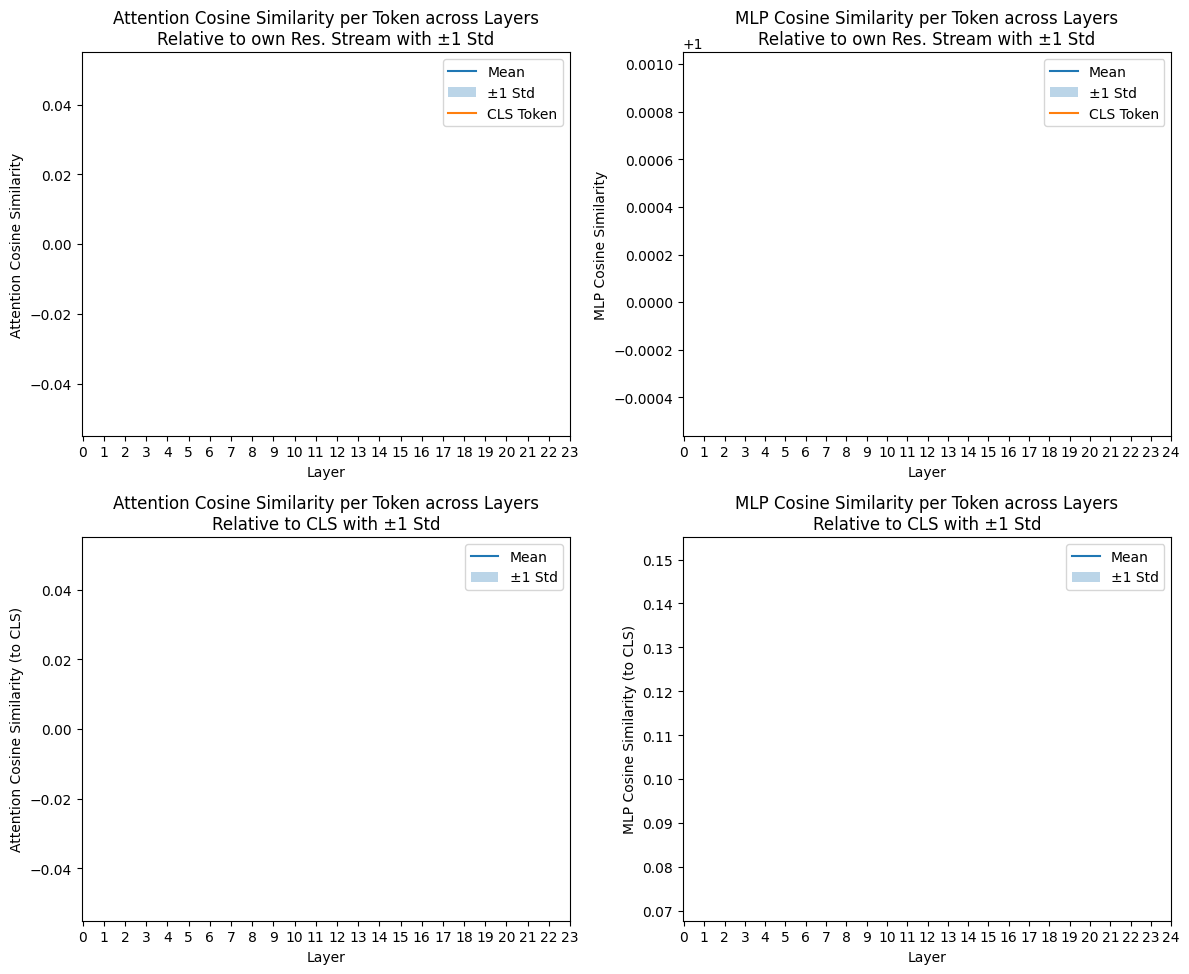

Original CLIP on used mean ablation of MLPs and ATTNs
Printing highest cosine similarity
+----+-----------------------------------------+---------------------+---------------+
|    | Text                                    |   Cosine Similarity |   Correlation |
|----+-----------------------------------------+---------------------+---------------|
|  0 | An image that is the first of its kind. |            0.254395 |       3.42773 |
|  1 | An image of force.                      |            0.248657 |       3.34766 |
|  2 | An image of strength.                   |            0.246216 |       3.31641 |
|  3 | An image of beauty.                     |            0.243652 |       3.28125 |
+----+-----------------------------------------+---------------------+---------------+


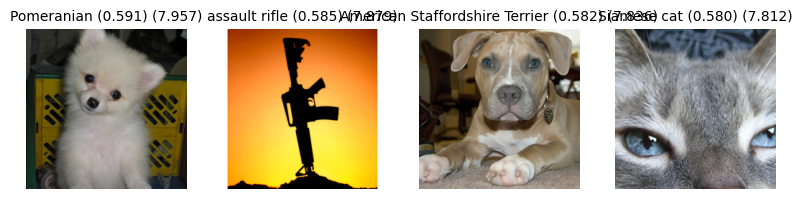



Displaying the image images/cropped-american_robin.jpg


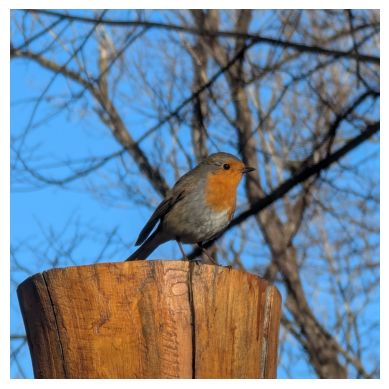

Original LLAVA output
The image features a small bird perched on a wooden post or a tree branch, looking around and observing its surroundings.
 The bird is positioned towards the center of the scene, with its head facing the viewer.
 The wooden post or branch appears to be a part of a fence, as there is a fence visible in the background.
 The scene is set against a blue sky, creating a serene and peaceful atmosphere.




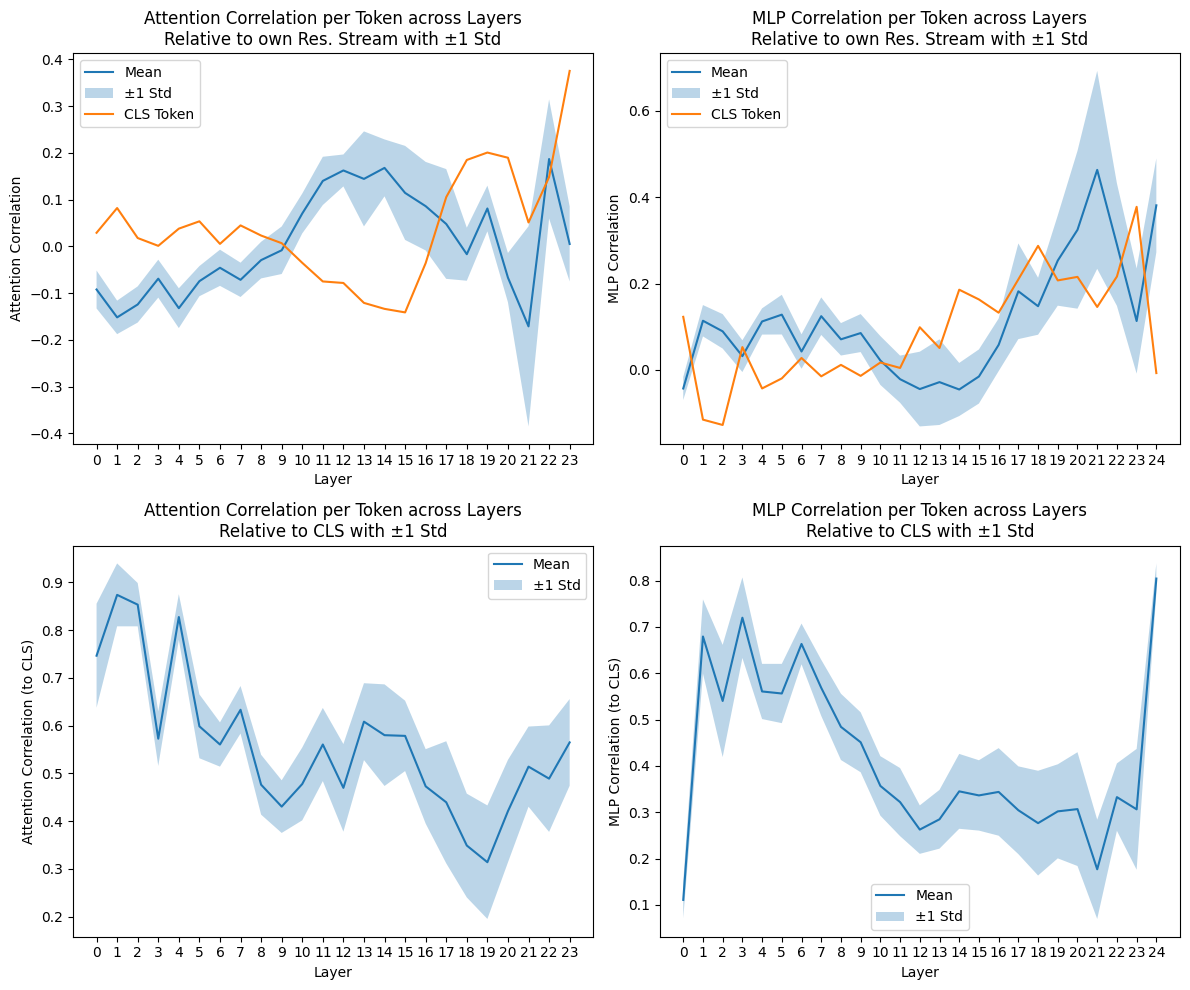

Original CLIP  output text and images
Printing highest cosine similarity
+----+---------------------------------------+---------------------+---------------+
|    | Text                                  |   Cosine Similarity |   Correlation |
|----+---------------------------------------+---------------------+---------------|
|  0 | An image of a bird with a red breast. |            0.253906 |       4.58594 |
|  1 | An image of a small bird.             |            0.25293  |       4.56641 |
|  2 | An image of a bird.                   |            0.252197 |       4.55859 |
|  3 | An image of a bird standing.          |            0.252197 |       4.55859 |
+----+---------------------------------------+---------------------+---------------+


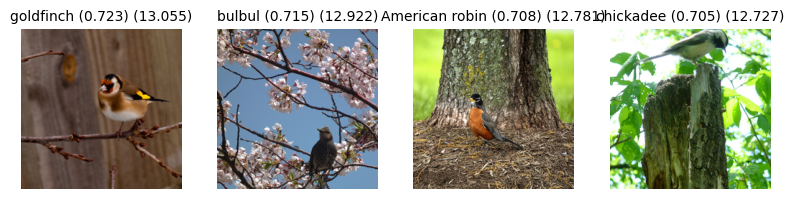



MLPS mean ablated LLAVA output
The image features a large, white, and round object, possibly a large pillar or a large piece of art, placed in the center of the scene.
 The object is surrounded by a wooden platform, giving it a sense of prominence.
 The platform is positioned on top of a wooden plank, which is in turn placed on a wooden base.
 The overall composition of the scene creates a sense of balance and harmony.


MLPS mean ablated CLIP output text and images
Printing highest cosine similarity
+----+------------------------------------------------+---------------------+---------------+
|    | Text                                           |   Cosine Similarity |   Correlation |
|----+------------------------------------------------+---------------------+---------------|
|  0 | An image that is the first of its kind.        |            0.235107 |       2.64648 |
|  1 | An image of a fairytale.                       |            0.233398 |       2.62695 |
|  2 | An image of som

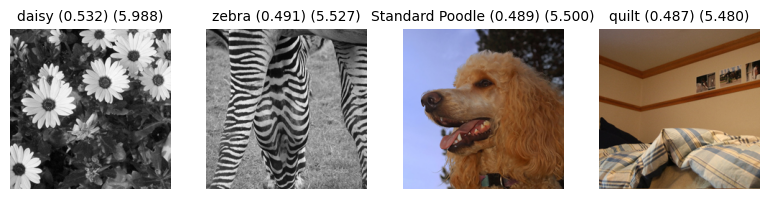




Displaying the image images/cropped-pile_of_animals.jpg


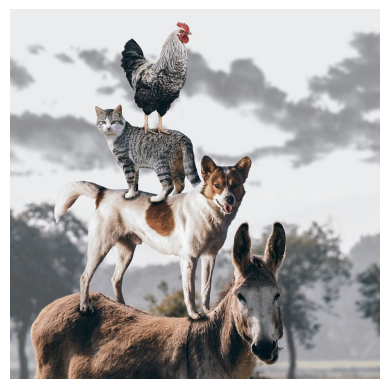

Original LLAVA output
The image features a unique scene where a cat, a dog, and a chicken are all sitting on top of a donkey.
 The cat is positioned on the left side of the donkey, while the dog is on the right side.
 The chicken is perched on the donkey's back, close to the center of the scene.
The animals seem to be enjoying their time together, creating a whimsical and unconventional moment.
 The donkey appears to be patiently carrying the three animals on its back.




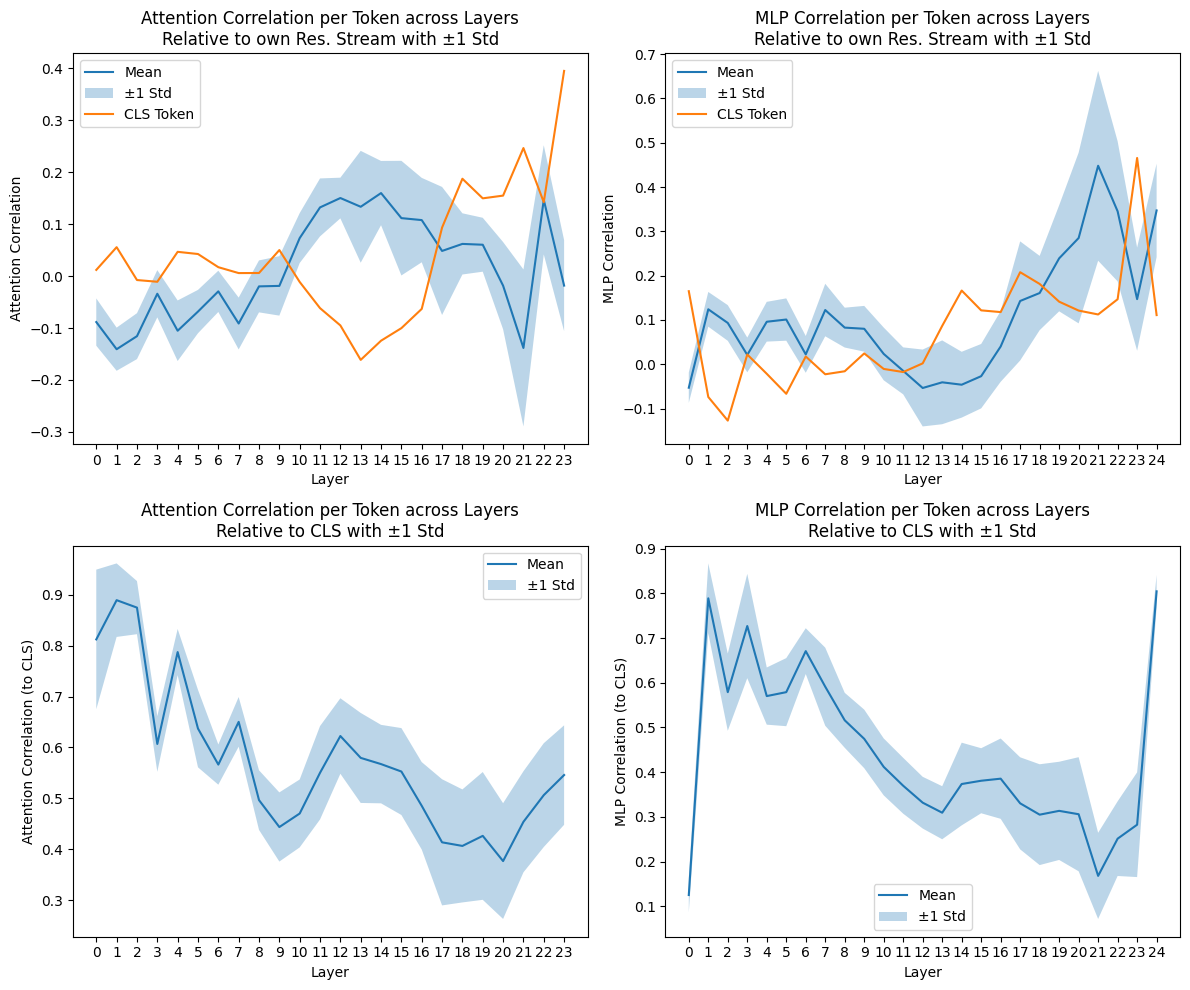

Original CLIP  output text and images
Printing highest cosine similarity
+----+--------------------------------------------------+---------------------+---------------+
|    | Text                                             |   Cosine Similarity |   Correlation |
|----+--------------------------------------------------+---------------------+---------------|
|  0 | An image of a diverse group of animals.          |            0.265137 |       5.20703 |
|  1 | An image of farm animals like cows and chickens. |            0.263428 |       5.17188 |
|  2 | An image of a group of animals.                  |            0.262695 |       5.15625 |
|  3 | An image of a group of animals moving together.  |            0.251953 |       4.94922 |
+----+--------------------------------------------------+---------------------+---------------+


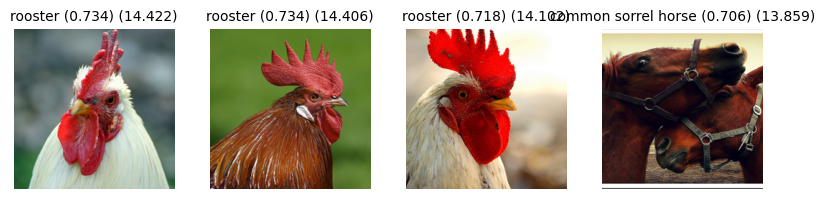



MLPS mean ablated LLAVA output
The image features a large chicken coop with a flock of chickens inside.
 There are at least 13 chickens visible in the coop, with some of them standing closer to the front and others further back.
 The chickens are of various sizes, indicating a diverse age range within the flock.
 The coop is filled with hay, providing a comfortable and safe environment for the chickens.


MLPS mean ablated CLIP output text and images
Printing highest cosine similarity
+----+------------------------------------------------+---------------------+---------------+
|    | Text                                           |   Cosine Similarity |   Correlation |
|----+------------------------------------------------+---------------------+---------------|
|  0 | An image representing yesterday.               |            0.223267 |       2.81641 |
|  1 | An image of an agency.                         |            0.221069 |       2.78906 |
|  2 | An image of something standing 

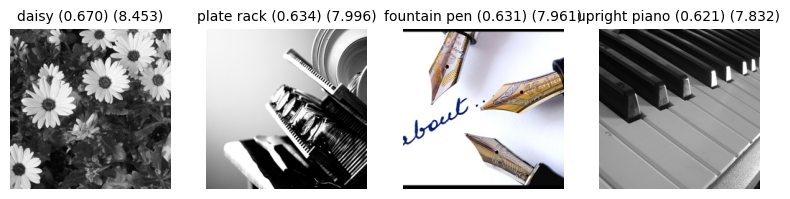




Displaying the image images/cropped-stone-wall-5432657_1280.jpg


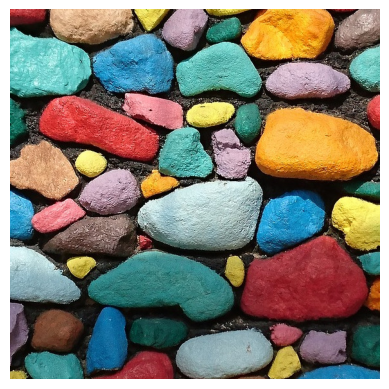

Original LLAVA output
The image features a colorful wall made of various colored rocks, creating a visually appealing and unique design.
 The wall is composed of numerous small rocks, each with different colors and sizes, creating a vibrant and diverse appearance.
 The rocks are arranged in a way that they form a cohesive pattern, making the wall stand out as an artistic and creative display.




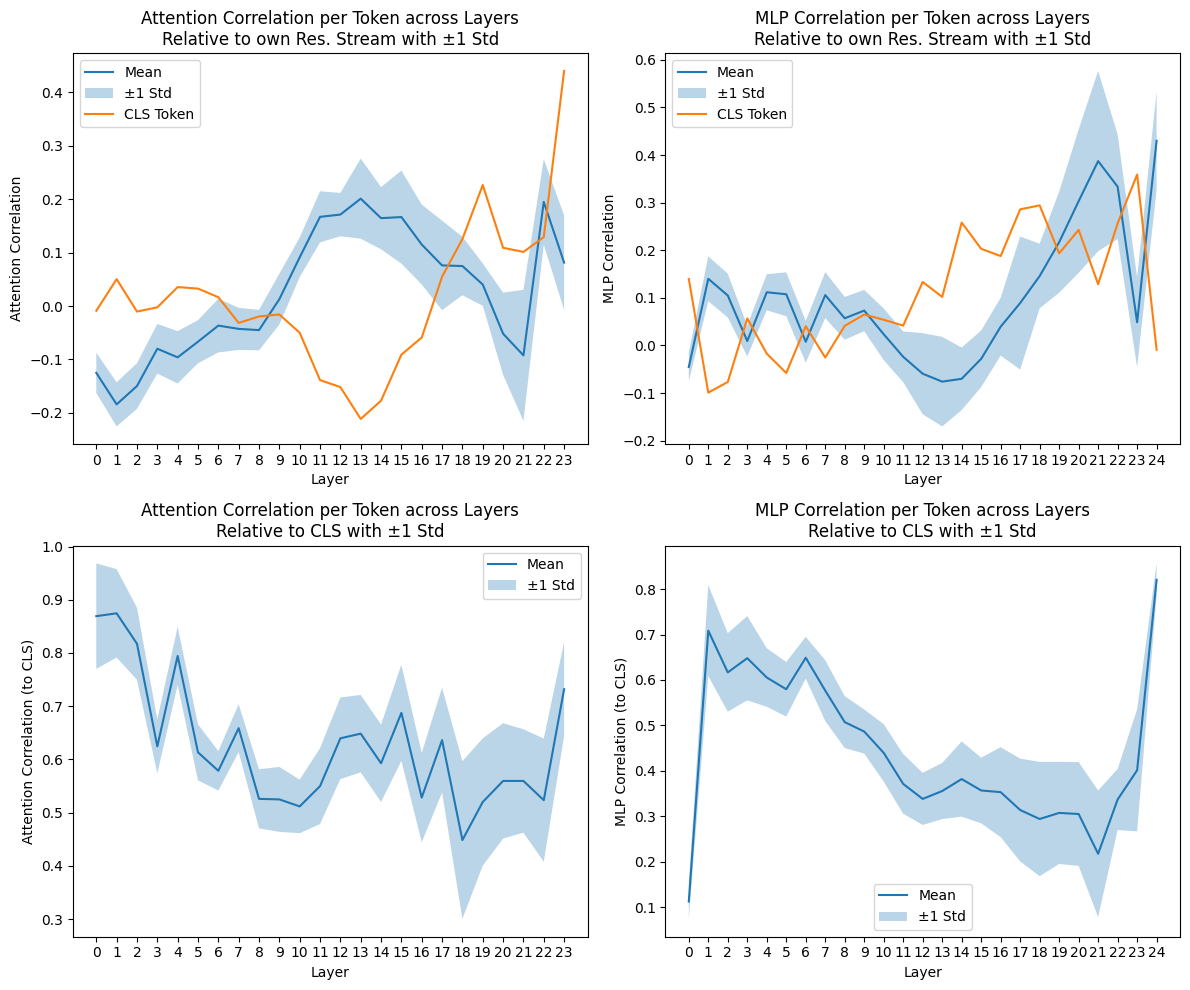

Original CLIP  output text and images
Printing highest cosine similarity
+----+--------------------------------------------------------+---------------------+---------------+
|    | Text                                                   |   Cosine Similarity |   Correlation |
|----+--------------------------------------------------------+---------------------+---------------|
|  0 | An image of a colorful stack of blocks.                |            0.266602 |       5.30078 |
|  1 | An image of a stone wall.                              |            0.252686 |       5.02344 |
|  2 | An image of a colorful, abstract scene full of shapes. |            0.247559 |       4.92188 |
|  3 | An image of a colorful patterned object.               |            0.247437 |       4.91797 |
+----+--------------------------------------------------------+---------------------+---------------+


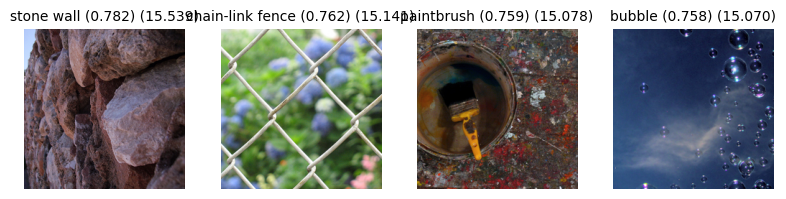



MLPS mean ablated LLAVA output
The image features a large, colorful rock wall with a variety of colors, including shades of blue, white, and gray.
 The wall appears to be made of different types of rocks, creating a visually striking and unique pattern.
 The wall is positioned in the center of the image, with a large portion of it visible.
 The combination of the different colors and the variety of rocks make this wall an interesting and eye-catching feature.


MLPS mean ablated CLIP output text and images
Printing highest cosine similarity
+----+------------------------------------------------+---------------------+---------------+
|    | Text                                           |   Cosine Similarity |   Correlation |
|----+------------------------------------------------+---------------------+---------------|
|  0 | An image of something standing out in a scene. |            0.21875  |       2.71875 |
|  1 | An image of a movie poster.                    |            0.216187

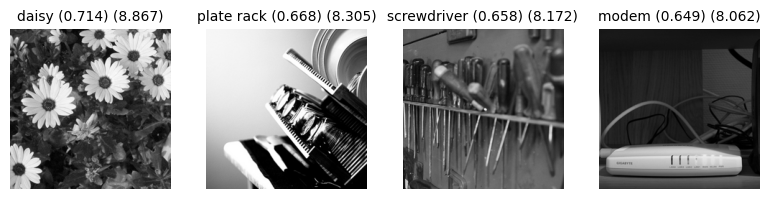

In [19]:
# Prompt and images
prompt = "Describe me the following image in details."
images_files = ["images/cropped-american_robin.jpg", "images/cropped-pile_of_animals.jpg", "images/cropped-stone-wall-5432657_1280.jpg"]
# Until which which layer ablate and if want to reverse (not until but to layer)
from_layer_ablate = 0
to_layer_ablate = 24

mean_ablate_mlps = False
mean_ablate_attns = True

amplify_layer = 21
amplification = 1

# Extract necessary pprojection for clip
ln_post = copy.deepcopy(model_CLIP.visual.ln_post).to("cuda")
proj = copy.deepcopy(model_CLIP.visual.proj).to("cuda")

# First analyze mean contribution using VLM and CLIP
# Load as PIL
img = Image.open(images_files[0])
output, attns, mlps = llava_infer(prompt, img, images_embeds = True, mean_ablate = True, from_layer_ablate=0, to_layer_ablate = 24, attentions_mean_abl=attns_hid_mean, mlps_mean_abl=mlps_hid_mean, mean_ablate_mlps=True, mean_ablate_attns=True, amplify_layer=21, amplification=1)
print("LLAVA output on used mean ablation of MLPs and ATTNs")
print(output.replace("\n", "").replace(".", ".\n"))
print()
# Call CLIP on normal image 
measure_metric(attns, mlps, metric="cosine")
hidden_output_test = ln_post(attns[:, :, 0].sum(1).sum(1) + mlps[:, :, 0].sum(1)) # only CLS token
test_clip_out = hidden_output_test @ proj
print("Original CLIP on used mean ablation of MLPs and ATTNs")
visualize_most_similar_texts_images_clip(test_clip_out.detach(), final_embeddings_images, final_embeddings_texts, ds_vis_, classes_, texts_str)
print()
print()

# Main analysis
for image_file in images_files:
    print(f"Displaying the image {image_file}")
    # Load as PIL
    img = Image.open(image_file)
    # Show it
    plt.imshow(img)
    plt.axis('off')  # Hide axis ticks and labels
    plt.show()

    ## Call LLAVA on normal image without modifying
    output, attns, mlps = llava_infer(prompt, img, images_embeds = True)
    #print(attns.sum(3).sum(1).norm())
    #print(mlps.sum(1).norm())
    print("Original LLAVA output")
    print(output.replace("\n", "").replace(".", ".\n"))
    print()
    # Call CLIP on normal image 
    measure_metric(attns, mlps, metric="correlation")
    hidden_output_test = ln_post(attns[:, :, 0].sum(1).sum(1) + mlps[:, :, 0].sum(1)) # only CLS token
    test_clip_out = hidden_output_test @ proj
    print("Original CLIP  output text and images")
    visualize_most_similar_texts_images_clip(test_clip_out.detach(), final_embeddings_images, final_embeddings_texts, ds_vis_, classes_, texts_str)
    print()
    print()

    ## Call LLAVA on mlps mean ablate image
    output, attns, mlps = llava_infer(prompt, img, images_embeds = True, mean_ablate = True, from_layer_ablate= from_layer_ablate, to_layer_ablate = to_layer_ablate, attentions_mean_abl=attns_hid_mean, mlps_mean_abl=mlps_hid_mean, mean_ablate_mlps=mean_ablate_mlps, mean_ablate_attns=mean_ablate_attns,  amplify_layer=amplify_layer, amplification=amplification)
    #print(attns.sum(3).sum(1).norm())
    #print(mlps.sum(1).norm())

    print("MLPS mean ablated LLAVA output")
    print(output.replace("\n", "").replace(".", ".\n"))
    print()
    # measure_metric(attns, mlps)

    # Call CLIP on mlps mean ablated image 
    hidden_output_test = ln_post(attns[:, :, 0].sum(1).sum(1) + mlps[:, :, 0].sum(1)) # only CLS token
    test_clip_out = hidden_output_test @ proj
    print("MLPS mean ablated CLIP output text and images")
    visualize_most_similar_texts_images_clip(test_clip_out.detach(), final_embeddings_images, final_embeddings_texts, ds_vis_, classes_, texts_str)
    print()
    print()
    print()


## Test zero-shot accuracy VLM on datasets

In [12]:
def get_prompt_formatted(prompt, model, conv_templates):
    ## Tokenization prompt
    image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
    # Making prompt in correct format
    if IMAGE_PLACEHOLDER in prompt:
        if model.config.mm_use_im_start_end:
            prompt = re.sub(IMAGE_PLACEHOLDER, image_token_se, prompt)
        else:
            prompt = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, prompt)
    else:
        if model.config.mm_use_im_start_end:
            prompt = image_token_se + "\n" + prompt
        else:
            prompt = DEFAULT_IMAGE_TOKEN + "\n" + prompt

    ## Convert model
    if "llama-2" in model_name.lower():
        conv_mode = "llava_llama_2"
    elif "mistral" in model_name.lower():
        conv_mode = "mistral_instruct"
    elif "v1.6-34b" in model_name.lower():
        conv_mode = "chatml_direct"
    elif "v1" in model_name.lower():
        conv_mode = "llava_v1"
    elif "mpt" in model_name.lower():
        conv_mode = "mpt"
    else:
        conv_mode = "llava_v0"

    if conv_mode is not None and conv_mode != conv_mode:
        print(
            "[WARNING] the auto inferred conversation mode is {}, while `--conv-mode` is {}, using {}".format(
                conv_mode, conv_mode, conv_mode
            )
        )
    else:
        conv_mode = conv_mode

    ## Load conversation mode standard template 
    conv = conv_templates[conv_mode].copy()
    conv.append_message(conv.roles[0], prompt)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    ## Tokenize prompt
    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .to(device)
    )

    return input_ids

In [15]:
from torch.utils.data import Subset, DataLoader

# Constants and fixed configuration
seed = 0
nr_subset_imagenet = 20

path = './datasets/'
batch_size = 1  # ToDO: ONLY WORK WITH B DIM 1 NOW

datasets_names = [("imagenet", 50, 50), ("CIFAR10", 100, 1000)]
test_values = [(False, False), (True, False), (False, True), (True, True)]
for dataset_name, subset_dim, tot_samples_per_class in datasets_names:
    for mean_ablate_attns, mean_ablate_mlps in test_values:
        classes_ = {
                'imagenet': imagenet_classes, 
                'CIFAR10': cifar_10_classes,
                'waterbirds': cub_classes, 
                'binary_waterbirds': waterbird_classes, 
                'cub': cub_classes}[dataset_name]

        # Load dataset
        if dataset_name == "imagenet":
            ds_ = ImageNet(root=path+"imagenet/", split="val", transform=preprocess_clip)
        elif dataset_name == "binary_waterbirds":
            ds_ = BinaryWaterbirds(root=path+"waterbird_complete95_forest2water2/", split="test", transform=preprocess_clip)
        elif dataset_name == "CIFAR100":
            ds_ = CIFAR100(
                root=path, download=True, train=False, transform=preprocess_clip
            )
        elif dataset_name == "CIFAR10":
            ds_ = CIFAR10(
                root=path, download=True, train=False, transform=preprocess_clip
            )
        else:
            ds_ = ImageFolder(root=path, transform=preprocess_clip)

        dataloader = dataset_to_dataloader(
            ds_,
            samples_per_class=subset_dim,
            tot_samples_per_class=tot_samples_per_class,  # or whatever you prefer
            batch_size=batch_size,
            shuffle=False,
            num_workers=4,
            seed=seed,
        )
        
        # Load classifier
        classifier_ = torch.tensor(np.load(f"output_dir/{dataset_name}_classifier_{model_CLIP_name}.npy", mmap_mode="r")).to(device, dtype=torch.float16) # embedding of the labels
        attns_hid_mean = torch.tensor(np.load(f"output_dir/imagenet_attns_mean_{model_CLIP_name}_seed_{seed}.npy", mmap_mode="r")) # [l, n, h, d], attention values
        mlps_hid_mean = torch.tensor(np.load(f"output_dir/imagenet_mlps_mean_{model_CLIP_name}_seed_{seed}.npy", mmap_mode="r"))  # [l + 1, n, d], mlp values

        # Take subset of labels if imagenet
        if dataset_name == "imagenet":
            random.seed(seed)
            torch.manual_seed(seed)
            # randomly select unique labels from 0-999
            etensor = torch.randperm(1000)[:nr_subset_imagenet]
            # First, find all indices with labels matching etensor values
            # Compute indices directly without looping:
            matching_indices = (
                etensor.view(-1, 1) * tot_samples_per_class
                + torch.arange(subset_dim).view(1, -1)
            ).flatten()
            
            # Create a subset dataset using these matching indices
            subset_dataset = Subset(ds_, matching_indices)

            # Create a new DataLoader from the subset dataset
            dataloader = DataLoader(subset_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
            classifier_ = torch.tensor(np.load(f"output_dir/{dataset_name}_classifier_{model_CLIP_name}.npy", mmap_mode="r"))[:, etensor].to(device, dtype=torch.float16) # embedding of the labels
            classes_prompt = np.array(classes_)[etensor].tolist()
            print(len(classes_prompt))
            print(classifier_.shape)
        else:
            classes_prompt = classes_

        prompt = f"You are a vision-language expert. Analyze the given image and classify it into one of the following categories:  \
        {classes_prompt}. Answer with only the most appropriate category in lower case."
        
        print(prompt)
        num_total_images = len(dataloader) * batch_size
        print(f"We are using a dataset containing {num_total_images} images.")

        # Metrics to measure 
        tot_correct_llava = 0
        tot_correct_clip = 0
        log_it = 10
        count = 0

        # -------------------------------
        # Initialize accumulators for our test loop:
        # For each 'lay' test value, we store the number of correct predictions
        test_lay_values = [0, 1, 5, 10, 15, 20, 21, 22, 23]
        test_results_llava = {lay: 0. for lay in test_lay_values}
        test_results_clip = {lay: 0. for lay in test_lay_values}
        # -------------------------------

        # Layer where to extract infos on patches
        select_layer = -2
        nr_heads = 16
        max_new_tokens = 512
        num_beams = 1  # number of path of decision, less faster
        sep =  ","
        temperature = 0  # 0 lowest, det
        top_p = None

        # Extract necessary projection for clip
        
        ln_post = copy.deepcopy(model_CLIP.visual.ln_post).to("cuda")
        proj = copy.deepcopy(model_CLIP.visual.proj).to("cuda")
        print(f"Running the test with ablation up to layer {test_lay_values} and mean ablation for attns {mean_ablate_attns} and mean ablation for mlps {mean_ablate_mlps}")
        # Inference loop over images
        model.to("cpu")
        model.eval()
        model_CLIP.eval()

        # Get format of prompt
        input_ids = get_prompt_formatted(prompt, model, conv_templates)
        # Print the prompt

        # Precompute indices
        precomputed_indices = {}
        for lay_val in test_lay_values:
            layers = [y for _ in range(nr_heads) for y in range(lay_val)]
            heads = [x for x in range(nr_heads) for _ in range(lay_val)]
            precomputed_indices[lay_val] = (layers, heads)

        for i, (image, labels) in enumerate(tqdm.tqdm(dataloader)):
            batch_size_here = image.shape[0]
            count += batch_size_here
            with torch.no_grad():
                
                image_sizes = [image.size]
                ## Use CLIP Model
                prs.reinit()
                with torch.no_grad():
                    ### THIS IS THE BOTTLENECK OF COMPUTATION (hook)
                    model_CLIP.to("cuda")
                    # Get output as we want it
                    spatial_features = model_CLIP.encode_image(
                            image.to(device, dtype=torch.float16), 
                            attn_method='head_no_spatial',
                            normalize=False
                        )
                    model_CLIP.to("cpu")

                    # Retrieve computations directions
                    attentions, mlps = prs.finalize(spatial_features)  # attentions: [b, l, n, h, d], mlps: [b, l + 1, n, d]
                
                ## HERE CAN FINALLY WORK and perform our tests on this image
                # For each test value of 'lay', we recompute the ablated features and run both LLAVA and CLIP inference.
                # The results are accumulated for later overall accuracy computation.

                model.to("cuda")
                for lay_val in test_lay_values:
                    layers, heads = precomputed_indices[lay_val]            # Compute spatial features required by our layer with the current 'lay' value.
                    attentions_abl, mlps_abl =  mean_ablate_head(
                        attentions, mlps, select_layer,
                        layers = layers,
                        heads =  heads,
                        attentions_mean_abl = attns_hid_mean,
                        mlps_mean_abl = mlps_hid_mean,
                        mean_ablate_mlps = mean_ablate_mlps,
                        mean_ablate_attns = mean_ablate_attns)

                    ## LLAVA prediction using test_images_tensor
                    with torch.inference_mode():
                        test_output_ids = model.generate(
                            input_ids,
                            images= llava_pred(attentions_abl, mlps_abl, select_layer)[:, 1:], # all patches beside CLS token
                            image_sizes=image_sizes,
                            num_beams=num_beams,
                            max_new_tokens=max_new_tokens,
                            use_cache=True,
                            images_embeds=True  # If want to give images embeds already precomputed TODO: Only support 1 image
                        )
                    test_out = tokenizer.batch_decode(test_output_ids, skip_special_tokens=True)[0].strip()
                    # Update LLAVA test counter if prediction is correct.
                    if test_out.lower() in classes_[labels[0]].lower():
                        test_results_llava[lay_val] += 1

                    ## CLIP prediction using test_images_tensor b, l, n, h, d
                    hidden_output_test = ln_post(attentions_abl[:, :, 20].sum(1).sum(1) + mlps_abl[:, :, 20].sum(1)) # only CLS token
                    test_clip_out = hidden_output_test @ proj
                    # Update CLIP test counter if prediction is correct.
                    if classes_prompt[torch.argmax((test_clip_out @ classifier_).squeeze())] == classes_[labels[0]].lower():
                        test_results_clip[lay_val] += 1

                model.to("cpu")

                # --- End of tests for different lay values for this image ---
                if (i + 1) % log_it == 0:
                    for lay_val in test_lay_values:
                        acc_llava = test_results_llava[lay_val] / (i + 1) * 100
                        acc_clip = test_results_clip[lay_val] / (i + 1) * 100
                        print(f"lay = {lay_val}: LLAVA accuracy: {acc_llava:.2f}%, CLIP accuracy: {acc_clip:.2f}%\n")

        # After processing all images, compute the overall accuracy for each test 'lay' value.
        result_str = "LLAVA and CLIP accuracies for different 'lay' values:\n"
        for lay_val in test_lay_values:
            acc_llava = test_results_llava[lay_val] / num_total_images * 100
            acc_clip = test_results_clip[lay_val] / num_total_images * 100
            result_str += f"lay = {lay_val}: LLAVA accuracy: {acc_llava:.2f}%, CLIP accuracy: {acc_clip:.2f}%\n"

        results_filename = f"test_results_{dataset_name}_abl_mlps_{mean_ablate_mlps}_abl_attns_{mean_ablate_attns}.txt"

        # Save the final test results into a text file with the dynamic filename.
        with open(results_filename, "w") as f:
            f.write(result_str)

        print(f"Test results saved to {results_filename}")

20
torch.Size([768, 20])
You are a vision-language expert. Analyze the given image and classify it into one of the following categories:          ['alligator lizard', 'box turtle', 'moving van', 'sarong', 'mushroom', 'Chesapeake Bay Retriever', 'piggy bank', 'cliff dwelling', 'forklift', 'Cardigan Welsh Corgi', 'Keeshond', 'stone wall', 'rain barrel', 'ice cream', 'toy terrier', 'block plane', 'Newfoundland dog', 'chickadee', 'snowmobile', 'fountain']. Answer with only the most appropriate category in lower case.
We are using a dataset containing 1000 images.
Running the test with ablation up to layer [0, 1, 5, 10, 15, 20, 21, 22, 23] and mean ablation for attns False and mean ablation for mlps False


  1%|          | 10/1000 [02:00<2:55:49, 10.66s/it]

lay = 0: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 1: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 5: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 10: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 15: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 20: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 21: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 22: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 23: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%



  2%|▏         | 20/1000 [03:50<3:01:54, 11.14s/it]

lay = 0: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 1: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 5: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 10: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 15: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 20: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 21: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 22: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 23: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%



  3%|▎         | 30/1000 [05:37<2:51:40, 10.62s/it]

lay = 0: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 1: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 5: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 10: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 15: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 20: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 21: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 22: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 23: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%



  4%|▍         | 40/1000 [07:27<2:59:11, 11.20s/it]

lay = 0: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%

lay = 1: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%

lay = 5: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%

lay = 10: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%

lay = 15: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%

lay = 20: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%

lay = 21: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%

lay = 22: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%

lay = 23: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%



  5%|▌         | 50/1000 [09:20<3:00:45, 11.42s/it]

lay = 0: LLAVA accuracy: 100.00%, CLIP accuracy: 2.00%

lay = 1: LLAVA accuracy: 100.00%, CLIP accuracy: 2.00%

lay = 5: LLAVA accuracy: 100.00%, CLIP accuracy: 2.00%

lay = 10: LLAVA accuracy: 100.00%, CLIP accuracy: 2.00%

lay = 15: LLAVA accuracy: 100.00%, CLIP accuracy: 2.00%

lay = 20: LLAVA accuracy: 100.00%, CLIP accuracy: 2.00%

lay = 21: LLAVA accuracy: 100.00%, CLIP accuracy: 2.00%

lay = 22: LLAVA accuracy: 100.00%, CLIP accuracy: 2.00%

lay = 23: LLAVA accuracy: 100.00%, CLIP accuracy: 2.00%



  6%|▌         | 60/1000 [11:14<2:58:25, 11.39s/it]

lay = 0: LLAVA accuracy: 91.67%, CLIP accuracy: 5.00%

lay = 1: LLAVA accuracy: 91.67%, CLIP accuracy: 5.00%

lay = 5: LLAVA accuracy: 91.67%, CLIP accuracy: 5.00%

lay = 10: LLAVA accuracy: 91.67%, CLIP accuracy: 5.00%

lay = 15: LLAVA accuracy: 91.67%, CLIP accuracy: 5.00%

lay = 20: LLAVA accuracy: 91.67%, CLIP accuracy: 5.00%

lay = 21: LLAVA accuracy: 91.67%, CLIP accuracy: 5.00%

lay = 22: LLAVA accuracy: 91.67%, CLIP accuracy: 5.00%

lay = 23: LLAVA accuracy: 91.67%, CLIP accuracy: 5.00%



  7%|▋         | 70/1000 [13:06<2:55:07, 11.30s/it]

lay = 0: LLAVA accuracy: 90.00%, CLIP accuracy: 5.71%

lay = 1: LLAVA accuracy: 90.00%, CLIP accuracy: 5.71%

lay = 5: LLAVA accuracy: 90.00%, CLIP accuracy: 5.71%

lay = 10: LLAVA accuracy: 90.00%, CLIP accuracy: 5.71%

lay = 15: LLAVA accuracy: 90.00%, CLIP accuracy: 5.71%

lay = 20: LLAVA accuracy: 90.00%, CLIP accuracy: 5.71%

lay = 21: LLAVA accuracy: 90.00%, CLIP accuracy: 5.71%

lay = 22: LLAVA accuracy: 90.00%, CLIP accuracy: 5.71%

lay = 23: LLAVA accuracy: 90.00%, CLIP accuracy: 5.71%



  8%|▊         | 80/1000 [15:00<2:51:33, 11.19s/it]

lay = 0: LLAVA accuracy: 88.75%, CLIP accuracy: 6.25%

lay = 1: LLAVA accuracy: 88.75%, CLIP accuracy: 6.25%

lay = 5: LLAVA accuracy: 88.75%, CLIP accuracy: 6.25%

lay = 10: LLAVA accuracy: 88.75%, CLIP accuracy: 6.25%

lay = 15: LLAVA accuracy: 88.75%, CLIP accuracy: 6.25%

lay = 20: LLAVA accuracy: 88.75%, CLIP accuracy: 6.25%

lay = 21: LLAVA accuracy: 88.75%, CLIP accuracy: 6.25%

lay = 22: LLAVA accuracy: 88.75%, CLIP accuracy: 6.25%

lay = 23: LLAVA accuracy: 88.75%, CLIP accuracy: 6.25%



  9%|▉         | 90/1000 [16:48<2:40:51, 10.61s/it]

lay = 0: LLAVA accuracy: 86.67%, CLIP accuracy: 6.67%

lay = 1: LLAVA accuracy: 86.67%, CLIP accuracy: 6.67%

lay = 5: LLAVA accuracy: 86.67%, CLIP accuracy: 6.67%

lay = 10: LLAVA accuracy: 86.67%, CLIP accuracy: 6.67%

lay = 15: LLAVA accuracy: 86.67%, CLIP accuracy: 6.67%

lay = 20: LLAVA accuracy: 86.67%, CLIP accuracy: 6.67%

lay = 21: LLAVA accuracy: 86.67%, CLIP accuracy: 6.67%

lay = 22: LLAVA accuracy: 86.67%, CLIP accuracy: 6.67%

lay = 23: LLAVA accuracy: 86.67%, CLIP accuracy: 6.67%



 10%|█         | 100/1000 [18:36<2:44:38, 10.98s/it]

lay = 0: LLAVA accuracy: 87.00%, CLIP accuracy: 7.00%

lay = 1: LLAVA accuracy: 87.00%, CLIP accuracy: 7.00%

lay = 5: LLAVA accuracy: 87.00%, CLIP accuracy: 7.00%

lay = 10: LLAVA accuracy: 87.00%, CLIP accuracy: 7.00%

lay = 15: LLAVA accuracy: 87.00%, CLIP accuracy: 7.00%

lay = 20: LLAVA accuracy: 87.00%, CLIP accuracy: 7.00%

lay = 21: LLAVA accuracy: 87.00%, CLIP accuracy: 7.00%

lay = 22: LLAVA accuracy: 87.00%, CLIP accuracy: 7.00%

lay = 23: LLAVA accuracy: 87.00%, CLIP accuracy: 7.00%



 11%|█         | 110/1000 [20:23<2:40:41, 10.83s/it]

lay = 0: LLAVA accuracy: 88.18%, CLIP accuracy: 15.45%

lay = 1: LLAVA accuracy: 88.18%, CLIP accuracy: 15.45%

lay = 5: LLAVA accuracy: 88.18%, CLIP accuracy: 15.45%

lay = 10: LLAVA accuracy: 88.18%, CLIP accuracy: 15.45%

lay = 15: LLAVA accuracy: 88.18%, CLIP accuracy: 15.45%

lay = 20: LLAVA accuracy: 88.18%, CLIP accuracy: 15.45%

lay = 21: LLAVA accuracy: 88.18%, CLIP accuracy: 15.45%

lay = 22: LLAVA accuracy: 88.18%, CLIP accuracy: 15.45%

lay = 23: LLAVA accuracy: 88.18%, CLIP accuracy: 15.45%



 12%|█▏        | 120/1000 [22:13<2:40:21, 10.93s/it]

lay = 0: LLAVA accuracy: 87.50%, CLIP accuracy: 20.00%

lay = 1: LLAVA accuracy: 87.50%, CLIP accuracy: 20.00%

lay = 5: LLAVA accuracy: 87.50%, CLIP accuracy: 20.00%

lay = 10: LLAVA accuracy: 87.50%, CLIP accuracy: 20.00%

lay = 15: LLAVA accuracy: 87.50%, CLIP accuracy: 20.00%

lay = 20: LLAVA accuracy: 87.50%, CLIP accuracy: 20.00%

lay = 21: LLAVA accuracy: 87.50%, CLIP accuracy: 20.00%

lay = 22: LLAVA accuracy: 87.50%, CLIP accuracy: 20.00%

lay = 23: LLAVA accuracy: 87.50%, CLIP accuracy: 20.00%



 13%|█▎        | 130/1000 [24:02<2:38:10, 10.91s/it]

lay = 0: LLAVA accuracy: 86.92%, CLIP accuracy: 26.15%

lay = 1: LLAVA accuracy: 86.92%, CLIP accuracy: 26.15%

lay = 5: LLAVA accuracy: 86.92%, CLIP accuracy: 26.15%

lay = 10: LLAVA accuracy: 86.92%, CLIP accuracy: 26.15%

lay = 15: LLAVA accuracy: 86.92%, CLIP accuracy: 26.15%

lay = 20: LLAVA accuracy: 86.92%, CLIP accuracy: 26.15%

lay = 21: LLAVA accuracy: 86.92%, CLIP accuracy: 26.15%

lay = 22: LLAVA accuracy: 86.92%, CLIP accuracy: 26.15%

lay = 23: LLAVA accuracy: 86.92%, CLIP accuracy: 26.15%



 14%|█▍        | 140/1000 [25:53<2:42:15, 11.32s/it]

lay = 0: LLAVA accuracy: 87.86%, CLIP accuracy: 30.00%

lay = 1: LLAVA accuracy: 87.86%, CLIP accuracy: 30.00%

lay = 5: LLAVA accuracy: 87.86%, CLIP accuracy: 30.00%

lay = 10: LLAVA accuracy: 87.86%, CLIP accuracy: 30.00%

lay = 15: LLAVA accuracy: 87.86%, CLIP accuracy: 30.00%

lay = 20: LLAVA accuracy: 87.86%, CLIP accuracy: 30.00%

lay = 21: LLAVA accuracy: 87.86%, CLIP accuracy: 30.00%

lay = 22: LLAVA accuracy: 87.86%, CLIP accuracy: 30.00%

lay = 23: LLAVA accuracy: 87.86%, CLIP accuracy: 30.00%



 15%|█▌        | 150/1000 [27:45<2:36:33, 11.05s/it]

lay = 0: LLAVA accuracy: 88.00%, CLIP accuracy: 33.33%

lay = 1: LLAVA accuracy: 88.00%, CLIP accuracy: 33.33%

lay = 5: LLAVA accuracy: 88.00%, CLIP accuracy: 33.33%

lay = 10: LLAVA accuracy: 88.00%, CLIP accuracy: 33.33%

lay = 15: LLAVA accuracy: 88.00%, CLIP accuracy: 33.33%

lay = 20: LLAVA accuracy: 88.00%, CLIP accuracy: 33.33%

lay = 21: LLAVA accuracy: 88.00%, CLIP accuracy: 33.33%

lay = 22: LLAVA accuracy: 88.00%, CLIP accuracy: 33.33%

lay = 23: LLAVA accuracy: 88.00%, CLIP accuracy: 33.33%



 16%|█▌        | 160/1000 [29:32<2:29:47, 10.70s/it]

lay = 0: LLAVA accuracy: 87.50%, CLIP accuracy: 35.00%

lay = 1: LLAVA accuracy: 87.50%, CLIP accuracy: 35.00%

lay = 5: LLAVA accuracy: 87.50%, CLIP accuracy: 35.00%

lay = 10: LLAVA accuracy: 87.50%, CLIP accuracy: 35.00%

lay = 15: LLAVA accuracy: 87.50%, CLIP accuracy: 35.00%

lay = 20: LLAVA accuracy: 87.50%, CLIP accuracy: 35.00%

lay = 21: LLAVA accuracy: 87.50%, CLIP accuracy: 35.00%

lay = 22: LLAVA accuracy: 87.50%, CLIP accuracy: 35.00%

lay = 23: LLAVA accuracy: 87.50%, CLIP accuracy: 35.00%



 17%|█▋        | 170/1000 [31:20<2:33:55, 11.13s/it]

lay = 0: LLAVA accuracy: 87.65%, CLIP accuracy: 34.71%

lay = 1: LLAVA accuracy: 87.65%, CLIP accuracy: 34.71%

lay = 5: LLAVA accuracy: 87.65%, CLIP accuracy: 34.71%

lay = 10: LLAVA accuracy: 87.65%, CLIP accuracy: 34.71%

lay = 15: LLAVA accuracy: 87.65%, CLIP accuracy: 34.71%

lay = 20: LLAVA accuracy: 87.65%, CLIP accuracy: 34.71%

lay = 21: LLAVA accuracy: 87.65%, CLIP accuracy: 34.71%

lay = 22: LLAVA accuracy: 87.65%, CLIP accuracy: 34.71%

lay = 23: LLAVA accuracy: 87.65%, CLIP accuracy: 34.71%



 18%|█▊        | 180/1000 [33:10<2:33:35, 11.24s/it]

lay = 0: LLAVA accuracy: 87.22%, CLIP accuracy: 36.67%

lay = 1: LLAVA accuracy: 87.22%, CLIP accuracy: 36.67%

lay = 5: LLAVA accuracy: 87.22%, CLIP accuracy: 36.67%

lay = 10: LLAVA accuracy: 87.22%, CLIP accuracy: 36.67%

lay = 15: LLAVA accuracy: 87.22%, CLIP accuracy: 36.67%

lay = 20: LLAVA accuracy: 87.22%, CLIP accuracy: 36.67%

lay = 21: LLAVA accuracy: 87.22%, CLIP accuracy: 36.67%

lay = 22: LLAVA accuracy: 87.22%, CLIP accuracy: 36.67%

lay = 23: LLAVA accuracy: 87.22%, CLIP accuracy: 36.67%



 19%|█▉        | 190/1000 [35:05<2:38:03, 11.71s/it]

lay = 0: LLAVA accuracy: 87.37%, CLIP accuracy: 37.89%

lay = 1: LLAVA accuracy: 87.37%, CLIP accuracy: 37.89%

lay = 5: LLAVA accuracy: 87.37%, CLIP accuracy: 37.89%

lay = 10: LLAVA accuracy: 87.37%, CLIP accuracy: 37.89%

lay = 15: LLAVA accuracy: 87.37%, CLIP accuracy: 37.89%

lay = 20: LLAVA accuracy: 87.37%, CLIP accuracy: 37.89%

lay = 21: LLAVA accuracy: 87.37%, CLIP accuracy: 37.89%

lay = 22: LLAVA accuracy: 87.37%, CLIP accuracy: 37.89%

lay = 23: LLAVA accuracy: 87.37%, CLIP accuracy: 37.89%



 20%|██        | 200/1000 [37:02<2:35:24, 11.66s/it]

lay = 0: LLAVA accuracy: 87.50%, CLIP accuracy: 39.00%

lay = 1: LLAVA accuracy: 87.50%, CLIP accuracy: 39.00%

lay = 5: LLAVA accuracy: 87.50%, CLIP accuracy: 39.00%

lay = 10: LLAVA accuracy: 87.50%, CLIP accuracy: 39.00%

lay = 15: LLAVA accuracy: 87.50%, CLIP accuracy: 39.00%

lay = 20: LLAVA accuracy: 87.50%, CLIP accuracy: 39.00%

lay = 21: LLAVA accuracy: 87.50%, CLIP accuracy: 39.00%

lay = 22: LLAVA accuracy: 87.50%, CLIP accuracy: 39.00%

lay = 23: LLAVA accuracy: 87.50%, CLIP accuracy: 39.00%



 21%|██        | 210/1000 [39:00<2:29:32, 11.36s/it]

lay = 0: LLAVA accuracy: 88.10%, CLIP accuracy: 39.52%

lay = 1: LLAVA accuracy: 88.10%, CLIP accuracy: 39.52%

lay = 5: LLAVA accuracy: 88.10%, CLIP accuracy: 39.52%

lay = 10: LLAVA accuracy: 88.10%, CLIP accuracy: 39.52%

lay = 15: LLAVA accuracy: 88.10%, CLIP accuracy: 39.52%

lay = 20: LLAVA accuracy: 88.10%, CLIP accuracy: 39.52%

lay = 21: LLAVA accuracy: 88.10%, CLIP accuracy: 39.52%

lay = 22: LLAVA accuracy: 88.10%, CLIP accuracy: 39.52%

lay = 23: LLAVA accuracy: 88.10%, CLIP accuracy: 39.52%



 22%|██▏       | 220/1000 [40:50<2:21:16, 10.87s/it]

lay = 0: LLAVA accuracy: 88.64%, CLIP accuracy: 40.45%

lay = 1: LLAVA accuracy: 88.64%, CLIP accuracy: 40.45%

lay = 5: LLAVA accuracy: 88.64%, CLIP accuracy: 40.45%

lay = 10: LLAVA accuracy: 88.64%, CLIP accuracy: 40.45%

lay = 15: LLAVA accuracy: 88.64%, CLIP accuracy: 40.45%

lay = 20: LLAVA accuracy: 88.64%, CLIP accuracy: 40.45%

lay = 21: LLAVA accuracy: 88.64%, CLIP accuracy: 40.45%

lay = 22: LLAVA accuracy: 88.64%, CLIP accuracy: 40.45%

lay = 23: LLAVA accuracy: 88.64%, CLIP accuracy: 40.45%



 23%|██▎       | 230/1000 [42:40<2:26:05, 11.38s/it]

lay = 0: LLAVA accuracy: 89.13%, CLIP accuracy: 40.00%

lay = 1: LLAVA accuracy: 89.13%, CLIP accuracy: 40.00%

lay = 5: LLAVA accuracy: 89.13%, CLIP accuracy: 40.00%

lay = 10: LLAVA accuracy: 89.13%, CLIP accuracy: 40.00%

lay = 15: LLAVA accuracy: 89.13%, CLIP accuracy: 40.00%

lay = 20: LLAVA accuracy: 89.13%, CLIP accuracy: 40.00%

lay = 21: LLAVA accuracy: 89.13%, CLIP accuracy: 40.00%

lay = 22: LLAVA accuracy: 89.13%, CLIP accuracy: 40.00%

lay = 23: LLAVA accuracy: 89.13%, CLIP accuracy: 40.00%



 24%|██▍       | 240/1000 [44:33<2:24:24, 11.40s/it]

lay = 0: LLAVA accuracy: 89.58%, CLIP accuracy: 40.83%

lay = 1: LLAVA accuracy: 89.58%, CLIP accuracy: 40.83%

lay = 5: LLAVA accuracy: 89.58%, CLIP accuracy: 40.83%

lay = 10: LLAVA accuracy: 89.58%, CLIP accuracy: 40.83%

lay = 15: LLAVA accuracy: 89.58%, CLIP accuracy: 40.83%

lay = 20: LLAVA accuracy: 89.58%, CLIP accuracy: 40.83%

lay = 21: LLAVA accuracy: 89.58%, CLIP accuracy: 40.83%

lay = 22: LLAVA accuracy: 89.58%, CLIP accuracy: 40.83%

lay = 23: LLAVA accuracy: 89.58%, CLIP accuracy: 40.83%



 25%|██▌       | 250/1000 [46:25<2:23:20, 11.47s/it]

lay = 0: LLAVA accuracy: 90.00%, CLIP accuracy: 41.20%

lay = 1: LLAVA accuracy: 90.00%, CLIP accuracy: 41.20%

lay = 5: LLAVA accuracy: 90.00%, CLIP accuracy: 41.20%

lay = 10: LLAVA accuracy: 90.00%, CLIP accuracy: 41.20%

lay = 15: LLAVA accuracy: 90.00%, CLIP accuracy: 41.20%

lay = 20: LLAVA accuracy: 90.00%, CLIP accuracy: 41.20%

lay = 21: LLAVA accuracy: 90.00%, CLIP accuracy: 41.20%

lay = 22: LLAVA accuracy: 90.00%, CLIP accuracy: 41.20%

lay = 23: LLAVA accuracy: 90.00%, CLIP accuracy: 41.20%



 26%|██▌       | 260/1000 [48:29<2:33:25, 12.44s/it]

lay = 0: LLAVA accuracy: 90.00%, CLIP accuracy: 39.62%

lay = 1: LLAVA accuracy: 90.00%, CLIP accuracy: 39.62%

lay = 5: LLAVA accuracy: 90.00%, CLIP accuracy: 39.62%

lay = 10: LLAVA accuracy: 90.00%, CLIP accuracy: 39.62%

lay = 15: LLAVA accuracy: 90.00%, CLIP accuracy: 39.62%

lay = 20: LLAVA accuracy: 90.00%, CLIP accuracy: 39.62%

lay = 21: LLAVA accuracy: 90.00%, CLIP accuracy: 39.62%

lay = 22: LLAVA accuracy: 90.00%, CLIP accuracy: 39.62%

lay = 23: LLAVA accuracy: 90.00%, CLIP accuracy: 39.62%



 27%|██▋       | 270/1000 [50:35<2:31:23, 12.44s/it]

lay = 0: LLAVA accuracy: 90.00%, CLIP accuracy: 38.15%

lay = 1: LLAVA accuracy: 90.00%, CLIP accuracy: 38.15%

lay = 5: LLAVA accuracy: 90.00%, CLIP accuracy: 38.15%

lay = 10: LLAVA accuracy: 90.00%, CLIP accuracy: 38.15%

lay = 15: LLAVA accuracy: 90.00%, CLIP accuracy: 38.15%

lay = 20: LLAVA accuracy: 90.00%, CLIP accuracy: 38.15%

lay = 21: LLAVA accuracy: 90.00%, CLIP accuracy: 38.15%

lay = 22: LLAVA accuracy: 90.00%, CLIP accuracy: 38.15%

lay = 23: LLAVA accuracy: 90.00%, CLIP accuracy: 38.15%



 28%|██▊       | 280/1000 [52:33<2:21:51, 11.82s/it]

lay = 0: LLAVA accuracy: 90.36%, CLIP accuracy: 36.79%

lay = 1: LLAVA accuracy: 90.36%, CLIP accuracy: 36.79%

lay = 5: LLAVA accuracy: 90.36%, CLIP accuracy: 36.79%

lay = 10: LLAVA accuracy: 90.36%, CLIP accuracy: 36.79%

lay = 15: LLAVA accuracy: 90.36%, CLIP accuracy: 36.79%

lay = 20: LLAVA accuracy: 90.36%, CLIP accuracy: 36.79%

lay = 21: LLAVA accuracy: 90.36%, CLIP accuracy: 36.79%

lay = 22: LLAVA accuracy: 90.36%, CLIP accuracy: 36.79%

lay = 23: LLAVA accuracy: 90.36%, CLIP accuracy: 36.79%



 29%|██▉       | 290/1000 [54:32<2:19:13, 11.76s/it]

lay = 0: LLAVA accuracy: 90.69%, CLIP accuracy: 35.52%

lay = 1: LLAVA accuracy: 90.69%, CLIP accuracy: 35.52%

lay = 5: LLAVA accuracy: 90.69%, CLIP accuracy: 35.52%

lay = 10: LLAVA accuracy: 90.69%, CLIP accuracy: 35.52%

lay = 15: LLAVA accuracy: 90.69%, CLIP accuracy: 35.52%

lay = 20: LLAVA accuracy: 90.69%, CLIP accuracy: 35.52%

lay = 21: LLAVA accuracy: 90.69%, CLIP accuracy: 35.52%

lay = 22: LLAVA accuracy: 90.69%, CLIP accuracy: 35.52%

lay = 23: LLAVA accuracy: 90.69%, CLIP accuracy: 35.52%



 30%|███       | 300/1000 [56:30<2:16:42, 11.72s/it]

lay = 0: LLAVA accuracy: 91.00%, CLIP accuracy: 34.33%

lay = 1: LLAVA accuracy: 91.00%, CLIP accuracy: 34.33%

lay = 5: LLAVA accuracy: 91.00%, CLIP accuracy: 34.33%

lay = 10: LLAVA accuracy: 91.00%, CLIP accuracy: 34.33%

lay = 15: LLAVA accuracy: 91.00%, CLIP accuracy: 34.33%

lay = 20: LLAVA accuracy: 91.00%, CLIP accuracy: 34.33%

lay = 21: LLAVA accuracy: 91.00%, CLIP accuracy: 34.33%

lay = 22: LLAVA accuracy: 91.00%, CLIP accuracy: 34.33%

lay = 23: LLAVA accuracy: 91.00%, CLIP accuracy: 34.33%



 31%|███       | 310/1000 [58:25<2:12:13, 11.50s/it]

lay = 0: LLAVA accuracy: 91.29%, CLIP accuracy: 36.13%

lay = 1: LLAVA accuracy: 91.29%, CLIP accuracy: 36.13%

lay = 5: LLAVA accuracy: 91.29%, CLIP accuracy: 36.13%

lay = 10: LLAVA accuracy: 91.29%, CLIP accuracy: 36.13%

lay = 15: LLAVA accuracy: 91.29%, CLIP accuracy: 36.13%

lay = 20: LLAVA accuracy: 91.29%, CLIP accuracy: 36.13%

lay = 21: LLAVA accuracy: 91.29%, CLIP accuracy: 36.13%

lay = 22: LLAVA accuracy: 91.29%, CLIP accuracy: 36.13%

lay = 23: LLAVA accuracy: 91.29%, CLIP accuracy: 36.13%



 32%|███▏      | 320/1000 [1:00:19<2:10:16, 11.50s/it]

lay = 0: LLAVA accuracy: 91.56%, CLIP accuracy: 38.12%

lay = 1: LLAVA accuracy: 91.56%, CLIP accuracy: 38.12%

lay = 5: LLAVA accuracy: 91.56%, CLIP accuracy: 38.12%

lay = 10: LLAVA accuracy: 91.56%, CLIP accuracy: 38.12%

lay = 15: LLAVA accuracy: 91.56%, CLIP accuracy: 38.12%

lay = 20: LLAVA accuracy: 91.56%, CLIP accuracy: 38.12%

lay = 21: LLAVA accuracy: 91.56%, CLIP accuracy: 38.12%

lay = 22: LLAVA accuracy: 91.56%, CLIP accuracy: 38.12%

lay = 23: LLAVA accuracy: 91.56%, CLIP accuracy: 38.12%



 33%|███▎      | 330/1000 [1:02:17<2:13:29, 11.95s/it]

lay = 0: LLAVA accuracy: 91.82%, CLIP accuracy: 39.70%

lay = 1: LLAVA accuracy: 91.82%, CLIP accuracy: 39.70%

lay = 5: LLAVA accuracy: 91.82%, CLIP accuracy: 39.70%

lay = 10: LLAVA accuracy: 91.82%, CLIP accuracy: 39.70%

lay = 15: LLAVA accuracy: 91.82%, CLIP accuracy: 39.70%

lay = 20: LLAVA accuracy: 91.82%, CLIP accuracy: 39.70%

lay = 21: LLAVA accuracy: 91.82%, CLIP accuracy: 39.70%

lay = 22: LLAVA accuracy: 91.82%, CLIP accuracy: 39.70%

lay = 23: LLAVA accuracy: 91.82%, CLIP accuracy: 39.70%



 34%|███▍      | 340/1000 [1:04:18<2:14:45, 12.25s/it]

lay = 0: LLAVA accuracy: 91.76%, CLIP accuracy: 41.18%

lay = 1: LLAVA accuracy: 91.76%, CLIP accuracy: 41.18%

lay = 5: LLAVA accuracy: 91.76%, CLIP accuracy: 41.18%

lay = 10: LLAVA accuracy: 91.76%, CLIP accuracy: 41.18%

lay = 15: LLAVA accuracy: 91.76%, CLIP accuracy: 41.18%

lay = 20: LLAVA accuracy: 91.76%, CLIP accuracy: 41.18%

lay = 21: LLAVA accuracy: 91.76%, CLIP accuracy: 41.18%

lay = 22: LLAVA accuracy: 91.76%, CLIP accuracy: 41.18%

lay = 23: LLAVA accuracy: 91.76%, CLIP accuracy: 41.18%



 35%|███▌      | 350/1000 [1:06:14<2:05:27, 11.58s/it]

lay = 0: LLAVA accuracy: 92.00%, CLIP accuracy: 42.86%

lay = 1: LLAVA accuracy: 92.00%, CLIP accuracy: 42.86%

lay = 5: LLAVA accuracy: 92.00%, CLIP accuracy: 42.86%

lay = 10: LLAVA accuracy: 92.00%, CLIP accuracy: 42.86%

lay = 15: LLAVA accuracy: 92.00%, CLIP accuracy: 42.86%

lay = 20: LLAVA accuracy: 92.00%, CLIP accuracy: 42.86%

lay = 21: LLAVA accuracy: 92.00%, CLIP accuracy: 42.86%

lay = 22: LLAVA accuracy: 92.00%, CLIP accuracy: 42.86%

lay = 23: LLAVA accuracy: 92.00%, CLIP accuracy: 42.86%



 36%|███▌      | 360/1000 [1:08:10<2:01:12, 11.36s/it]

lay = 0: LLAVA accuracy: 92.22%, CLIP accuracy: 42.50%

lay = 1: LLAVA accuracy: 92.22%, CLIP accuracy: 42.50%

lay = 5: LLAVA accuracy: 92.22%, CLIP accuracy: 42.50%

lay = 10: LLAVA accuracy: 92.22%, CLIP accuracy: 42.50%

lay = 15: LLAVA accuracy: 92.22%, CLIP accuracy: 42.50%

lay = 20: LLAVA accuracy: 92.22%, CLIP accuracy: 42.50%

lay = 21: LLAVA accuracy: 92.22%, CLIP accuracy: 42.50%

lay = 22: LLAVA accuracy: 92.22%, CLIP accuracy: 42.50%

lay = 23: LLAVA accuracy: 92.22%, CLIP accuracy: 42.50%



 37%|███▋      | 370/1000 [1:10:06<2:01:43, 11.59s/it]

lay = 0: LLAVA accuracy: 92.43%, CLIP accuracy: 41.62%

lay = 1: LLAVA accuracy: 92.43%, CLIP accuracy: 41.62%

lay = 5: LLAVA accuracy: 92.43%, CLIP accuracy: 41.62%

lay = 10: LLAVA accuracy: 92.43%, CLIP accuracy: 41.62%

lay = 15: LLAVA accuracy: 92.43%, CLIP accuracy: 41.62%

lay = 20: LLAVA accuracy: 92.43%, CLIP accuracy: 41.62%

lay = 21: LLAVA accuracy: 92.43%, CLIP accuracy: 41.62%

lay = 22: LLAVA accuracy: 92.43%, CLIP accuracy: 41.62%

lay = 23: LLAVA accuracy: 92.43%, CLIP accuracy: 41.62%



 38%|███▊      | 380/1000 [1:12:05<2:00:21, 11.65s/it]

lay = 0: LLAVA accuracy: 92.63%, CLIP accuracy: 41.05%

lay = 1: LLAVA accuracy: 92.63%, CLIP accuracy: 41.05%

lay = 5: LLAVA accuracy: 92.63%, CLIP accuracy: 41.05%

lay = 10: LLAVA accuracy: 92.63%, CLIP accuracy: 41.05%

lay = 15: LLAVA accuracy: 92.63%, CLIP accuracy: 41.05%

lay = 20: LLAVA accuracy: 92.63%, CLIP accuracy: 41.05%

lay = 21: LLAVA accuracy: 92.63%, CLIP accuracy: 41.05%

lay = 22: LLAVA accuracy: 92.63%, CLIP accuracy: 41.05%

lay = 23: LLAVA accuracy: 92.63%, CLIP accuracy: 41.05%



 39%|███▉      | 390/1000 [1:14:03<2:00:58, 11.90s/it]

lay = 0: LLAVA accuracy: 92.82%, CLIP accuracy: 40.77%

lay = 1: LLAVA accuracy: 92.82%, CLIP accuracy: 40.77%

lay = 5: LLAVA accuracy: 92.82%, CLIP accuracy: 40.77%

lay = 10: LLAVA accuracy: 92.82%, CLIP accuracy: 40.77%

lay = 15: LLAVA accuracy: 92.82%, CLIP accuracy: 40.77%

lay = 20: LLAVA accuracy: 92.82%, CLIP accuracy: 40.77%

lay = 21: LLAVA accuracy: 92.82%, CLIP accuracy: 40.77%

lay = 22: LLAVA accuracy: 92.82%, CLIP accuracy: 40.77%

lay = 23: LLAVA accuracy: 92.82%, CLIP accuracy: 40.77%



 40%|████      | 400/1000 [1:15:57<1:48:36, 10.86s/it]

lay = 0: LLAVA accuracy: 93.00%, CLIP accuracy: 40.00%

lay = 1: LLAVA accuracy: 93.00%, CLIP accuracy: 40.00%

lay = 5: LLAVA accuracy: 93.00%, CLIP accuracy: 40.00%

lay = 10: LLAVA accuracy: 93.00%, CLIP accuracy: 40.00%

lay = 15: LLAVA accuracy: 93.00%, CLIP accuracy: 40.00%

lay = 20: LLAVA accuracy: 93.00%, CLIP accuracy: 40.00%

lay = 21: LLAVA accuracy: 93.00%, CLIP accuracy: 40.00%

lay = 22: LLAVA accuracy: 93.00%, CLIP accuracy: 40.00%

lay = 23: LLAVA accuracy: 93.00%, CLIP accuracy: 40.00%



 41%|████      | 410/1000 [1:17:46<1:46:32, 10.83s/it]

lay = 0: LLAVA accuracy: 92.93%, CLIP accuracy: 39.27%

lay = 1: LLAVA accuracy: 92.93%, CLIP accuracy: 39.27%

lay = 5: LLAVA accuracy: 92.93%, CLIP accuracy: 39.27%

lay = 10: LLAVA accuracy: 92.93%, CLIP accuracy: 39.27%

lay = 15: LLAVA accuracy: 92.93%, CLIP accuracy: 39.27%

lay = 20: LLAVA accuracy: 92.93%, CLIP accuracy: 39.27%

lay = 21: LLAVA accuracy: 92.93%, CLIP accuracy: 39.27%

lay = 22: LLAVA accuracy: 92.93%, CLIP accuracy: 39.27%

lay = 23: LLAVA accuracy: 92.93%, CLIP accuracy: 39.27%



 42%|████▏     | 420/1000 [1:19:36<1:46:35, 11.03s/it]

lay = 0: LLAVA accuracy: 93.10%, CLIP accuracy: 39.05%

lay = 1: LLAVA accuracy: 93.10%, CLIP accuracy: 39.05%

lay = 5: LLAVA accuracy: 93.10%, CLIP accuracy: 39.05%

lay = 10: LLAVA accuracy: 93.10%, CLIP accuracy: 39.05%

lay = 15: LLAVA accuracy: 93.10%, CLIP accuracy: 39.05%

lay = 20: LLAVA accuracy: 93.10%, CLIP accuracy: 39.05%

lay = 21: LLAVA accuracy: 93.10%, CLIP accuracy: 39.05%

lay = 22: LLAVA accuracy: 93.10%, CLIP accuracy: 39.05%

lay = 23: LLAVA accuracy: 93.10%, CLIP accuracy: 39.05%



 43%|████▎     | 430/1000 [1:21:28<1:46:56, 11.26s/it]

lay = 0: LLAVA accuracy: 93.26%, CLIP accuracy: 38.60%

lay = 1: LLAVA accuracy: 93.26%, CLIP accuracy: 38.60%

lay = 5: LLAVA accuracy: 93.26%, CLIP accuracy: 38.60%

lay = 10: LLAVA accuracy: 93.26%, CLIP accuracy: 38.60%

lay = 15: LLAVA accuracy: 93.26%, CLIP accuracy: 38.60%

lay = 20: LLAVA accuracy: 93.26%, CLIP accuracy: 38.60%

lay = 21: LLAVA accuracy: 93.26%, CLIP accuracy: 38.60%

lay = 22: LLAVA accuracy: 93.26%, CLIP accuracy: 38.60%

lay = 23: LLAVA accuracy: 93.26%, CLIP accuracy: 38.60%



 44%|████▍     | 440/1000 [1:23:19<1:43:05, 11.05s/it]

lay = 0: LLAVA accuracy: 93.41%, CLIP accuracy: 38.64%

lay = 1: LLAVA accuracy: 93.41%, CLIP accuracy: 38.64%

lay = 5: LLAVA accuracy: 93.41%, CLIP accuracy: 38.64%

lay = 10: LLAVA accuracy: 93.41%, CLIP accuracy: 38.64%

lay = 15: LLAVA accuracy: 93.41%, CLIP accuracy: 38.64%

lay = 20: LLAVA accuracy: 93.41%, CLIP accuracy: 38.64%

lay = 21: LLAVA accuracy: 93.41%, CLIP accuracy: 38.64%

lay = 22: LLAVA accuracy: 93.41%, CLIP accuracy: 38.64%

lay = 23: LLAVA accuracy: 93.41%, CLIP accuracy: 38.64%



 45%|████▌     | 450/1000 [1:25:10<1:42:15, 11.15s/it]

lay = 0: LLAVA accuracy: 93.56%, CLIP accuracy: 38.44%

lay = 1: LLAVA accuracy: 93.56%, CLIP accuracy: 38.44%

lay = 5: LLAVA accuracy: 93.56%, CLIP accuracy: 38.44%

lay = 10: LLAVA accuracy: 93.56%, CLIP accuracy: 38.44%

lay = 15: LLAVA accuracy: 93.56%, CLIP accuracy: 38.44%

lay = 20: LLAVA accuracy: 93.56%, CLIP accuracy: 38.44%

lay = 21: LLAVA accuracy: 93.56%, CLIP accuracy: 38.44%

lay = 22: LLAVA accuracy: 93.56%, CLIP accuracy: 38.44%

lay = 23: LLAVA accuracy: 93.56%, CLIP accuracy: 38.44%



 46%|████▌     | 460/1000 [1:27:14<1:56:38, 12.96s/it]

lay = 0: LLAVA accuracy: 93.26%, CLIP accuracy: 37.61%

lay = 1: LLAVA accuracy: 93.26%, CLIP accuracy: 37.61%

lay = 5: LLAVA accuracy: 93.26%, CLIP accuracy: 37.61%

lay = 10: LLAVA accuracy: 93.26%, CLIP accuracy: 37.61%

lay = 15: LLAVA accuracy: 93.26%, CLIP accuracy: 37.61%

lay = 20: LLAVA accuracy: 93.26%, CLIP accuracy: 37.61%

lay = 21: LLAVA accuracy: 93.26%, CLIP accuracy: 37.61%

lay = 22: LLAVA accuracy: 93.26%, CLIP accuracy: 37.61%

lay = 23: LLAVA accuracy: 93.26%, CLIP accuracy: 37.61%



 47%|████▋     | 470/1000 [1:29:09<1:38:42, 11.17s/it]

lay = 0: LLAVA accuracy: 93.19%, CLIP accuracy: 36.81%

lay = 1: LLAVA accuracy: 93.19%, CLIP accuracy: 36.81%

lay = 5: LLAVA accuracy: 93.19%, CLIP accuracy: 36.81%

lay = 10: LLAVA accuracy: 93.19%, CLIP accuracy: 36.81%

lay = 15: LLAVA accuracy: 93.19%, CLIP accuracy: 36.81%

lay = 20: LLAVA accuracy: 93.19%, CLIP accuracy: 36.81%

lay = 21: LLAVA accuracy: 93.19%, CLIP accuracy: 36.81%

lay = 22: LLAVA accuracy: 93.19%, CLIP accuracy: 36.81%

lay = 23: LLAVA accuracy: 93.19%, CLIP accuracy: 36.81%



 48%|████▊     | 480/1000 [1:31:05<1:40:59, 11.65s/it]

lay = 0: LLAVA accuracy: 93.12%, CLIP accuracy: 36.04%

lay = 1: LLAVA accuracy: 93.12%, CLIP accuracy: 36.04%

lay = 5: LLAVA accuracy: 93.12%, CLIP accuracy: 36.04%

lay = 10: LLAVA accuracy: 93.12%, CLIP accuracy: 36.04%

lay = 15: LLAVA accuracy: 93.12%, CLIP accuracy: 36.04%

lay = 20: LLAVA accuracy: 93.12%, CLIP accuracy: 36.04%

lay = 21: LLAVA accuracy: 93.12%, CLIP accuracy: 36.04%

lay = 22: LLAVA accuracy: 93.12%, CLIP accuracy: 36.04%

lay = 23: LLAVA accuracy: 93.12%, CLIP accuracy: 36.04%



 49%|████▉     | 490/1000 [1:33:03<1:39:46, 11.74s/it]

lay = 0: LLAVA accuracy: 93.27%, CLIP accuracy: 35.31%

lay = 1: LLAVA accuracy: 93.27%, CLIP accuracy: 35.31%

lay = 5: LLAVA accuracy: 93.27%, CLIP accuracy: 35.31%

lay = 10: LLAVA accuracy: 93.27%, CLIP accuracy: 35.31%

lay = 15: LLAVA accuracy: 93.27%, CLIP accuracy: 35.31%

lay = 20: LLAVA accuracy: 93.27%, CLIP accuracy: 35.31%

lay = 21: LLAVA accuracy: 93.27%, CLIP accuracy: 35.31%

lay = 22: LLAVA accuracy: 93.27%, CLIP accuracy: 35.31%

lay = 23: LLAVA accuracy: 93.27%, CLIP accuracy: 35.31%



 50%|█████     | 500/1000 [1:35:01<1:38:45, 11.85s/it]

lay = 0: LLAVA accuracy: 92.80%, CLIP accuracy: 34.60%

lay = 1: LLAVA accuracy: 92.80%, CLIP accuracy: 34.60%

lay = 5: LLAVA accuracy: 92.80%, CLIP accuracy: 34.60%

lay = 10: LLAVA accuracy: 92.80%, CLIP accuracy: 34.60%

lay = 15: LLAVA accuracy: 92.80%, CLIP accuracy: 34.60%

lay = 20: LLAVA accuracy: 92.80%, CLIP accuracy: 34.60%

lay = 21: LLAVA accuracy: 92.80%, CLIP accuracy: 34.60%

lay = 22: LLAVA accuracy: 92.80%, CLIP accuracy: 34.60%

lay = 23: LLAVA accuracy: 92.80%, CLIP accuracy: 34.60%



 51%|█████     | 510/1000 [1:36:59<1:38:04, 12.01s/it]

lay = 0: LLAVA accuracy: 90.98%, CLIP accuracy: 33.92%

lay = 1: LLAVA accuracy: 90.98%, CLIP accuracy: 33.92%

lay = 5: LLAVA accuracy: 90.98%, CLIP accuracy: 33.92%

lay = 10: LLAVA accuracy: 90.98%, CLIP accuracy: 33.92%

lay = 15: LLAVA accuracy: 90.98%, CLIP accuracy: 33.92%

lay = 20: LLAVA accuracy: 90.98%, CLIP accuracy: 33.92%

lay = 21: LLAVA accuracy: 90.98%, CLIP accuracy: 33.92%

lay = 22: LLAVA accuracy: 90.98%, CLIP accuracy: 33.92%

lay = 23: LLAVA accuracy: 90.98%, CLIP accuracy: 33.92%



 52%|█████▏    | 520/1000 [1:38:57<1:33:35, 11.70s/it]

lay = 0: LLAVA accuracy: 89.23%, CLIP accuracy: 33.27%

lay = 1: LLAVA accuracy: 89.23%, CLIP accuracy: 33.27%

lay = 5: LLAVA accuracy: 89.23%, CLIP accuracy: 33.27%

lay = 10: LLAVA accuracy: 89.23%, CLIP accuracy: 33.27%

lay = 15: LLAVA accuracy: 89.23%, CLIP accuracy: 33.27%

lay = 20: LLAVA accuracy: 89.23%, CLIP accuracy: 33.27%

lay = 21: LLAVA accuracy: 89.23%, CLIP accuracy: 33.27%

lay = 22: LLAVA accuracy: 89.23%, CLIP accuracy: 33.27%

lay = 23: LLAVA accuracy: 89.23%, CLIP accuracy: 33.27%



 53%|█████▎    | 530/1000 [1:40:53<1:30:05, 11.50s/it]

lay = 0: LLAVA accuracy: 87.55%, CLIP accuracy: 32.64%

lay = 1: LLAVA accuracy: 87.55%, CLIP accuracy: 32.64%

lay = 5: LLAVA accuracy: 87.55%, CLIP accuracy: 32.64%

lay = 10: LLAVA accuracy: 87.55%, CLIP accuracy: 32.64%

lay = 15: LLAVA accuracy: 87.55%, CLIP accuracy: 32.64%

lay = 20: LLAVA accuracy: 87.55%, CLIP accuracy: 32.64%

lay = 21: LLAVA accuracy: 87.55%, CLIP accuracy: 32.64%

lay = 22: LLAVA accuracy: 87.55%, CLIP accuracy: 32.64%

lay = 23: LLAVA accuracy: 87.55%, CLIP accuracy: 32.64%



 54%|█████▍    | 540/1000 [1:42:49<1:28:48, 11.58s/it]

lay = 0: LLAVA accuracy: 85.93%, CLIP accuracy: 32.04%

lay = 1: LLAVA accuracy: 85.93%, CLIP accuracy: 32.04%

lay = 5: LLAVA accuracy: 85.93%, CLIP accuracy: 32.04%

lay = 10: LLAVA accuracy: 85.93%, CLIP accuracy: 32.04%

lay = 15: LLAVA accuracy: 85.93%, CLIP accuracy: 32.04%

lay = 20: LLAVA accuracy: 85.93%, CLIP accuracy: 32.04%

lay = 21: LLAVA accuracy: 85.93%, CLIP accuracy: 32.04%

lay = 22: LLAVA accuracy: 85.93%, CLIP accuracy: 32.04%

lay = 23: LLAVA accuracy: 85.93%, CLIP accuracy: 32.04%



 55%|█████▌    | 550/1000 [1:44:43<1:24:12, 11.23s/it]

lay = 0: LLAVA accuracy: 84.36%, CLIP accuracy: 31.45%

lay = 1: LLAVA accuracy: 84.36%, CLIP accuracy: 31.45%

lay = 5: LLAVA accuracy: 84.36%, CLIP accuracy: 31.45%

lay = 10: LLAVA accuracy: 84.36%, CLIP accuracy: 31.45%

lay = 15: LLAVA accuracy: 84.36%, CLIP accuracy: 31.45%

lay = 20: LLAVA accuracy: 84.36%, CLIP accuracy: 31.45%

lay = 21: LLAVA accuracy: 84.36%, CLIP accuracy: 31.45%

lay = 22: LLAVA accuracy: 84.36%, CLIP accuracy: 31.45%

lay = 23: LLAVA accuracy: 84.36%, CLIP accuracy: 31.45%



 56%|█████▌    | 560/1000 [1:46:30<1:21:02, 11.05s/it]

lay = 0: LLAVA accuracy: 84.29%, CLIP accuracy: 32.14%

lay = 1: LLAVA accuracy: 84.29%, CLIP accuracy: 32.14%

lay = 5: LLAVA accuracy: 84.29%, CLIP accuracy: 32.14%

lay = 10: LLAVA accuracy: 84.29%, CLIP accuracy: 32.14%

lay = 15: LLAVA accuracy: 84.29%, CLIP accuracy: 32.14%

lay = 20: LLAVA accuracy: 84.29%, CLIP accuracy: 32.14%

lay = 21: LLAVA accuracy: 84.29%, CLIP accuracy: 32.14%

lay = 22: LLAVA accuracy: 84.29%, CLIP accuracy: 32.14%

lay = 23: LLAVA accuracy: 84.29%, CLIP accuracy: 32.14%



 57%|█████▋    | 570/1000 [1:48:17<1:16:08, 10.62s/it]

lay = 0: LLAVA accuracy: 84.21%, CLIP accuracy: 32.81%

lay = 1: LLAVA accuracy: 84.21%, CLIP accuracy: 32.81%

lay = 5: LLAVA accuracy: 84.21%, CLIP accuracy: 32.81%

lay = 10: LLAVA accuracy: 84.21%, CLIP accuracy: 32.81%

lay = 15: LLAVA accuracy: 84.21%, CLIP accuracy: 32.81%

lay = 20: LLAVA accuracy: 84.21%, CLIP accuracy: 32.81%

lay = 21: LLAVA accuracy: 84.21%, CLIP accuracy: 32.81%

lay = 22: LLAVA accuracy: 84.21%, CLIP accuracy: 32.81%

lay = 23: LLAVA accuracy: 84.21%, CLIP accuracy: 32.81%



 58%|█████▊    | 580/1000 [1:50:07<1:16:50, 10.98s/it]

lay = 0: LLAVA accuracy: 83.45%, CLIP accuracy: 33.28%

lay = 1: LLAVA accuracy: 83.45%, CLIP accuracy: 33.28%

lay = 5: LLAVA accuracy: 83.45%, CLIP accuracy: 33.28%

lay = 10: LLAVA accuracy: 83.45%, CLIP accuracy: 33.28%

lay = 15: LLAVA accuracy: 83.45%, CLIP accuracy: 33.28%

lay = 20: LLAVA accuracy: 83.45%, CLIP accuracy: 33.28%

lay = 21: LLAVA accuracy: 83.45%, CLIP accuracy: 33.28%

lay = 22: LLAVA accuracy: 83.45%, CLIP accuracy: 33.28%

lay = 23: LLAVA accuracy: 83.45%, CLIP accuracy: 33.28%



 59%|█████▉    | 590/1000 [1:51:54<1:12:24, 10.60s/it]

lay = 0: LLAVA accuracy: 83.05%, CLIP accuracy: 34.07%

lay = 1: LLAVA accuracy: 83.05%, CLIP accuracy: 34.07%

lay = 5: LLAVA accuracy: 83.05%, CLIP accuracy: 34.07%

lay = 10: LLAVA accuracy: 83.05%, CLIP accuracy: 34.07%

lay = 15: LLAVA accuracy: 83.05%, CLIP accuracy: 34.07%

lay = 20: LLAVA accuracy: 83.05%, CLIP accuracy: 34.07%

lay = 21: LLAVA accuracy: 83.05%, CLIP accuracy: 34.07%

lay = 22: LLAVA accuracy: 83.05%, CLIP accuracy: 34.07%

lay = 23: LLAVA accuracy: 83.05%, CLIP accuracy: 34.07%



 60%|██████    | 600/1000 [1:53:38<1:08:42, 10.31s/it]

lay = 0: LLAVA accuracy: 83.17%, CLIP accuracy: 34.50%

lay = 1: LLAVA accuracy: 83.17%, CLIP accuracy: 34.50%

lay = 5: LLAVA accuracy: 83.17%, CLIP accuracy: 34.50%

lay = 10: LLAVA accuracy: 83.17%, CLIP accuracy: 34.50%

lay = 15: LLAVA accuracy: 83.17%, CLIP accuracy: 34.50%

lay = 20: LLAVA accuracy: 83.17%, CLIP accuracy: 34.50%

lay = 21: LLAVA accuracy: 83.17%, CLIP accuracy: 34.50%

lay = 22: LLAVA accuracy: 83.17%, CLIP accuracy: 34.50%

lay = 23: LLAVA accuracy: 83.17%, CLIP accuracy: 34.50%



 61%|██████    | 610/1000 [1:55:48<1:33:12, 14.34s/it]

lay = 0: LLAVA accuracy: 83.28%, CLIP accuracy: 34.10%

lay = 1: LLAVA accuracy: 83.28%, CLIP accuracy: 34.10%

lay = 5: LLAVA accuracy: 83.28%, CLIP accuracy: 34.10%

lay = 10: LLAVA accuracy: 83.28%, CLIP accuracy: 34.10%

lay = 15: LLAVA accuracy: 83.28%, CLIP accuracy: 34.10%

lay = 20: LLAVA accuracy: 83.28%, CLIP accuracy: 34.10%

lay = 21: LLAVA accuracy: 83.28%, CLIP accuracy: 34.10%

lay = 22: LLAVA accuracy: 83.28%, CLIP accuracy: 34.10%

lay = 23: LLAVA accuracy: 83.28%, CLIP accuracy: 34.10%



 62%|██████▏   | 620/1000 [1:57:42<1:10:43, 11.17s/it]

lay = 0: LLAVA accuracy: 83.39%, CLIP accuracy: 33.71%

lay = 1: LLAVA accuracy: 83.39%, CLIP accuracy: 33.71%

lay = 5: LLAVA accuracy: 83.39%, CLIP accuracy: 33.71%

lay = 10: LLAVA accuracy: 83.39%, CLIP accuracy: 33.71%

lay = 15: LLAVA accuracy: 83.39%, CLIP accuracy: 33.71%

lay = 20: LLAVA accuracy: 83.39%, CLIP accuracy: 33.71%

lay = 21: LLAVA accuracy: 83.39%, CLIP accuracy: 33.71%

lay = 22: LLAVA accuracy: 83.39%, CLIP accuracy: 33.71%

lay = 23: LLAVA accuracy: 83.39%, CLIP accuracy: 33.71%



 63%|██████▎   | 630/1000 [1:59:39<1:18:27, 12.72s/it]

lay = 0: LLAVA accuracy: 83.49%, CLIP accuracy: 33.33%

lay = 1: LLAVA accuracy: 83.49%, CLIP accuracy: 33.33%

lay = 5: LLAVA accuracy: 83.49%, CLIP accuracy: 33.33%

lay = 10: LLAVA accuracy: 83.49%, CLIP accuracy: 33.33%

lay = 15: LLAVA accuracy: 83.49%, CLIP accuracy: 33.33%

lay = 20: LLAVA accuracy: 83.49%, CLIP accuracy: 33.33%

lay = 21: LLAVA accuracy: 83.49%, CLIP accuracy: 33.33%

lay = 22: LLAVA accuracy: 83.49%, CLIP accuracy: 33.33%

lay = 23: LLAVA accuracy: 83.49%, CLIP accuracy: 33.33%



 64%|██████▍   | 640/1000 [2:01:34<1:06:53, 11.15s/it]

lay = 0: LLAVA accuracy: 83.75%, CLIP accuracy: 32.81%

lay = 1: LLAVA accuracy: 83.75%, CLIP accuracy: 32.81%

lay = 5: LLAVA accuracy: 83.75%, CLIP accuracy: 32.81%

lay = 10: LLAVA accuracy: 83.75%, CLIP accuracy: 32.81%

lay = 15: LLAVA accuracy: 83.75%, CLIP accuracy: 32.81%

lay = 20: LLAVA accuracy: 83.75%, CLIP accuracy: 32.81%

lay = 21: LLAVA accuracy: 83.75%, CLIP accuracy: 32.81%

lay = 22: LLAVA accuracy: 83.75%, CLIP accuracy: 32.81%

lay = 23: LLAVA accuracy: 83.75%, CLIP accuracy: 32.81%



 65%|██████▌   | 650/1000 [2:03:40<1:14:40, 12.80s/it]

lay = 0: LLAVA accuracy: 83.85%, CLIP accuracy: 32.62%

lay = 1: LLAVA accuracy: 83.85%, CLIP accuracy: 32.62%

lay = 5: LLAVA accuracy: 83.85%, CLIP accuracy: 32.62%

lay = 10: LLAVA accuracy: 83.85%, CLIP accuracy: 32.62%

lay = 15: LLAVA accuracy: 83.85%, CLIP accuracy: 32.62%

lay = 20: LLAVA accuracy: 83.85%, CLIP accuracy: 32.62%

lay = 21: LLAVA accuracy: 83.85%, CLIP accuracy: 32.62%

lay = 22: LLAVA accuracy: 83.85%, CLIP accuracy: 32.62%

lay = 23: LLAVA accuracy: 83.85%, CLIP accuracy: 32.62%



 66%|██████▌   | 660/1000 [2:05:39<1:06:01, 11.65s/it]

lay = 0: LLAVA accuracy: 84.09%, CLIP accuracy: 33.33%

lay = 1: LLAVA accuracy: 84.09%, CLIP accuracy: 33.33%

lay = 5: LLAVA accuracy: 84.09%, CLIP accuracy: 33.33%

lay = 10: LLAVA accuracy: 84.09%, CLIP accuracy: 33.33%

lay = 15: LLAVA accuracy: 84.09%, CLIP accuracy: 33.33%

lay = 20: LLAVA accuracy: 84.09%, CLIP accuracy: 33.33%

lay = 21: LLAVA accuracy: 84.09%, CLIP accuracy: 33.33%

lay = 22: LLAVA accuracy: 84.09%, CLIP accuracy: 33.33%

lay = 23: LLAVA accuracy: 84.09%, CLIP accuracy: 33.33%



 67%|██████▋   | 670/1000 [2:07:33<1:01:59, 11.27s/it]

lay = 0: LLAVA accuracy: 84.33%, CLIP accuracy: 34.18%

lay = 1: LLAVA accuracy: 84.33%, CLIP accuracy: 34.18%

lay = 5: LLAVA accuracy: 84.33%, CLIP accuracy: 34.18%

lay = 10: LLAVA accuracy: 84.33%, CLIP accuracy: 34.18%

lay = 15: LLAVA accuracy: 84.33%, CLIP accuracy: 34.18%

lay = 20: LLAVA accuracy: 84.33%, CLIP accuracy: 34.18%

lay = 21: LLAVA accuracy: 84.33%, CLIP accuracy: 34.18%

lay = 22: LLAVA accuracy: 84.33%, CLIP accuracy: 34.18%

lay = 23: LLAVA accuracy: 84.33%, CLIP accuracy: 34.18%



 68%|██████▊   | 680/1000 [2:09:28<1:01:38, 11.56s/it]

lay = 0: LLAVA accuracy: 84.41%, CLIP accuracy: 34.85%

lay = 1: LLAVA accuracy: 84.41%, CLIP accuracy: 34.85%

lay = 5: LLAVA accuracy: 84.41%, CLIP accuracy: 34.85%

lay = 10: LLAVA accuracy: 84.41%, CLIP accuracy: 34.85%

lay = 15: LLAVA accuracy: 84.41%, CLIP accuracy: 34.85%

lay = 20: LLAVA accuracy: 84.41%, CLIP accuracy: 34.85%

lay = 21: LLAVA accuracy: 84.41%, CLIP accuracy: 34.85%

lay = 22: LLAVA accuracy: 84.41%, CLIP accuracy: 34.85%

lay = 23: LLAVA accuracy: 84.41%, CLIP accuracy: 34.85%



 69%|██████▉   | 690/1000 [2:11:22<59:39, 11.55s/it]  

lay = 0: LLAVA accuracy: 84.49%, CLIP accuracy: 35.51%

lay = 1: LLAVA accuracy: 84.49%, CLIP accuracy: 35.51%

lay = 5: LLAVA accuracy: 84.49%, CLIP accuracy: 35.51%

lay = 10: LLAVA accuracy: 84.49%, CLIP accuracy: 35.51%

lay = 15: LLAVA accuracy: 84.49%, CLIP accuracy: 35.51%

lay = 20: LLAVA accuracy: 84.49%, CLIP accuracy: 35.51%

lay = 21: LLAVA accuracy: 84.49%, CLIP accuracy: 35.51%

lay = 22: LLAVA accuracy: 84.49%, CLIP accuracy: 35.51%

lay = 23: LLAVA accuracy: 84.49%, CLIP accuracy: 35.51%



 70%|███████   | 700/1000 [2:13:21<59:24, 11.88s/it]  

lay = 0: LLAVA accuracy: 84.71%, CLIP accuracy: 36.00%

lay = 1: LLAVA accuracy: 84.71%, CLIP accuracy: 36.00%

lay = 5: LLAVA accuracy: 84.71%, CLIP accuracy: 36.00%

lay = 10: LLAVA accuracy: 84.71%, CLIP accuracy: 36.00%

lay = 15: LLAVA accuracy: 84.71%, CLIP accuracy: 36.00%

lay = 20: LLAVA accuracy: 84.71%, CLIP accuracy: 36.00%

lay = 21: LLAVA accuracy: 84.71%, CLIP accuracy: 36.00%

lay = 22: LLAVA accuracy: 84.71%, CLIP accuracy: 36.00%

lay = 23: LLAVA accuracy: 84.71%, CLIP accuracy: 36.00%



 71%|███████   | 710/1000 [2:15:24<59:38, 12.34s/it]  

lay = 0: LLAVA accuracy: 84.79%, CLIP accuracy: 35.77%

lay = 1: LLAVA accuracy: 84.79%, CLIP accuracy: 35.77%

lay = 5: LLAVA accuracy: 84.79%, CLIP accuracy: 35.77%

lay = 10: LLAVA accuracy: 84.79%, CLIP accuracy: 35.77%

lay = 15: LLAVA accuracy: 84.79%, CLIP accuracy: 35.77%

lay = 20: LLAVA accuracy: 84.79%, CLIP accuracy: 35.77%

lay = 21: LLAVA accuracy: 84.79%, CLIP accuracy: 35.77%

lay = 22: LLAVA accuracy: 84.79%, CLIP accuracy: 35.77%

lay = 23: LLAVA accuracy: 84.79%, CLIP accuracy: 35.77%



 72%|███████▏  | 720/1000 [2:17:23<54:53, 11.76s/it]

lay = 0: LLAVA accuracy: 84.58%, CLIP accuracy: 35.42%

lay = 1: LLAVA accuracy: 84.58%, CLIP accuracy: 35.42%

lay = 5: LLAVA accuracy: 84.58%, CLIP accuracy: 35.42%

lay = 10: LLAVA accuracy: 84.58%, CLIP accuracy: 35.42%

lay = 15: LLAVA accuracy: 84.58%, CLIP accuracy: 35.42%

lay = 20: LLAVA accuracy: 84.58%, CLIP accuracy: 35.42%

lay = 21: LLAVA accuracy: 84.58%, CLIP accuracy: 35.42%

lay = 22: LLAVA accuracy: 84.58%, CLIP accuracy: 35.42%

lay = 23: LLAVA accuracy: 84.58%, CLIP accuracy: 35.42%



 73%|███████▎  | 730/1000 [2:19:18<52:19, 11.63s/it]

lay = 0: LLAVA accuracy: 84.52%, CLIP accuracy: 35.21%

lay = 1: LLAVA accuracy: 84.52%, CLIP accuracy: 35.21%

lay = 5: LLAVA accuracy: 84.52%, CLIP accuracy: 35.21%

lay = 10: LLAVA accuracy: 84.52%, CLIP accuracy: 35.21%

lay = 15: LLAVA accuracy: 84.52%, CLIP accuracy: 35.21%

lay = 20: LLAVA accuracy: 84.52%, CLIP accuracy: 35.21%

lay = 21: LLAVA accuracy: 84.52%, CLIP accuracy: 35.21%

lay = 22: LLAVA accuracy: 84.52%, CLIP accuracy: 35.21%

lay = 23: LLAVA accuracy: 84.52%, CLIP accuracy: 35.21%



 74%|███████▍  | 740/1000 [2:21:17<51:50, 11.96s/it]

lay = 0: LLAVA accuracy: 84.46%, CLIP accuracy: 34.73%

lay = 1: LLAVA accuracy: 84.46%, CLIP accuracy: 34.73%

lay = 5: LLAVA accuracy: 84.46%, CLIP accuracy: 34.73%

lay = 10: LLAVA accuracy: 84.46%, CLIP accuracy: 34.73%

lay = 15: LLAVA accuracy: 84.46%, CLIP accuracy: 34.73%

lay = 20: LLAVA accuracy: 84.46%, CLIP accuracy: 34.73%

lay = 21: LLAVA accuracy: 84.46%, CLIP accuracy: 34.73%

lay = 22: LLAVA accuracy: 84.46%, CLIP accuracy: 34.73%

lay = 23: LLAVA accuracy: 84.46%, CLIP accuracy: 34.73%



 75%|███████▌  | 750/1000 [2:23:16<50:26, 12.11s/it]

lay = 0: LLAVA accuracy: 84.13%, CLIP accuracy: 34.67%

lay = 1: LLAVA accuracy: 84.13%, CLIP accuracy: 34.67%

lay = 5: LLAVA accuracy: 84.13%, CLIP accuracy: 34.67%

lay = 10: LLAVA accuracy: 84.13%, CLIP accuracy: 34.67%

lay = 15: LLAVA accuracy: 84.13%, CLIP accuracy: 34.67%

lay = 20: LLAVA accuracy: 84.13%, CLIP accuracy: 34.67%

lay = 21: LLAVA accuracy: 84.13%, CLIP accuracy: 34.67%

lay = 22: LLAVA accuracy: 84.13%, CLIP accuracy: 34.67%

lay = 23: LLAVA accuracy: 84.13%, CLIP accuracy: 34.67%



 76%|███████▌  | 760/1000 [2:25:11<45:23, 11.35s/it]

lay = 0: LLAVA accuracy: 84.21%, CLIP accuracy: 34.34%

lay = 1: LLAVA accuracy: 84.21%, CLIP accuracy: 34.34%

lay = 5: LLAVA accuracy: 84.21%, CLIP accuracy: 34.34%

lay = 10: LLAVA accuracy: 84.21%, CLIP accuracy: 34.34%

lay = 15: LLAVA accuracy: 84.21%, CLIP accuracy: 34.34%

lay = 20: LLAVA accuracy: 84.21%, CLIP accuracy: 34.34%

lay = 21: LLAVA accuracy: 84.21%, CLIP accuracy: 34.34%

lay = 22: LLAVA accuracy: 84.21%, CLIP accuracy: 34.34%

lay = 23: LLAVA accuracy: 84.21%, CLIP accuracy: 34.34%



 77%|███████▋  | 770/1000 [2:27:09<44:50, 11.70s/it]

lay = 0: LLAVA accuracy: 84.03%, CLIP accuracy: 33.90%

lay = 1: LLAVA accuracy: 84.03%, CLIP accuracy: 33.90%

lay = 5: LLAVA accuracy: 84.03%, CLIP accuracy: 33.90%

lay = 10: LLAVA accuracy: 84.03%, CLIP accuracy: 33.90%

lay = 15: LLAVA accuracy: 84.03%, CLIP accuracy: 33.90%

lay = 20: LLAVA accuracy: 84.03%, CLIP accuracy: 33.90%

lay = 21: LLAVA accuracy: 84.03%, CLIP accuracy: 33.90%

lay = 22: LLAVA accuracy: 84.03%, CLIP accuracy: 33.90%

lay = 23: LLAVA accuracy: 84.03%, CLIP accuracy: 33.90%



 78%|███████▊  | 780/1000 [2:29:04<40:45, 11.12s/it]

lay = 0: LLAVA accuracy: 84.10%, CLIP accuracy: 33.46%

lay = 1: LLAVA accuracy: 84.10%, CLIP accuracy: 33.46%

lay = 5: LLAVA accuracy: 84.10%, CLIP accuracy: 33.46%

lay = 10: LLAVA accuracy: 84.10%, CLIP accuracy: 33.46%

lay = 15: LLAVA accuracy: 84.10%, CLIP accuracy: 33.46%

lay = 20: LLAVA accuracy: 84.10%, CLIP accuracy: 33.46%

lay = 21: LLAVA accuracy: 84.10%, CLIP accuracy: 33.46%

lay = 22: LLAVA accuracy: 84.10%, CLIP accuracy: 33.46%

lay = 23: LLAVA accuracy: 84.10%, CLIP accuracy: 33.46%



 79%|███████▉  | 790/1000 [2:30:54<38:15, 10.93s/it]

lay = 0: LLAVA accuracy: 84.18%, CLIP accuracy: 33.04%

lay = 1: LLAVA accuracy: 84.18%, CLIP accuracy: 33.04%

lay = 5: LLAVA accuracy: 84.18%, CLIP accuracy: 33.04%

lay = 10: LLAVA accuracy: 84.18%, CLIP accuracy: 33.04%

lay = 15: LLAVA accuracy: 84.18%, CLIP accuracy: 33.04%

lay = 20: LLAVA accuracy: 84.18%, CLIP accuracy: 33.04%

lay = 21: LLAVA accuracy: 84.18%, CLIP accuracy: 33.04%

lay = 22: LLAVA accuracy: 84.18%, CLIP accuracy: 33.04%

lay = 23: LLAVA accuracy: 84.18%, CLIP accuracy: 33.04%



 80%|████████  | 800/1000 [2:32:46<37:57, 11.39s/it]

lay = 0: LLAVA accuracy: 84.12%, CLIP accuracy: 32.62%

lay = 1: LLAVA accuracy: 84.12%, CLIP accuracy: 32.62%

lay = 5: LLAVA accuracy: 84.12%, CLIP accuracy: 32.62%

lay = 10: LLAVA accuracy: 84.12%, CLIP accuracy: 32.62%

lay = 15: LLAVA accuracy: 84.12%, CLIP accuracy: 32.62%

lay = 20: LLAVA accuracy: 84.12%, CLIP accuracy: 32.62%

lay = 21: LLAVA accuracy: 84.12%, CLIP accuracy: 32.62%

lay = 22: LLAVA accuracy: 84.12%, CLIP accuracy: 32.62%

lay = 23: LLAVA accuracy: 84.12%, CLIP accuracy: 32.62%



 81%|████████  | 810/1000 [2:34:48<39:28, 12.46s/it]

lay = 0: LLAVA accuracy: 83.21%, CLIP accuracy: 32.22%

lay = 1: LLAVA accuracy: 83.21%, CLIP accuracy: 32.22%

lay = 5: LLAVA accuracy: 83.21%, CLIP accuracy: 32.22%

lay = 10: LLAVA accuracy: 83.21%, CLIP accuracy: 32.22%

lay = 15: LLAVA accuracy: 83.21%, CLIP accuracy: 32.22%

lay = 20: LLAVA accuracy: 83.21%, CLIP accuracy: 32.22%

lay = 21: LLAVA accuracy: 83.21%, CLIP accuracy: 32.22%

lay = 22: LLAVA accuracy: 83.21%, CLIP accuracy: 32.22%

lay = 23: LLAVA accuracy: 83.21%, CLIP accuracy: 32.22%



 82%|████████▏ | 820/1000 [2:36:51<37:17, 12.43s/it]

lay = 0: LLAVA accuracy: 82.20%, CLIP accuracy: 31.83%

lay = 1: LLAVA accuracy: 82.20%, CLIP accuracy: 31.83%

lay = 5: LLAVA accuracy: 82.20%, CLIP accuracy: 31.83%

lay = 10: LLAVA accuracy: 82.20%, CLIP accuracy: 31.83%

lay = 15: LLAVA accuracy: 82.20%, CLIP accuracy: 31.83%

lay = 20: LLAVA accuracy: 82.20%, CLIP accuracy: 31.83%

lay = 21: LLAVA accuracy: 82.20%, CLIP accuracy: 31.83%

lay = 22: LLAVA accuracy: 82.20%, CLIP accuracy: 31.83%

lay = 23: LLAVA accuracy: 82.20%, CLIP accuracy: 31.83%



 83%|████████▎ | 830/1000 [2:38:56<35:21, 12.48s/it]

lay = 0: LLAVA accuracy: 81.20%, CLIP accuracy: 31.45%

lay = 1: LLAVA accuracy: 81.20%, CLIP accuracy: 31.45%

lay = 5: LLAVA accuracy: 81.20%, CLIP accuracy: 31.45%

lay = 10: LLAVA accuracy: 81.20%, CLIP accuracy: 31.45%

lay = 15: LLAVA accuracy: 81.20%, CLIP accuracy: 31.45%

lay = 20: LLAVA accuracy: 81.20%, CLIP accuracy: 31.45%

lay = 21: LLAVA accuracy: 81.20%, CLIP accuracy: 31.45%

lay = 22: LLAVA accuracy: 81.20%, CLIP accuracy: 31.45%

lay = 23: LLAVA accuracy: 81.20%, CLIP accuracy: 31.45%



 84%|████████▍ | 840/1000 [2:41:00<32:19, 12.12s/it]

lay = 0: LLAVA accuracy: 80.36%, CLIP accuracy: 31.07%

lay = 1: LLAVA accuracy: 80.36%, CLIP accuracy: 31.07%

lay = 5: LLAVA accuracy: 80.36%, CLIP accuracy: 31.07%

lay = 10: LLAVA accuracy: 80.36%, CLIP accuracy: 31.07%

lay = 15: LLAVA accuracy: 80.36%, CLIP accuracy: 31.07%

lay = 20: LLAVA accuracy: 80.36%, CLIP accuracy: 31.07%

lay = 21: LLAVA accuracy: 80.36%, CLIP accuracy: 31.07%

lay = 22: LLAVA accuracy: 80.36%, CLIP accuracy: 31.07%

lay = 23: LLAVA accuracy: 80.36%, CLIP accuracy: 31.07%



 85%|████████▌ | 850/1000 [2:42:58<29:27, 11.78s/it]

lay = 0: LLAVA accuracy: 79.41%, CLIP accuracy: 30.71%

lay = 1: LLAVA accuracy: 79.41%, CLIP accuracy: 30.71%

lay = 5: LLAVA accuracy: 79.41%, CLIP accuracy: 30.71%

lay = 10: LLAVA accuracy: 79.41%, CLIP accuracy: 30.71%

lay = 15: LLAVA accuracy: 79.41%, CLIP accuracy: 30.71%

lay = 20: LLAVA accuracy: 79.41%, CLIP accuracy: 30.71%

lay = 21: LLAVA accuracy: 79.41%, CLIP accuracy: 30.71%

lay = 22: LLAVA accuracy: 79.41%, CLIP accuracy: 30.71%

lay = 23: LLAVA accuracy: 79.41%, CLIP accuracy: 30.71%



 86%|████████▌ | 860/1000 [2:44:55<27:18, 11.71s/it]

lay = 0: LLAVA accuracy: 79.65%, CLIP accuracy: 30.35%

lay = 1: LLAVA accuracy: 79.65%, CLIP accuracy: 30.35%

lay = 5: LLAVA accuracy: 79.65%, CLIP accuracy: 30.35%

lay = 10: LLAVA accuracy: 79.65%, CLIP accuracy: 30.35%

lay = 15: LLAVA accuracy: 79.65%, CLIP accuracy: 30.35%

lay = 20: LLAVA accuracy: 79.65%, CLIP accuracy: 30.35%

lay = 21: LLAVA accuracy: 79.65%, CLIP accuracy: 30.35%

lay = 22: LLAVA accuracy: 79.65%, CLIP accuracy: 30.35%

lay = 23: LLAVA accuracy: 79.65%, CLIP accuracy: 30.35%



 87%|████████▋ | 870/1000 [2:46:53<26:36, 12.28s/it]

lay = 0: LLAVA accuracy: 79.89%, CLIP accuracy: 30.00%

lay = 1: LLAVA accuracy: 79.89%, CLIP accuracy: 30.00%

lay = 5: LLAVA accuracy: 79.89%, CLIP accuracy: 30.00%

lay = 10: LLAVA accuracy: 79.89%, CLIP accuracy: 30.00%

lay = 15: LLAVA accuracy: 79.89%, CLIP accuracy: 30.00%

lay = 20: LLAVA accuracy: 79.89%, CLIP accuracy: 30.00%

lay = 21: LLAVA accuracy: 79.89%, CLIP accuracy: 30.00%

lay = 22: LLAVA accuracy: 79.89%, CLIP accuracy: 30.00%

lay = 23: LLAVA accuracy: 79.89%, CLIP accuracy: 30.00%



 88%|████████▊ | 880/1000 [2:48:58<24:44, 12.37s/it]

lay = 0: LLAVA accuracy: 80.11%, CLIP accuracy: 29.66%

lay = 1: LLAVA accuracy: 80.11%, CLIP accuracy: 29.66%

lay = 5: LLAVA accuracy: 80.11%, CLIP accuracy: 29.66%

lay = 10: LLAVA accuracy: 80.11%, CLIP accuracy: 29.66%

lay = 15: LLAVA accuracy: 80.11%, CLIP accuracy: 29.66%

lay = 20: LLAVA accuracy: 80.11%, CLIP accuracy: 29.66%

lay = 21: LLAVA accuracy: 80.11%, CLIP accuracy: 29.66%

lay = 22: LLAVA accuracy: 80.11%, CLIP accuracy: 29.66%

lay = 23: LLAVA accuracy: 80.11%, CLIP accuracy: 29.66%



 89%|████████▉ | 890/1000 [2:51:01<22:15, 12.14s/it]

lay = 0: LLAVA accuracy: 80.22%, CLIP accuracy: 29.33%

lay = 1: LLAVA accuracy: 80.22%, CLIP accuracy: 29.33%

lay = 5: LLAVA accuracy: 80.22%, CLIP accuracy: 29.33%

lay = 10: LLAVA accuracy: 80.22%, CLIP accuracy: 29.33%

lay = 15: LLAVA accuracy: 80.22%, CLIP accuracy: 29.33%

lay = 20: LLAVA accuracy: 80.22%, CLIP accuracy: 29.33%

lay = 21: LLAVA accuracy: 80.22%, CLIP accuracy: 29.33%

lay = 22: LLAVA accuracy: 80.22%, CLIP accuracy: 29.33%

lay = 23: LLAVA accuracy: 80.22%, CLIP accuracy: 29.33%



 90%|█████████ | 900/1000 [2:53:03<20:10, 12.10s/it]

lay = 0: LLAVA accuracy: 80.44%, CLIP accuracy: 29.00%

lay = 1: LLAVA accuracy: 80.44%, CLIP accuracy: 29.00%

lay = 5: LLAVA accuracy: 80.44%, CLIP accuracy: 29.00%

lay = 10: LLAVA accuracy: 80.44%, CLIP accuracy: 29.00%

lay = 15: LLAVA accuracy: 80.44%, CLIP accuracy: 29.00%

lay = 20: LLAVA accuracy: 80.44%, CLIP accuracy: 29.00%

lay = 21: LLAVA accuracy: 80.44%, CLIP accuracy: 29.00%

lay = 22: LLAVA accuracy: 80.44%, CLIP accuracy: 29.00%

lay = 23: LLAVA accuracy: 80.44%, CLIP accuracy: 29.00%



 91%|█████████ | 910/1000 [2:54:54<16:44, 11.17s/it]

lay = 0: LLAVA accuracy: 80.66%, CLIP accuracy: 29.78%

lay = 1: LLAVA accuracy: 80.66%, CLIP accuracy: 29.78%

lay = 5: LLAVA accuracy: 80.66%, CLIP accuracy: 29.78%

lay = 10: LLAVA accuracy: 80.66%, CLIP accuracy: 29.78%

lay = 15: LLAVA accuracy: 80.66%, CLIP accuracy: 29.78%

lay = 20: LLAVA accuracy: 80.66%, CLIP accuracy: 29.78%

lay = 21: LLAVA accuracy: 80.66%, CLIP accuracy: 29.78%

lay = 22: LLAVA accuracy: 80.66%, CLIP accuracy: 29.78%

lay = 23: LLAVA accuracy: 80.66%, CLIP accuracy: 29.78%



 92%|█████████▏| 920/1000 [2:56:41<14:27, 10.84s/it]

lay = 0: LLAVA accuracy: 80.87%, CLIP accuracy: 30.43%

lay = 1: LLAVA accuracy: 80.87%, CLIP accuracy: 30.43%

lay = 5: LLAVA accuracy: 80.87%, CLIP accuracy: 30.43%

lay = 10: LLAVA accuracy: 80.87%, CLIP accuracy: 30.43%

lay = 15: LLAVA accuracy: 80.87%, CLIP accuracy: 30.43%

lay = 20: LLAVA accuracy: 80.87%, CLIP accuracy: 30.43%

lay = 21: LLAVA accuracy: 80.87%, CLIP accuracy: 30.43%

lay = 22: LLAVA accuracy: 80.87%, CLIP accuracy: 30.43%

lay = 23: LLAVA accuracy: 80.87%, CLIP accuracy: 30.43%



 93%|█████████▎| 930/1000 [2:58:29<12:50, 11.01s/it]

lay = 0: LLAVA accuracy: 81.08%, CLIP accuracy: 30.97%

lay = 1: LLAVA accuracy: 81.08%, CLIP accuracy: 30.97%

lay = 5: LLAVA accuracy: 81.08%, CLIP accuracy: 30.97%

lay = 10: LLAVA accuracy: 81.08%, CLIP accuracy: 30.97%

lay = 15: LLAVA accuracy: 81.08%, CLIP accuracy: 30.97%

lay = 20: LLAVA accuracy: 81.08%, CLIP accuracy: 30.97%

lay = 21: LLAVA accuracy: 81.08%, CLIP accuracy: 30.97%

lay = 22: LLAVA accuracy: 81.08%, CLIP accuracy: 30.97%

lay = 23: LLAVA accuracy: 81.08%, CLIP accuracy: 30.97%



 94%|█████████▍| 940/1000 [3:00:21<11:10, 11.18s/it]

lay = 0: LLAVA accuracy: 81.28%, CLIP accuracy: 31.60%

lay = 1: LLAVA accuracy: 81.28%, CLIP accuracy: 31.60%

lay = 5: LLAVA accuracy: 81.28%, CLIP accuracy: 31.60%

lay = 10: LLAVA accuracy: 81.28%, CLIP accuracy: 31.60%

lay = 15: LLAVA accuracy: 81.28%, CLIP accuracy: 31.60%

lay = 20: LLAVA accuracy: 81.28%, CLIP accuracy: 31.60%

lay = 21: LLAVA accuracy: 81.28%, CLIP accuracy: 31.60%

lay = 22: LLAVA accuracy: 81.28%, CLIP accuracy: 31.60%

lay = 23: LLAVA accuracy: 81.28%, CLIP accuracy: 31.60%



 95%|█████████▌| 950/1000 [3:02:15<09:34, 11.49s/it]

lay = 0: LLAVA accuracy: 81.37%, CLIP accuracy: 32.32%

lay = 1: LLAVA accuracy: 81.37%, CLIP accuracy: 32.32%

lay = 5: LLAVA accuracy: 81.37%, CLIP accuracy: 32.32%

lay = 10: LLAVA accuracy: 81.37%, CLIP accuracy: 32.32%

lay = 15: LLAVA accuracy: 81.37%, CLIP accuracy: 32.32%

lay = 20: LLAVA accuracy: 81.37%, CLIP accuracy: 32.32%

lay = 21: LLAVA accuracy: 81.37%, CLIP accuracy: 32.32%

lay = 22: LLAVA accuracy: 81.37%, CLIP accuracy: 32.32%

lay = 23: LLAVA accuracy: 81.37%, CLIP accuracy: 32.32%



 96%|█████████▌| 960/1000 [3:04:13<07:53, 11.83s/it]

lay = 0: LLAVA accuracy: 81.35%, CLIP accuracy: 32.81%

lay = 1: LLAVA accuracy: 81.35%, CLIP accuracy: 32.81%

lay = 5: LLAVA accuracy: 81.35%, CLIP accuracy: 32.81%

lay = 10: LLAVA accuracy: 81.35%, CLIP accuracy: 32.81%

lay = 15: LLAVA accuracy: 81.35%, CLIP accuracy: 32.81%

lay = 20: LLAVA accuracy: 81.35%, CLIP accuracy: 32.81%

lay = 21: LLAVA accuracy: 81.35%, CLIP accuracy: 32.81%

lay = 22: LLAVA accuracy: 81.35%, CLIP accuracy: 32.81%

lay = 23: LLAVA accuracy: 81.35%, CLIP accuracy: 32.81%



 97%|█████████▋| 970/1000 [3:06:07<05:31, 11.04s/it]

lay = 0: LLAVA accuracy: 81.34%, CLIP accuracy: 33.30%

lay = 1: LLAVA accuracy: 81.34%, CLIP accuracy: 33.30%

lay = 5: LLAVA accuracy: 81.34%, CLIP accuracy: 33.30%

lay = 10: LLAVA accuracy: 81.34%, CLIP accuracy: 33.30%

lay = 15: LLAVA accuracy: 81.34%, CLIP accuracy: 33.30%

lay = 20: LLAVA accuracy: 81.34%, CLIP accuracy: 33.30%

lay = 21: LLAVA accuracy: 81.34%, CLIP accuracy: 33.30%

lay = 22: LLAVA accuracy: 81.34%, CLIP accuracy: 33.30%

lay = 23: LLAVA accuracy: 81.34%, CLIP accuracy: 33.30%



 98%|█████████▊| 980/1000 [3:08:00<03:49, 11.46s/it]

lay = 0: LLAVA accuracy: 81.22%, CLIP accuracy: 33.98%

lay = 1: LLAVA accuracy: 81.22%, CLIP accuracy: 33.98%

lay = 5: LLAVA accuracy: 81.22%, CLIP accuracy: 33.98%

lay = 10: LLAVA accuracy: 81.22%, CLIP accuracy: 33.98%

lay = 15: LLAVA accuracy: 81.22%, CLIP accuracy: 33.98%

lay = 20: LLAVA accuracy: 81.22%, CLIP accuracy: 33.98%

lay = 21: LLAVA accuracy: 81.22%, CLIP accuracy: 33.98%

lay = 22: LLAVA accuracy: 81.22%, CLIP accuracy: 33.98%

lay = 23: LLAVA accuracy: 81.22%, CLIP accuracy: 33.98%



 99%|█████████▉| 990/1000 [3:09:54<01:55, 11.55s/it]

lay = 0: LLAVA accuracy: 81.41%, CLIP accuracy: 34.44%

lay = 1: LLAVA accuracy: 81.41%, CLIP accuracy: 34.44%

lay = 5: LLAVA accuracy: 81.41%, CLIP accuracy: 34.44%

lay = 10: LLAVA accuracy: 81.41%, CLIP accuracy: 34.44%

lay = 15: LLAVA accuracy: 81.41%, CLIP accuracy: 34.44%

lay = 20: LLAVA accuracy: 81.41%, CLIP accuracy: 34.44%

lay = 21: LLAVA accuracy: 81.41%, CLIP accuracy: 34.44%

lay = 22: LLAVA accuracy: 81.41%, CLIP accuracy: 34.44%

lay = 23: LLAVA accuracy: 81.41%, CLIP accuracy: 34.44%



100%|██████████| 1000/1000 [3:11:47<00:00, 11.37s/it]

lay = 0: LLAVA accuracy: 81.50%, CLIP accuracy: 34.90%

lay = 1: LLAVA accuracy: 81.50%, CLIP accuracy: 34.90%

lay = 5: LLAVA accuracy: 81.50%, CLIP accuracy: 34.90%

lay = 10: LLAVA accuracy: 81.50%, CLIP accuracy: 34.90%

lay = 15: LLAVA accuracy: 81.50%, CLIP accuracy: 34.90%

lay = 20: LLAVA accuracy: 81.50%, CLIP accuracy: 34.90%

lay = 21: LLAVA accuracy: 81.50%, CLIP accuracy: 34.90%

lay = 22: LLAVA accuracy: 81.50%, CLIP accuracy: 34.90%

lay = 23: LLAVA accuracy: 81.50%, CLIP accuracy: 34.90%



100%|██████████| 1000/1000 [3:11:52<00:00, 11.51s/it]


Test results saved to test_results_imagenet_abl_mlps_False_abl_attns_False.txt
20
torch.Size([768, 20])
You are a vision-language expert. Analyze the given image and classify it into one of the following categories:          ['alligator lizard', 'box turtle', 'moving van', 'sarong', 'mushroom', 'Chesapeake Bay Retriever', 'piggy bank', 'cliff dwelling', 'forklift', 'Cardigan Welsh Corgi', 'Keeshond', 'stone wall', 'rain barrel', 'ice cream', 'toy terrier', 'block plane', 'Newfoundland dog', 'chickadee', 'snowmobile', 'fountain']. Answer with only the most appropriate category in lower case.
We are using a dataset containing 1000 images.
Running the test with ablation up to layer [0, 1, 5, 10, 15, 20, 21, 22, 23] and mean ablation for attns True and mean ablation for mlps False


  1%|          | 10/1000 [02:18<3:34:48, 13.02s/it]

lay = 0: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 1: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 5: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 10: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 15: LLAVA accuracy: 60.00%, CLIP accuracy: 0.00%

lay = 20: LLAVA accuracy: 30.00%, CLIP accuracy: 0.00%

lay = 21: LLAVA accuracy: 30.00%, CLIP accuracy: 0.00%

lay = 22: LLAVA accuracy: 50.00%, CLIP accuracy: 0.00%

lay = 23: LLAVA accuracy: 50.00%, CLIP accuracy: 0.00%



  2%|▏         | 20/1000 [04:28<3:32:32, 13.01s/it]

lay = 0: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 1: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 5: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 10: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 15: LLAVA accuracy: 55.00%, CLIP accuracy: 0.00%

lay = 20: LLAVA accuracy: 35.00%, CLIP accuracy: 0.00%

lay = 21: LLAVA accuracy: 35.00%, CLIP accuracy: 0.00%

lay = 22: LLAVA accuracy: 45.00%, CLIP accuracy: 0.00%

lay = 23: LLAVA accuracy: 45.00%, CLIP accuracy: 0.00%



  3%|▎         | 30/1000 [06:35<3:26:19, 12.76s/it]

lay = 0: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 1: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 5: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 10: LLAVA accuracy: 100.00%, CLIP accuracy: 0.00%

lay = 15: LLAVA accuracy: 60.00%, CLIP accuracy: 0.00%

lay = 20: LLAVA accuracy: 46.67%, CLIP accuracy: 0.00%

lay = 21: LLAVA accuracy: 46.67%, CLIP accuracy: 0.00%

lay = 22: LLAVA accuracy: 56.67%, CLIP accuracy: 0.00%

lay = 23: LLAVA accuracy: 56.67%, CLIP accuracy: 0.00%



  4%|▍         | 40/1000 [08:39<3:23:29, 12.72s/it]

lay = 0: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%

lay = 1: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%

lay = 5: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%

lay = 10: LLAVA accuracy: 100.00%, CLIP accuracy: 2.50%

lay = 15: LLAVA accuracy: 60.00%, CLIP accuracy: 0.00%

lay = 20: LLAVA accuracy: 45.00%, CLIP accuracy: 0.00%

lay = 21: LLAVA accuracy: 45.00%, CLIP accuracy: 0.00%

lay = 22: LLAVA accuracy: 57.50%, CLIP accuracy: 2.50%

lay = 23: LLAVA accuracy: 57.50%, CLIP accuracy: 2.50%



  5%|▌         | 50/1000 [10:50<3:35:51, 13.63s/it]

lay = 0: LLAVA accuracy: 100.00%, CLIP accuracy: 2.00%

lay = 1: LLAVA accuracy: 100.00%, CLIP accuracy: 2.00%

lay = 5: LLAVA accuracy: 100.00%, CLIP accuracy: 4.00%

lay = 10: LLAVA accuracy: 100.00%, CLIP accuracy: 2.00%

lay = 15: LLAVA accuracy: 58.00%, CLIP accuracy: 0.00%

lay = 20: LLAVA accuracy: 42.00%, CLIP accuracy: 2.00%

lay = 21: LLAVA accuracy: 42.00%, CLIP accuracy: 2.00%

lay = 22: LLAVA accuracy: 54.00%, CLIP accuracy: 4.00%

lay = 23: LLAVA accuracy: 54.00%, CLIP accuracy: 4.00%



  6%|▌         | 60/1000 [12:59<3:22:52, 12.95s/it]

lay = 0: LLAVA accuracy: 91.67%, CLIP accuracy: 5.00%

lay = 1: LLAVA accuracy: 93.33%, CLIP accuracy: 5.00%

lay = 5: LLAVA accuracy: 90.00%, CLIP accuracy: 6.67%

lay = 10: LLAVA accuracy: 95.00%, CLIP accuracy: 3.33%

lay = 15: LLAVA accuracy: 65.00%, CLIP accuracy: 0.00%

lay = 20: LLAVA accuracy: 51.67%, CLIP accuracy: 1.67%

lay = 21: LLAVA accuracy: 51.67%, CLIP accuracy: 1.67%

lay = 22: LLAVA accuracy: 61.67%, CLIP accuracy: 5.00%

lay = 23: LLAVA accuracy: 61.67%, CLIP accuracy: 8.33%



  7%|▋         | 70/1000 [15:05<3:13:53, 12.51s/it]

lay = 0: LLAVA accuracy: 90.00%, CLIP accuracy: 5.71%

lay = 1: LLAVA accuracy: 92.86%, CLIP accuracy: 5.71%

lay = 5: LLAVA accuracy: 87.14%, CLIP accuracy: 7.14%

lay = 10: LLAVA accuracy: 92.86%, CLIP accuracy: 4.29%

lay = 15: LLAVA accuracy: 70.00%, CLIP accuracy: 1.43%

lay = 20: LLAVA accuracy: 58.57%, CLIP accuracy: 1.43%

lay = 21: LLAVA accuracy: 58.57%, CLIP accuracy: 2.86%

lay = 22: LLAVA accuracy: 67.14%, CLIP accuracy: 5.71%

lay = 23: LLAVA accuracy: 67.14%, CLIP accuracy: 8.57%



  8%|▊         | 80/1000 [17:14<3:20:12, 13.06s/it]

lay = 0: LLAVA accuracy: 88.75%, CLIP accuracy: 6.25%

lay = 1: LLAVA accuracy: 92.50%, CLIP accuracy: 5.00%

lay = 5: LLAVA accuracy: 86.25%, CLIP accuracy: 6.25%

lay = 10: LLAVA accuracy: 91.25%, CLIP accuracy: 3.75%

lay = 15: LLAVA accuracy: 73.75%, CLIP accuracy: 1.25%

lay = 20: LLAVA accuracy: 63.75%, CLIP accuracy: 1.25%

lay = 21: LLAVA accuracy: 63.75%, CLIP accuracy: 2.50%

lay = 22: LLAVA accuracy: 70.00%, CLIP accuracy: 5.00%

lay = 23: LLAVA accuracy: 71.25%, CLIP accuracy: 7.50%



  9%|▉         | 90/1000 [19:24<3:15:57, 12.92s/it]

lay = 0: LLAVA accuracy: 86.67%, CLIP accuracy: 6.67%

lay = 1: LLAVA accuracy: 91.11%, CLIP accuracy: 5.56%

lay = 5: LLAVA accuracy: 84.44%, CLIP accuracy: 6.67%

lay = 10: LLAVA accuracy: 86.67%, CLIP accuracy: 4.44%

lay = 15: LLAVA accuracy: 76.67%, CLIP accuracy: 2.22%

lay = 20: LLAVA accuracy: 66.67%, CLIP accuracy: 1.11%

lay = 21: LLAVA accuracy: 66.67%, CLIP accuracy: 2.22%

lay = 22: LLAVA accuracy: 71.11%, CLIP accuracy: 4.44%

lay = 23: LLAVA accuracy: 73.33%, CLIP accuracy: 6.67%



 10%|█         | 100/1000 [21:24<3:01:05, 12.07s/it]

lay = 0: LLAVA accuracy: 87.00%, CLIP accuracy: 7.00%

lay = 1: LLAVA accuracy: 91.00%, CLIP accuracy: 6.00%

lay = 5: LLAVA accuracy: 85.00%, CLIP accuracy: 7.00%

lay = 10: LLAVA accuracy: 87.00%, CLIP accuracy: 5.00%

lay = 15: LLAVA accuracy: 78.00%, CLIP accuracy: 3.00%

lay = 20: LLAVA accuracy: 69.00%, CLIP accuracy: 1.00%

lay = 21: LLAVA accuracy: 69.00%, CLIP accuracy: 2.00%

lay = 22: LLAVA accuracy: 73.00%, CLIP accuracy: 4.00%

lay = 23: LLAVA accuracy: 75.00%, CLIP accuracy: 6.00%



 11%|█         | 110/1000 [23:28<3:02:33, 12.31s/it]

lay = 0: LLAVA accuracy: 88.18%, CLIP accuracy: 15.45%

lay = 1: LLAVA accuracy: 91.82%, CLIP accuracy: 14.55%

lay = 5: LLAVA accuracy: 86.36%, CLIP accuracy: 15.45%

lay = 10: LLAVA accuracy: 88.18%, CLIP accuracy: 13.64%

lay = 15: LLAVA accuracy: 80.00%, CLIP accuracy: 11.82%

lay = 20: LLAVA accuracy: 71.82%, CLIP accuracy: 9.09%

lay = 21: LLAVA accuracy: 71.82%, CLIP accuracy: 10.91%

lay = 22: LLAVA accuracy: 75.45%, CLIP accuracy: 11.82%

lay = 23: LLAVA accuracy: 77.27%, CLIP accuracy: 13.64%



 12%|█▏        | 120/1000 [25:29<2:57:01, 12.07s/it]

lay = 0: LLAVA accuracy: 87.50%, CLIP accuracy: 20.00%

lay = 1: LLAVA accuracy: 90.83%, CLIP accuracy: 19.17%

lay = 5: LLAVA accuracy: 86.67%, CLIP accuracy: 20.00%

lay = 10: LLAVA accuracy: 89.17%, CLIP accuracy: 17.50%

lay = 15: LLAVA accuracy: 80.83%, CLIP accuracy: 16.67%

lay = 20: LLAVA accuracy: 74.17%, CLIP accuracy: 14.17%

lay = 21: LLAVA accuracy: 74.17%, CLIP accuracy: 16.67%

lay = 22: LLAVA accuracy: 77.50%, CLIP accuracy: 16.67%

lay = 23: LLAVA accuracy: 79.17%, CLIP accuracy: 18.33%



 13%|█▎        | 130/1000 [27:38<3:06:24, 12.86s/it]

lay = 0: LLAVA accuracy: 86.92%, CLIP accuracy: 26.15%

lay = 1: LLAVA accuracy: 90.00%, CLIP accuracy: 25.38%

lay = 5: LLAVA accuracy: 86.15%, CLIP accuracy: 25.38%

lay = 10: LLAVA accuracy: 90.00%, CLIP accuracy: 23.08%

lay = 15: LLAVA accuracy: 82.31%, CLIP accuracy: 22.31%

lay = 20: LLAVA accuracy: 75.38%, CLIP accuracy: 20.00%

lay = 21: LLAVA accuracy: 76.15%, CLIP accuracy: 21.54%

lay = 22: LLAVA accuracy: 79.23%, CLIP accuracy: 20.77%

lay = 23: LLAVA accuracy: 80.77%, CLIP accuracy: 23.08%



 14%|█▍        | 140/1000 [29:42<2:56:46, 12.33s/it]

lay = 0: LLAVA accuracy: 87.86%, CLIP accuracy: 30.00%

lay = 1: LLAVA accuracy: 90.71%, CLIP accuracy: 30.00%

lay = 5: LLAVA accuracy: 87.14%, CLIP accuracy: 29.29%

lay = 10: LLAVA accuracy: 90.71%, CLIP accuracy: 26.43%

lay = 15: LLAVA accuracy: 83.57%, CLIP accuracy: 26.43%

lay = 20: LLAVA accuracy: 77.14%, CLIP accuracy: 24.29%

lay = 21: LLAVA accuracy: 77.86%, CLIP accuracy: 25.71%

lay = 22: LLAVA accuracy: 80.71%, CLIP accuracy: 24.29%

lay = 23: LLAVA accuracy: 82.14%, CLIP accuracy: 27.14%



 15%|█▌        | 150/1000 [31:50<3:03:16, 12.94s/it]

lay = 0: LLAVA accuracy: 88.00%, CLIP accuracy: 33.33%

lay = 1: LLAVA accuracy: 91.33%, CLIP accuracy: 33.33%

lay = 5: LLAVA accuracy: 88.00%, CLIP accuracy: 32.00%

lay = 10: LLAVA accuracy: 91.33%, CLIP accuracy: 30.00%

lay = 15: LLAVA accuracy: 84.00%, CLIP accuracy: 30.67%

lay = 20: LLAVA accuracy: 78.67%, CLIP accuracy: 28.00%

lay = 21: LLAVA accuracy: 79.33%, CLIP accuracy: 29.33%

lay = 22: LLAVA accuracy: 82.00%, CLIP accuracy: 28.67%

lay = 23: LLAVA accuracy: 83.33%, CLIP accuracy: 31.33%



 16%|█▌        | 160/1000 [33:54<2:51:57, 12.28s/it]

lay = 0: LLAVA accuracy: 87.50%, CLIP accuracy: 35.00%

lay = 1: LLAVA accuracy: 90.62%, CLIP accuracy: 35.00%

lay = 5: LLAVA accuracy: 88.12%, CLIP accuracy: 33.75%

lay = 10: LLAVA accuracy: 91.25%, CLIP accuracy: 31.25%

lay = 15: LLAVA accuracy: 83.75%, CLIP accuracy: 32.50%

lay = 20: LLAVA accuracy: 75.62%, CLIP accuracy: 28.75%

lay = 21: LLAVA accuracy: 75.62%, CLIP accuracy: 30.00%

lay = 22: LLAVA accuracy: 79.38%, CLIP accuracy: 28.75%

lay = 23: LLAVA accuracy: 81.25%, CLIP accuracy: 32.50%



 17%|█▋        | 170/1000 [35:59<2:55:47, 12.71s/it]

lay = 0: LLAVA accuracy: 87.65%, CLIP accuracy: 34.71%

lay = 1: LLAVA accuracy: 90.59%, CLIP accuracy: 34.71%

lay = 5: LLAVA accuracy: 88.24%, CLIP accuracy: 34.12%

lay = 10: LLAVA accuracy: 91.18%, CLIP accuracy: 32.35%

lay = 15: LLAVA accuracy: 82.35%, CLIP accuracy: 33.53%

lay = 20: LLAVA accuracy: 72.94%, CLIP accuracy: 29.41%

lay = 21: LLAVA accuracy: 72.35%, CLIP accuracy: 30.59%

lay = 22: LLAVA accuracy: 76.47%, CLIP accuracy: 28.82%

lay = 23: LLAVA accuracy: 79.41%, CLIP accuracy: 32.94%



 18%|█▊        | 180/1000 [38:02<2:51:26, 12.54s/it]

lay = 0: LLAVA accuracy: 87.22%, CLIP accuracy: 36.67%

lay = 1: LLAVA accuracy: 90.00%, CLIP accuracy: 36.67%

lay = 5: LLAVA accuracy: 87.78%, CLIP accuracy: 36.67%

lay = 10: LLAVA accuracy: 90.00%, CLIP accuracy: 35.00%

lay = 15: LLAVA accuracy: 80.56%, CLIP accuracy: 36.67%

lay = 20: LLAVA accuracy: 71.11%, CLIP accuracy: 32.78%

lay = 21: LLAVA accuracy: 69.44%, CLIP accuracy: 33.89%

lay = 22: LLAVA accuracy: 74.44%, CLIP accuracy: 30.00%

lay = 23: LLAVA accuracy: 77.22%, CLIP accuracy: 33.33%



 19%|█▉        | 190/1000 [40:07<2:48:31, 12.48s/it]

lay = 0: LLAVA accuracy: 87.37%, CLIP accuracy: 37.89%

lay = 1: LLAVA accuracy: 90.00%, CLIP accuracy: 37.89%

lay = 5: LLAVA accuracy: 87.89%, CLIP accuracy: 37.89%

lay = 10: LLAVA accuracy: 90.00%, CLIP accuracy: 36.32%

lay = 15: LLAVA accuracy: 80.00%, CLIP accuracy: 38.42%

lay = 20: LLAVA accuracy: 70.53%, CLIP accuracy: 34.21%

lay = 21: LLAVA accuracy: 68.42%, CLIP accuracy: 35.26%

lay = 22: LLAVA accuracy: 74.21%, CLIP accuracy: 30.53%

lay = 23: LLAVA accuracy: 76.84%, CLIP accuracy: 34.21%



 20%|██        | 200/1000 [42:17<2:51:26, 12.86s/it]

lay = 0: LLAVA accuracy: 87.50%, CLIP accuracy: 39.00%

lay = 1: LLAVA accuracy: 90.00%, CLIP accuracy: 39.00%

lay = 5: LLAVA accuracy: 88.00%, CLIP accuracy: 39.00%

lay = 10: LLAVA accuracy: 89.00%, CLIP accuracy: 38.50%

lay = 15: LLAVA accuracy: 78.50%, CLIP accuracy: 40.00%

lay = 20: LLAVA accuracy: 68.00%, CLIP accuracy: 36.00%

lay = 21: LLAVA accuracy: 66.00%, CLIP accuracy: 37.00%

lay = 22: LLAVA accuracy: 71.50%, CLIP accuracy: 31.50%

lay = 23: LLAVA accuracy: 74.50%, CLIP accuracy: 35.00%



 21%|██        | 210/1000 [44:27<2:51:58, 13.06s/it]

lay = 0: LLAVA accuracy: 88.10%, CLIP accuracy: 39.52%

lay = 1: LLAVA accuracy: 90.48%, CLIP accuracy: 39.05%

lay = 5: LLAVA accuracy: 88.57%, CLIP accuracy: 39.52%

lay = 10: LLAVA accuracy: 89.52%, CLIP accuracy: 37.62%

lay = 15: LLAVA accuracy: 79.52%, CLIP accuracy: 40.00%

lay = 20: LLAVA accuracy: 69.52%, CLIP accuracy: 35.24%

lay = 21: LLAVA accuracy: 67.62%, CLIP accuracy: 35.71%

lay = 22: LLAVA accuracy: 72.86%, CLIP accuracy: 30.48%

lay = 23: LLAVA accuracy: 75.71%, CLIP accuracy: 33.81%



 22%|██▏       | 220/1000 [46:31<2:33:09, 11.78s/it]

lay = 0: LLAVA accuracy: 88.64%, CLIP accuracy: 40.45%

lay = 1: LLAVA accuracy: 90.91%, CLIP accuracy: 40.00%

lay = 5: LLAVA accuracy: 89.09%, CLIP accuracy: 39.55%

lay = 10: LLAVA accuracy: 90.00%, CLIP accuracy: 36.36%

lay = 15: LLAVA accuracy: 80.45%, CLIP accuracy: 39.55%

lay = 20: LLAVA accuracy: 70.91%, CLIP accuracy: 33.64%

lay = 21: LLAVA accuracy: 69.09%, CLIP accuracy: 34.09%

lay = 22: LLAVA accuracy: 74.09%, CLIP accuracy: 29.09%

lay = 23: LLAVA accuracy: 76.82%, CLIP accuracy: 32.73%



 23%|██▎       | 230/1000 [48:31<2:36:50, 12.22s/it]

lay = 0: LLAVA accuracy: 89.13%, CLIP accuracy: 40.00%

lay = 1: LLAVA accuracy: 91.30%, CLIP accuracy: 39.13%

lay = 5: LLAVA accuracy: 89.57%, CLIP accuracy: 38.26%

lay = 10: LLAVA accuracy: 90.43%, CLIP accuracy: 35.22%

lay = 15: LLAVA accuracy: 81.30%, CLIP accuracy: 38.70%

lay = 20: LLAVA accuracy: 72.17%, CLIP accuracy: 32.17%

lay = 21: LLAVA accuracy: 70.43%, CLIP accuracy: 32.61%

lay = 22: LLAVA accuracy: 75.22%, CLIP accuracy: 27.83%

lay = 23: LLAVA accuracy: 77.83%, CLIP accuracy: 31.30%



 24%|██▍       | 240/1000 [50:37<2:39:49, 12.62s/it]

lay = 0: LLAVA accuracy: 89.58%, CLIP accuracy: 40.83%

lay = 1: LLAVA accuracy: 91.67%, CLIP accuracy: 40.00%

lay = 5: LLAVA accuracy: 90.00%, CLIP accuracy: 38.75%

lay = 10: LLAVA accuracy: 90.83%, CLIP accuracy: 35.00%

lay = 15: LLAVA accuracy: 82.08%, CLIP accuracy: 38.75%

lay = 20: LLAVA accuracy: 73.33%, CLIP accuracy: 30.83%

lay = 21: LLAVA accuracy: 71.67%, CLIP accuracy: 31.25%

lay = 22: LLAVA accuracy: 76.25%, CLIP accuracy: 27.08%

lay = 23: LLAVA accuracy: 78.75%, CLIP accuracy: 30.42%



 25%|██▌       | 250/1000 [52:45<2:39:17, 12.74s/it]

lay = 0: LLAVA accuracy: 90.00%, CLIP accuracy: 41.20%

lay = 1: LLAVA accuracy: 92.00%, CLIP accuracy: 40.40%

lay = 5: LLAVA accuracy: 90.40%, CLIP accuracy: 38.00%

lay = 10: LLAVA accuracy: 91.20%, CLIP accuracy: 34.40%

lay = 15: LLAVA accuracy: 82.80%, CLIP accuracy: 38.00%

lay = 20: LLAVA accuracy: 74.40%, CLIP accuracy: 29.60%

lay = 21: LLAVA accuracy: 72.80%, CLIP accuracy: 30.00%

lay = 22: LLAVA accuracy: 77.20%, CLIP accuracy: 26.00%

lay = 23: LLAVA accuracy: 79.60%, CLIP accuracy: 29.20%



 26%|██▌       | 260/1000 [55:02<2:48:54, 13.70s/it]

lay = 0: LLAVA accuracy: 90.00%, CLIP accuracy: 39.62%

lay = 1: LLAVA accuracy: 91.92%, CLIP accuracy: 38.85%

lay = 5: LLAVA accuracy: 89.23%, CLIP accuracy: 36.54%

lay = 10: LLAVA accuracy: 88.46%, CLIP accuracy: 33.08%

lay = 15: LLAVA accuracy: 79.62%, CLIP accuracy: 36.54%

lay = 20: LLAVA accuracy: 71.54%, CLIP accuracy: 28.46%

lay = 21: LLAVA accuracy: 70.00%, CLIP accuracy: 28.85%

lay = 22: LLAVA accuracy: 75.38%, CLIP accuracy: 25.00%

lay = 23: LLAVA accuracy: 78.08%, CLIP accuracy: 28.08%



 27%|██▋       | 270/1000 [57:19<2:43:27, 13.44s/it]

lay = 0: LLAVA accuracy: 90.00%, CLIP accuracy: 38.15%

lay = 1: LLAVA accuracy: 91.85%, CLIP accuracy: 37.41%

lay = 5: LLAVA accuracy: 89.26%, CLIP accuracy: 35.19%

lay = 10: LLAVA accuracy: 87.04%, CLIP accuracy: 31.85%

lay = 15: LLAVA accuracy: 76.67%, CLIP accuracy: 35.19%

lay = 20: LLAVA accuracy: 68.89%, CLIP accuracy: 27.41%

lay = 21: LLAVA accuracy: 67.41%, CLIP accuracy: 27.78%

lay = 22: LLAVA accuracy: 73.33%, CLIP accuracy: 24.07%

lay = 23: LLAVA accuracy: 77.41%, CLIP accuracy: 27.04%



 28%|██▊       | 280/1000 [59:33<2:38:41, 13.22s/it]

lay = 0: LLAVA accuracy: 90.36%, CLIP accuracy: 36.79%

lay = 1: LLAVA accuracy: 92.14%, CLIP accuracy: 36.07%

lay = 5: LLAVA accuracy: 88.93%, CLIP accuracy: 33.93%

lay = 10: LLAVA accuracy: 85.00%, CLIP accuracy: 30.71%

lay = 15: LLAVA accuracy: 74.29%, CLIP accuracy: 33.93%

lay = 20: LLAVA accuracy: 66.79%, CLIP accuracy: 26.43%

lay = 21: LLAVA accuracy: 65.36%, CLIP accuracy: 26.79%

lay = 22: LLAVA accuracy: 71.07%, CLIP accuracy: 23.21%

lay = 23: LLAVA accuracy: 75.36%, CLIP accuracy: 26.07%



 29%|██▉       | 290/1000 [1:01:36<2:26:18, 12.36s/it]

lay = 0: LLAVA accuracy: 90.69%, CLIP accuracy: 35.52%

lay = 1: LLAVA accuracy: 92.41%, CLIP accuracy: 34.83%

lay = 5: LLAVA accuracy: 88.97%, CLIP accuracy: 32.76%

lay = 10: LLAVA accuracy: 83.79%, CLIP accuracy: 29.66%

lay = 15: LLAVA accuracy: 72.07%, CLIP accuracy: 32.76%

lay = 20: LLAVA accuracy: 64.48%, CLIP accuracy: 25.52%

lay = 21: LLAVA accuracy: 64.14%, CLIP accuracy: 25.86%

lay = 22: LLAVA accuracy: 70.34%, CLIP accuracy: 22.41%

lay = 23: LLAVA accuracy: 74.48%, CLIP accuracy: 25.17%



 30%|███       | 300/1000 [1:03:44<2:30:19, 12.88s/it]

lay = 0: LLAVA accuracy: 91.00%, CLIP accuracy: 34.33%

lay = 1: LLAVA accuracy: 92.67%, CLIP accuracy: 33.67%

lay = 5: LLAVA accuracy: 89.33%, CLIP accuracy: 31.67%

lay = 10: LLAVA accuracy: 84.00%, CLIP accuracy: 28.67%

lay = 15: LLAVA accuracy: 70.67%, CLIP accuracy: 31.67%

lay = 20: LLAVA accuracy: 63.33%, CLIP accuracy: 24.67%

lay = 21: LLAVA accuracy: 63.33%, CLIP accuracy: 25.00%

lay = 22: LLAVA accuracy: 69.67%, CLIP accuracy: 21.67%

lay = 23: LLAVA accuracy: 74.33%, CLIP accuracy: 24.33%



 31%|███       | 310/1000 [1:05:49<2:25:28, 12.65s/it]

lay = 0: LLAVA accuracy: 91.29%, CLIP accuracy: 36.13%

lay = 1: LLAVA accuracy: 92.90%, CLIP accuracy: 35.48%

lay = 5: LLAVA accuracy: 89.68%, CLIP accuracy: 33.55%

lay = 10: LLAVA accuracy: 84.52%, CLIP accuracy: 30.65%

lay = 15: LLAVA accuracy: 71.61%, CLIP accuracy: 32.90%

lay = 20: LLAVA accuracy: 64.52%, CLIP accuracy: 25.81%

lay = 21: LLAVA accuracy: 64.52%, CLIP accuracy: 26.77%

lay = 22: LLAVA accuracy: 70.65%, CLIP accuracy: 23.55%

lay = 23: LLAVA accuracy: 75.16%, CLIP accuracy: 26.13%



 32%|███▏      | 320/1000 [1:07:55<2:21:55, 12.52s/it]

lay = 0: LLAVA accuracy: 91.56%, CLIP accuracy: 38.12%

lay = 1: LLAVA accuracy: 93.12%, CLIP accuracy: 37.50%

lay = 5: LLAVA accuracy: 90.00%, CLIP accuracy: 35.62%

lay = 10: LLAVA accuracy: 85.00%, CLIP accuracy: 32.81%

lay = 15: LLAVA accuracy: 72.50%, CLIP accuracy: 34.38%

lay = 20: LLAVA accuracy: 65.62%, CLIP accuracy: 27.19%

lay = 21: LLAVA accuracy: 65.31%, CLIP accuracy: 28.44%

lay = 22: LLAVA accuracy: 71.25%, CLIP accuracy: 25.00%

lay = 23: LLAVA accuracy: 75.94%, CLIP accuracy: 27.19%



 33%|███▎      | 330/1000 [1:10:03<2:21:22, 12.66s/it]

lay = 0: LLAVA accuracy: 91.82%, CLIP accuracy: 39.70%

lay = 1: LLAVA accuracy: 93.33%, CLIP accuracy: 39.09%

lay = 5: LLAVA accuracy: 90.30%, CLIP accuracy: 37.27%

lay = 10: LLAVA accuracy: 85.45%, CLIP accuracy: 34.55%

lay = 15: LLAVA accuracy: 73.03%, CLIP accuracy: 36.06%

lay = 20: LLAVA accuracy: 66.06%, CLIP accuracy: 29.09%

lay = 21: LLAVA accuracy: 65.76%, CLIP accuracy: 30.00%

lay = 22: LLAVA accuracy: 71.52%, CLIP accuracy: 26.67%

lay = 23: LLAVA accuracy: 76.36%, CLIP accuracy: 29.09%



 34%|███▍      | 340/1000 [1:12:15<2:25:30, 13.23s/it]

lay = 0: LLAVA accuracy: 91.76%, CLIP accuracy: 41.18%

lay = 1: LLAVA accuracy: 93.24%, CLIP accuracy: 40.59%

lay = 5: LLAVA accuracy: 90.29%, CLIP accuracy: 38.53%

lay = 10: LLAVA accuracy: 85.59%, CLIP accuracy: 35.59%

lay = 15: LLAVA accuracy: 73.24%, CLIP accuracy: 37.06%

lay = 20: LLAVA accuracy: 65.88%, CLIP accuracy: 30.29%

lay = 21: LLAVA accuracy: 65.59%, CLIP accuracy: 31.18%

lay = 22: LLAVA accuracy: 71.47%, CLIP accuracy: 27.94%

lay = 23: LLAVA accuracy: 76.76%, CLIP accuracy: 30.59%



 35%|███▌      | 350/1000 [1:14:20<2:16:36, 12.61s/it]

lay = 0: LLAVA accuracy: 92.00%, CLIP accuracy: 42.86%

lay = 1: LLAVA accuracy: 93.43%, CLIP accuracy: 42.29%

lay = 5: LLAVA accuracy: 90.57%, CLIP accuracy: 40.29%

lay = 10: LLAVA accuracy: 86.00%, CLIP accuracy: 37.14%

lay = 15: LLAVA accuracy: 74.00%, CLIP accuracy: 38.86%

lay = 20: LLAVA accuracy: 66.86%, CLIP accuracy: 31.71%

lay = 21: LLAVA accuracy: 66.29%, CLIP accuracy: 33.14%

lay = 22: LLAVA accuracy: 72.29%, CLIP accuracy: 29.71%

lay = 23: LLAVA accuracy: 77.43%, CLIP accuracy: 32.00%



 36%|███▌      | 360/1000 [1:16:24<2:09:32, 12.14s/it]

lay = 0: LLAVA accuracy: 92.22%, CLIP accuracy: 42.50%

lay = 1: LLAVA accuracy: 93.61%, CLIP accuracy: 42.22%

lay = 5: LLAVA accuracy: 90.83%, CLIP accuracy: 40.00%

lay = 10: LLAVA accuracy: 86.39%, CLIP accuracy: 36.67%

lay = 15: LLAVA accuracy: 74.72%, CLIP accuracy: 38.61%

lay = 20: LLAVA accuracy: 67.78%, CLIP accuracy: 30.83%

lay = 21: LLAVA accuracy: 67.22%, CLIP accuracy: 32.50%

lay = 22: LLAVA accuracy: 73.06%, CLIP accuracy: 28.89%

lay = 23: LLAVA accuracy: 78.06%, CLIP accuracy: 31.39%



 37%|███▋      | 370/1000 [1:18:31<2:15:36, 12.91s/it]

lay = 0: LLAVA accuracy: 92.43%, CLIP accuracy: 41.62%

lay = 1: LLAVA accuracy: 93.78%, CLIP accuracy: 41.35%

lay = 5: LLAVA accuracy: 91.08%, CLIP accuracy: 39.19%

lay = 10: LLAVA accuracy: 86.76%, CLIP accuracy: 35.95%

lay = 15: LLAVA accuracy: 75.41%, CLIP accuracy: 38.38%

lay = 20: LLAVA accuracy: 68.65%, CLIP accuracy: 30.54%

lay = 21: LLAVA accuracy: 68.11%, CLIP accuracy: 32.43%

lay = 22: LLAVA accuracy: 73.78%, CLIP accuracy: 28.92%

lay = 23: LLAVA accuracy: 78.65%, CLIP accuracy: 31.35%



 38%|███▊      | 380/1000 [1:20:39<2:12:17, 12.80s/it]

lay = 0: LLAVA accuracy: 92.63%, CLIP accuracy: 41.05%

lay = 1: LLAVA accuracy: 93.95%, CLIP accuracy: 40.79%

lay = 5: LLAVA accuracy: 91.32%, CLIP accuracy: 38.68%

lay = 10: LLAVA accuracy: 87.11%, CLIP accuracy: 35.26%

lay = 15: LLAVA accuracy: 75.79%, CLIP accuracy: 37.63%

lay = 20: LLAVA accuracy: 69.21%, CLIP accuracy: 30.00%

lay = 21: LLAVA accuracy: 68.95%, CLIP accuracy: 31.84%

lay = 22: LLAVA accuracy: 74.47%, CLIP accuracy: 28.42%

lay = 23: LLAVA accuracy: 79.21%, CLIP accuracy: 31.32%



 39%|███▉      | 390/1000 [1:22:50<2:12:55, 13.08s/it]

lay = 0: LLAVA accuracy: 92.82%, CLIP accuracy: 40.77%

lay = 1: LLAVA accuracy: 94.10%, CLIP accuracy: 40.26%

lay = 5: LLAVA accuracy: 91.54%, CLIP accuracy: 38.46%

lay = 10: LLAVA accuracy: 87.44%, CLIP accuracy: 34.87%

lay = 15: LLAVA accuracy: 76.15%, CLIP accuracy: 37.18%

lay = 20: LLAVA accuracy: 70.00%, CLIP accuracy: 29.74%

lay = 21: LLAVA accuracy: 69.23%, CLIP accuracy: 31.79%

lay = 22: LLAVA accuracy: 75.13%, CLIP accuracy: 27.95%

lay = 23: LLAVA accuracy: 79.74%, CLIP accuracy: 31.28%



 40%|███▉      | 395/1000 [1:24:01<2:08:42, 12.76s/it]


KeyboardInterrupt: 

## Project a CLIP text embedding into hidden space of ViT Encoder

In [27]:
P = retrieve_proj_matrix(model_CLIP).to(device)

ln_weight, ln_bias, ln_eps = retrieve_post_layer_norm_par(model_CLIP)
ln_weight, ln_bias, ln_eps = ln_weight.to(device), ln_bias.to(device), ln_eps

final_embeddings_images = torch.tensor(np.load(f"output_dir/imagenet_embeddings_{model_CLIP_name}_seed_{seed}.npy", mmap_mode="r")).to(device, dtype=torch.float32)
final_embeddings_texts = torch.tensor(np.load(f"output_dir/top_1500_nouns_5_sentences_imagenet_clean_{model_CLIP_name}.npy", mmap_mode="r")).to(device)


torch.Size([14686, 768])


Starting training...
Epoch 1, Batch 10: Avg Cosine Loss = 0.595838
Epoch 1, Batch 20: Avg Cosine Loss = 0.494968
Epoch 1, Batch 30: Avg Cosine Loss = 0.415587
Epoch 1, Batch 40: Avg Cosine Loss = 0.351392
Epoch 1, Batch 50: Avg Cosine Loss = 0.320390
Epoch 1, Batch 60: Avg Cosine Loss = 0.281827
Epoch 1, Batch 70: Avg Cosine Loss = 0.256946
Epoch 1, Batch 80: Avg Cosine Loss = 0.236512
Epoch 1, Batch 90: Avg Cosine Loss = 0.218277
Epoch 1, Batch 100: Avg Cosine Loss = 0.199270
Epoch 1, Batch 110: Avg Cosine Loss = 0.191463
Epoch 1, Batch 120: Avg Cosine Loss = 0.177596
Epoch 1, Batch 130: Avg Cosine Loss = 0.173807
Epoch 1, Batch 140: Avg Cosine Loss = 0.165638
Epoch 1, Batch 150: Avg Cosine Loss = 0.161443
Epoch 1, Batch 160: Avg Cosine Loss = 0.156705
Epoch 1, Batch 170: Avg Cosine Loss = 0.150962
Epoch 1, Batch 180: Avg Cosine Loss = 0.147020
Epoch 1, Batch 190: Avg Cosine Loss = 0.150342
Epoch 1, Batch 200: Avg Cosine Loss = 0.136236
Epoch 1, Batch 210: Avg Cosine Loss = 0.134411
E

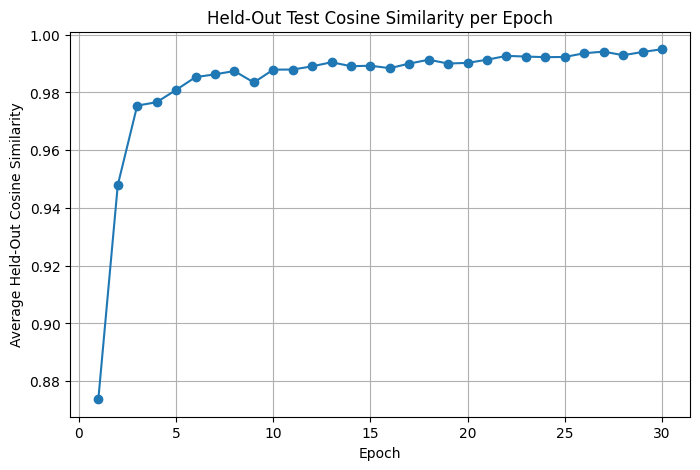

Model saved to output_dir/inversion_net_imagenet_0.pth


In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# --- Preliminaries ---
# Assume device, model_CLIP, tokenizer_CLIP, ln_weight, ln_bias, ln_eps are already defined,
# and that final_embeddings_images (shape: [10000, 768]) and final_embeddings_texts (shape: [14868, 768])
# are loaded and on the device.
#
# Also assume that:
#    mean_final_images = torch.mean(final_embeddings_images, axis=0)
#    mean_final_texts = torch.mean(final_embeddings_texts, axis=0)
#
# We force computations in fp32.
target_dtype = torch.float32

# Retrieve the projection matrix P and cast to fp32.
P = retrieve_proj_matrix(model_CLIP).to(device).float()

# Cast the mean tensors to fp32.
mean_final_images = torch.mean(final_embeddings_images, axis=0).to(target_dtype)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0).to(target_dtype)

# Freeze the CLIP model parameters (we only train the inversion network)
for param in model_CLIP.parameters():
    param.requires_grad = False

# --- Prepare the Dataset ---
# Use all available embeddings:
subset_images = final_embeddings_images.to(target_dtype)  # shape: [10000, 768]
subset_texts = final_embeddings_texts.to(target_dtype)      # shape: [14868, 768]

# For each sample, create a flag: 0 for image, 1 for text.
num_images = subset_images.shape[0]
num_texts = subset_texts.shape[0]
image_flags = torch.zeros(num_images, dtype=torch.long, device=device)  # flag 0 for images
text_flags = torch.ones(num_texts, dtype=torch.long, device=device)     # flag 1 for texts

# Concatenate embeddings and flags.
all_embeddings = torch.cat([subset_images, subset_texts], dim=0)  # shape: [24868, 768]
all_flags = torch.cat([image_flags, text_flags], dim=0)             # shape: [24868]

# Create a TensorDataset and DataLoader.
dataset = TensorDataset(all_embeddings, all_flags)
batch_size = 64
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


# Instantiate the inversion network and move it to device in fp32.
inversion_net = InversionNet().to(device).to(target_dtype)

# --- Define the Optimizer ---
optimizer = optim.Adam(inversion_net.parameters(), lr=1e-3)

# --- Training Loop ---
num_epochs = 30
log_interval = 10

# This list will store the held-out test cosine similarity after each epoch.
test_cosine_similarities = []

print("Starting training...")

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, (embeddings, flags) in enumerate(dataloader):
        embeddings = embeddings.to(device).to(target_dtype)
        flags = flags.to(device)
        
        # Prepare input for inversion network:
        # For text embeddings (flag==1): adjust with
        # x_input = embedding - mean_final_texts + mean_final_images.
        x_input = embeddings.clone()
        mask = (flags == 1)  # boolean mask for text samples
        x_input[mask] = x_input[mask] - mean_final_texts + mean_final_images

        optimizer.zero_grad()
        
        # Get the inversion network output.
        x_hat = inversion_net(x_input)
        
        # Pass through CLIP's post-layer norm and projection matrix P.
        f_x_hat = model_CLIP.visual.ln_post(x_hat) @ P  # shape: [batch_size, 768]
        
        # For text samples, add back mean_final_texts.
        f_x_hat[mask] = f_x_hat[mask] + mean_final_texts

        # Compute cosine similarity for each sample.
        cos_sim = F.cosine_similarity(f_x_hat, embeddings, dim=1)
        # Define the loss as 1 - average cosine similarity.
        loss = 1 - cos_sim.mean()
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if (i + 1) % log_interval == 0:
            avg_loss = running_loss / log_interval
            print(f"Epoch {epoch+1}, Batch {i+1}: Avg Cosine Loss = {avg_loss:.6f}")
            running_loss = 0.0

    # --- End-of-Epoch Evaluation on Held-Out Test Subset ---
    with torch.no_grad():
        # Here we use the first 128 samples from our dataset as the held-out test set.
        test_embeddings, test_flags = dataset[:128]
        test_embeddings = test_embeddings.to(device).to(target_dtype)
        test_flags = test_flags.to(device)
        
        x_input_test = test_embeddings.clone()
        mask_test = (test_flags == 1)
        x_input_test[mask_test] = x_input_test[mask_test] - mean_final_texts + mean_final_images
        
        x_hat_test = inversion_net(x_input_test)
        f_x_hat_test = model_CLIP.visual.ln_post(x_hat_test) @ P
        f_x_hat_test[mask_test] = f_x_hat_test[mask_test] + mean_final_texts

        cos_sim_test = F.cosine_similarity(f_x_hat_test, test_embeddings, dim=1)
        avg_cos_sim = cos_sim_test.mean().item()
        test_cosine_similarities.append(avg_cos_sim)
        print(f"Epoch {epoch+1} Test Average Cosine Similarity: {avg_cos_sim:.6f}")

# --- Plot the Held-Out Test Cosine Similarity ---
epochs = list(range(1, num_epochs + 1))
plt.figure(figsize=(8, 5))
plt.plot(epochs, test_cosine_similarities, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Average Held-Out Cosine Similarity')
plt.title('Held-Out Test Cosine Similarity per Epoch')
plt.grid(True)
plt.show()

output_dir = "output_dir"
os.makedirs(output_dir, exist_ok=True)
model_save_path = os.path.join(output_dir, f"inversion_net_imagenet_{seed}.pth")
torch.save(inversion_net.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


## Inversion approach manual

In [18]:
model_CLIP.to("cuda")

# Get an image and a query text
with torch.no_grad():
    prs.reinit()
    model_CLIP.eval()
    # If querying by text, define a text prompt and encode it into an embedding
    text_query = "cat."
    # Tokenize the text query and move it to the device (GPU/CPU)
    text_query_token = tokenizer_CLIP(text_query).to(device)  
    # Encode the tokenized text into a normalized embedding
    topic_emb = model_CLIP.encode_text(text_query_token, normalize=False)
    # If querying by image, load and preprocess the image from disk
    prs.reinit()  # Reinitialize any hooks if required
    text_query = "woman.png"
    image_pil = Image.open(f'images/{text_query}')
    image = preprocess_clip(image_pil)[np.newaxis, :, :, :]  # Add batch dimension
    if precision == "fp16":
        image = image.to(dtype=torch.float16)
        topic_emb = topic_emb.to(dtype=torch.float16)
        

    # Encode the image into a normalized embedding
    image_emb = model_CLIP.encode_image(
        image.to(device), 
        attn_method='head_no_spatial',
        normalize=False
    )
    print(image_emb.shape)
    print(topic_emb.shape)
# Center text embed on image embed
mean_final_images = torch.mean(final_embeddings_images, axis=0)
mean_final_texts = torch.mean(final_embeddings_texts, axis=0)

if precision == "fp16":
    mean_final_images = mean_final_images.to(dtype=torch.float16)
    mean_final_texts = mean_final_texts.to(dtype=torch.float16)

topic_emb = topic_emb - mean_final_texts + mean_final_images

print("Normal")
print("Normal topic emb norm ", topic_emb.norm())
print("Normal image emb norm", image_emb.norm())
print("Normal cosine", topic_emb @ image_emb.T)

# Project 
def remove(a, b):
    a = a.squeeze()
    b = b.squeeze()
    return (a - (torch.dot(a, b) / torch.dot(b, b)) * b).unsqueeze(0)
# Fictious values
mean = torch.tensor(0.15)
std = torch.tensor(1)

invert_topic_emb = invert_proj_layer_norm(topic_emb, P, ln_weight, ln_bias, std, mean, ln_eps)
invert_image_emb = invert_proj_layer_norm(image_emb, P, ln_weight, ln_bias, std, mean, ln_eps) # remove(invert_proj_layer_norm(image_emb, P, ln_weight, ln_bias, std, mean, ln_eps), invert_topic_emb)

print("After proj back")
print("Inner space projection topic norm", invert_topic_emb.norm())
print("Inner space projection image norm", invert_image_emb.norm())
print("Inner space projection cosine", invert_topic_emb @ invert_image_emb.T)

# Go back and revaluate
topic_emb_p = model_CLIP.visual.ln_post(invert_topic_emb) @ P
image_emb_p = model_CLIP.visual.ln_post(invert_image_emb) @ P

print("Normal proj back")
print("Outer space projection topic norm", topic_emb_p.norm())
print("Outer space projection image norm", image_emb_p.norm())
# print(torch.norm(topic_emb_p - image_emb_p))
print(topic_emb_p @ image_emb_p.T)

torch.Size([1, 768])
torch.Size([1, 768])
Normal
Normal topic emb norm  tensor(15.6797, device='cuda:0', dtype=torch.float16)
Normal image emb norm tensor(18.7500, device='cuda:0', dtype=torch.float16)
Normal cosine tensor([[25.4531]], device='cuda:0', dtype=torch.float16)
After proj back
Inner space projection topic norm tensor(253.6250, device='cuda:0', dtype=torch.float16)
Inner space projection image norm tensor(30.8750, device='cuda:0', dtype=torch.float16)
Inner space projection cosine tensor([[-763.]], device='cuda:0', dtype=torch.float16)
Normal proj back
Inner space projection topic norm tensor(4.6641, device='cuda:0', dtype=torch.float16,
       grad_fn=<LinalgVectorNormBackward0>)
Inner space projection image norm tensor(19.4375, device='cuda:0', dtype=torch.float16,
       grad_fn=<LinalgVectorNormBackward0>)
tensor([[34.9375]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward0>)
